In [1]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv
from matplotlib import pyplot as plt
import cv2
import json
from pathlib import Path
import numpy as np
import torch
from tqdm import tqdm
import pandas as pd
import seaborn as sn
import pandas as pd
from collections import OrderedDict
import json
#from ensemble_boxes import *
import copy

In [2]:
#config_file = '../configs/detectors/dent_detector_latest_segm.py'
#checkpoint_file = '../models/dent_model_detestoRS/epoch_13.pth'

#config_file = '../models/loose/loose.py'
#checkpoint_file = '../models/loose/epoch_9.pth'

#config_file = '../models/crack_mosaic/crack_mosaic.py'
#checkpoint_file = '../models/crack_mosaic/epoch_7.pth'

#config_file = '../models/scrach_mosaic_5k/scratch_mosaic_detectors.py'
#checkpoint_file = '../models/scrach_mosaic_5k/epoch_9.pth'

#dent pseudo
#config_file = '../models/dent_pseudo/dent_pseudo.py'
#checkpoint_file = '../models/dent_pseudo/epoch_9.pth'

#scratch pseudo
#config_file = '../models/scratch_pseudo/scratch_pseudo.py'
#checkpoint_file = '../models/scratch_pseudo/epoch_9.pth'

#scratch pseudo brightness
#config_file = '../models/scratch_pseudo_brightness/scratch_pseudo.py'
#checkpoint_file = '../models/scratch_pseudo_brightness/epoch_9.pth'

#dent pseudo brightness augment
#config_file = '../models/dent_pseudo_brightness/dent_pseudo.py'
#checkpoint_file = '../models/dent_pseudo_brightness/epoch_9.pth'

#config_file = '../models/crack_mosaic/crack_mosaic.py'
#checkpoint_file = '..//models/missing_model2/epoch_11.pth'

#config_file = '../models/mmd_pseudo_model_15_7/dent/dent_pseudo.py' 
#checkpoint_file = '../models/mmd_pseudo_model_15_7/dent/epoch_9.pth'

config_file = '../work_dirs/loose_albu_rotate/loose.py' 
checkpoint_file = '../work_dirs/loose_albu_rotate/epoch_26.pth'

In [3]:
model = init_detector(config_file, checkpoint_file, device='cuda:0')

/mmdetection/mmdet/core/anchor/builder.py:16: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  '``build_anchor_generator`` would be deprecated soon, please use '


Use load_from_local loader


In [4]:
#path = Path('../data/generali/dent')
path = Path('../data/loose')

In [17]:
test = json.load(open(path/'annotations'/'train.json'))
#test = json.load(open('test.json'))
print(test['info'])
print(len(test['images']),len(test['annotations']))
#print(test.keys())
#print(test['annotations'][0])
#print(test['images'][0])
#print(test['categories'])

{'description': 'Car Parts Dataset', 'url': 'http://cocodataset.org', 'version': '1.0', 'year': 2017, 'contributor': 'COCO Consortium', 'date_created': '2017/09/01'}
7541 11252


In [6]:
#total_yolo_bboxes = json.load(open('yolo_old_test_15_7_scratch.json'))

{'id': 629, 'license': 4, 'coco_url': 'coco.org', 'flickr_url': 'flickr.org', 'task_name': 'nothing', 'url': 'https://s3.amazonaws.com/mc-ai/dataset/KBC/CZ/images_CSOB/2164029324/316836478_20170323_151626.jpg', 'width': 2048, 'height': 1152, 'file_name': 'https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2164029324_316836478_20170323_151626.jpg', 'date_captured': '2013-12-15 02:41:52'}


/mmdetection/mmdet/datasets/utils.py:68: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)
/mmdetection/mmdet/core/anchor/anchor_generator.py:323: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/mmdetection/mmdet/core/anchor/anchor_generator.py:360: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[0.9619627 0.4114747]
[[(502, 459), (553, 575)], [(455, 225), (586, 263)]]


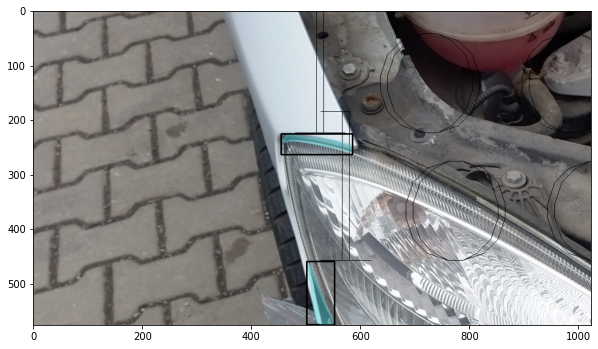

In [6]:
img = cv2.imread(str(path/'images'/test['images'][0]['file_name']))
print(test['images'][0])
h,w,_ = img.shape
img = img[:int(h/2),:int(w/2)]
result = inference_detector(model,img)
img_,pred_boxes,pred_segms,pred_labels,scores = show_result_pyplot(model, img.copy(), result,score_thr=0.4)
#img_ = show_result_pyplot(model, img.copy(), result,score_thr=0.4)
print(scores)
plt.figure(figsize=(10,10))
plt.imshow(img_)
print(pred_boxes)

In [7]:
#sample = plot_annos(629)
#plt.imshow(sample)

NameError: name 'plot_annos' is not defined

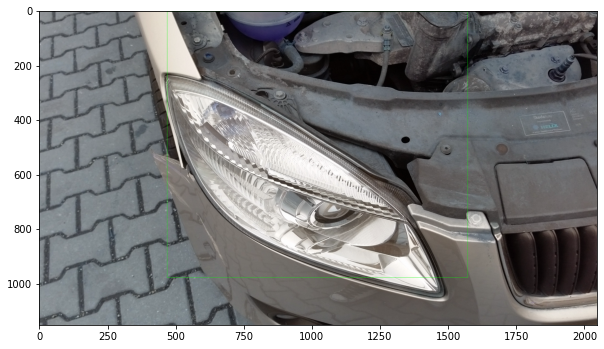

In [45]:
img = cv2.imread(str(path/'images'/test['images'][0]['file_name']))
result = inference_detector(model,img)
img_,pred_boxes,pred_segms,pred_labels,scores = show_result_pyplot(model, img.copy(), result,score_thr=0.4)
plt.figure(figsize=(10,10))
plt.imshow(img_)

In [ ]:
result = inference_detector(model,img)
img_,pred_boxes,pred_segms,pred_labels,scores = show_result_pyplot(model, img.copy(), result,score_thr=0.4)
plt.figure(figsize=(10,10))
plt.imshow(img_)

In [11]:
def normolize_box(boxes,height,width):
    new_boxes = []
    #print(boxes)
    #boxes.pop()
    #boxes = [[boxes[0],boxes[1]],[boxes[2],boxes[3]]]
    for b in boxes:
        new_b = []
        #b = [[b[0],b[1]],[b[2],b[3]]]
        for p in b:
            new_b.extend(np.array(p)/(width,height))
        new_boxes.append(new_b)
    #print(new_boxes)
    return new_boxes

def get_data_box_ensemble(img,idx,name,boxes,segms,labels,scores):
    data_box = OrderedDict()
    data_box['image'] = name
    #print(boxes)
    i_boxes = total_yolo_bboxes[str(idx)]['boxes']
    yolo_boxes = copy.deepcopy(i_boxes)
    h,w = img.shape[:2]
    for j in range(len(yolo_boxes)):
        yolo_boxes[j][0] = int(yolo_boxes[j][0]*w)
        yolo_boxes[j][1] = int(yolo_boxes[j][1]*h)
        yolo_boxes[j][2] = int(yolo_boxes[j][2]*w)
        yolo_boxes[j][3] = int(yolo_boxes[j][3]*h)
        yolo_boxes[j] = [(yolo_boxes[j][0],yolo_boxes[j][1]),(yolo_boxes[j][2],yolo_boxes[j][3])] 
    #print(yolo_boxes)
    check_boxes = [0 for i in yolo_boxes]
    check_pred = [0 for i in boxes]
    out_boxes = []
    out_fp_boxes = []
    for i,b in enumerate(boxes):
        ious = [cal_iou(img,b,j) for j,check in zip(yolo_boxes,check_boxes) if check == 0]
        
        if len(ious) == 0:
            break
        max_id = np.argmax(ious)
        
        if ious[max_id] >= 0.25 : 
            out_boxes.append(b)
            check_boxes[max_id] = 1
            check_pred[i] = 1
        else:
            out_fp_boxes.append(b)
            check_pred[i] = -1
    #print('out:',out_boxes)
    data_box['boxes'] = normolize_box(out_boxes,*img.shape[:-1])
    
    segm_masks = []
    #print('check',segms.sum())
    for i,segm in enumerate(segms) :
        #if check_pred[i] == 0: # for fp only
        if check_pred[i] != 1 : 
            continue
        segm = segm.astype(np.uint8)
        contours, _ = cv2.findContours(segm, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contours = [c.tolist() for c in contours]
        segm_masks.append(contours)
        
    data_box['segms'] = segm_masks
    data_box['labels'] = labels.tolist()
    #print('scores :',scores)
    #print('check :',check_pred)
    data_box['scores'] = [float(s) for s,c in zip(scores,check_pred) if c == 1]
    
    return data_box

def get_data_box(img,name,boxes,labels,scores):
    data_box = OrderedDict()
    data_box['image'] = name
    data_box['boxes'] = normolize_box(boxes,*img.shape[:-1])
    data_box['labels'] = labels.tolist()
    data_box['scores'] = scores.tolist()
    
    return data_box

def get_data_box_flip(img,name,boxes,labels,scores):
    data_box = OrderedDict()
    data_box['image'] = name
    
    boxes = normolize_box(boxes,*img.shape[:-1])
    for i in range(len(boxes)):
        boxes[i][0] = 1-boxes[i][0]
        boxes[i][2] = 1-boxes[i][2]
    data_box['boxes'] = boxes
    
    data_box['labels'] = labels.tolist()
    data_box['scores'] = scores.tolist()
    
    return data_box

In [13]:
data = OrderedDict()

for i in tqdm(test['images']):
    image = cv2.imread(str(path/'images'/i['file_name']))
    result = inference_detector(model, image)
    img_,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(model, image.copy(), result,score_thr=0.3)
    #data[i['id']] = get_data_box_ensemble(image,i['id'],i['file_name'],pred_boxes,pred_segms,pred_labels,pred_scores)
    data[i['id']] = get_data_box(image,i['file_name'],pred_boxes,pred_labels,pred_scores)
    #break
with open('loose.json', 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=4)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1616/1616 [07:36<00:00,  3.54it/s]


In [103]:
data_flip = OrderedDict()

for i in tqdm(test['images']):
    image = cv2.imread(str(path/'images'/i['file_name']))
    image = np.fliplr(image)
    result = inference_detector(model, image)
    img_,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(model, image.copy(), result,score_thr=0.4)
    data_flip[i['id']] = get_data_box_flip(image,i['file_name'],pred_boxes,pred_labels,pred_scores)

with open('detector_pred_flip.json', 'w', encoding='utf-8') as f:
    json.dump(data_flip, f, ensure_ascii=False, indent=4)

100%|██████████| 738/738 [06:12<00:00,  1.98it/s]


In [18]:
#pred_data = json.load(open('detector_pred.json'))
#
'''
#es = json.load(open('./merimen/yolo_pred_crack.json')) 
#yolo_pred.json
detector_pred
es = json.load(open('./yolo_pred.json'))
'''
pred_data = json.load(open('./detector_pred.json'))
pred_data_flip = json.load(open('./merimen/yolo_pred_crack.json'))

In [19]:
'''

def remove_ovelap(boxes):
    idx = [True for b in boxes]
    for i1 in range(len(boxes)-1) :
        for i2 in range(i1+1,len(boxes)):
            if idx[i1] == True and boxes[i1][0] < boxes[i2][0] and boxes[i1][1] < boxes[i2][1] and boxes[i1][2] > boxes[i2][2] and boxes[i1][3] > boxes[i2][3] :
                idx[i1] = False
                break
            
            if idx[i2] == True and boxes[i1][0] > boxes[i2][0] and boxes[i1][1] > boxes[i2][1] and boxes[i1][2] < boxes[i2][2] and boxes[i1][3] < boxes[i2][3] :
                idx[i2] = False
                continue
    return boxes[idx]
            
es = OrderedDict()
for i in test['images']:
    boxes_list = [pred_data[str(i['id'])]['boxes'], pred_data_flip[str(i['id'])]['boxes']]
    scores_list = [pred_data[str(i['id'])]['scores'], pred_data_flip[str(i['id'])]['scores']]
    labels_list = [pred_data[str(i['id'])]['labels'], pred_data_flip[str(i['id'])]['labels']]
    
    if len(boxes_list[0]) == 0 and len(boxes_list[1])==0:
        i_data = OrderedDict()
        i_data['name'] = i['file_name']
        i_data['boxes'] = []
        i_data['labels'] = []
        es[str(i['id'])] = i_data
        continue
    
    if len(boxes_list[0]) == 0 :
        i_data = OrderedDict()
        i_data['name'] = i['file_name']
        i_data['boxes'] = boxes_list[1]
        i_data['labels'] = labels_list[1]
        es[str(i['id'])] = i_data
        continue
    
    if len(boxes_list[1]) == 0 :
        i_data = OrderedDict()
        i_data['name'] = i['file_name']
        i_data['boxes'] = boxes_list[0]
        i_data['labels'] = labels_list[0]
        es[str(i['id'])] = i_data
        continue
    
    weights = [2,1]
    iou_thr = 0.36
    skip_box_thr = 0.0001
    sigma = 0.1
    
    boxes, scores, labels = non_maximum_weighted(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr,skip_box_thr=skip_box_thr)

    i_data = OrderedDict()
    i_data['name'] = i['file_name']
    i_data['boxes'] = boxes.tolist()
    i_data['labels'] = labels.tolist()
    es[str(i['id'])] = i_data
    #print(len([a for a in test['annotations'] if a['image_id']==i['id']]))
    #img = cv2.imread(str(path/'images'/i['file_name']))
    #plot(img,boxes,scores)
    #break
with open('./merimen/ensemble_crack_d_y.json', 'w', encoding='utf-8') as f:
    json.dump(es, f, ensure_ascii=False, indent=4)
'''

In [14]:
def plot(idx, boxes):
    image = cv2.imread(str(path/'images'/es[str(idx)]['name']))
    img = image.copy()
    h,w, _ = img.shape
    for i in range(len(boxes)):
        img = cv2.rectangle(img,(int(boxes[i][0]*w),int(boxes[i][1]*h)),(int(boxes[i][2]*w),int(boxes[i][3]*h)),(255,255,0),2)
    
    i = [i for i in test['images'] if i['file_name']==es[str(idx)]['name']][0]
    gt_boxes = [a['bbox'] for a in test['annotations'] if a['image_id']==i['id']]
    gt_boxes = [[(int(b[0]),int(b[1])),(int(b[0])+int(b[2]),int(b[1])+int(b[3]))] for b in gt_boxes]
    
    for i in range(len(gt_boxes)):
        image = cv2.rectangle(image,gt_boxes[i][0],gt_boxes[i][1],(255,0,0),2)
    
    plt.figure(figsize=(20,10))
    plt.imshow(np.hstack((img,image)))
    #return np.hstack((img,image))

def plot_fp(idx,i_boxes):
    img = cv2.imread(str(path/'images'/es[str(idx)]['image']))
    img_out = img.copy()
    
    h,w, _ = img.shape
    
    i = [i for i in test['images'] if i['file_name']==es[str(idx)]['image']][0]
    gt_boxes = [a['bbox'] for a in test['annotations'] if a['image_id']==i['id']]
    gt_boxes = [[(int(b[0]),int(b[1])),(int(b[0])+int(b[2]),int(b[1])+int(b[3]))] for b in gt_boxes]
    gt_labels = [0 for i in gt_boxes]
    
    boxes = copy.deepcopy(i_boxes)
    for j in range(len(boxes)):
        boxes[j][0] = int(boxes[j][0]*w)
        boxes[j][1] = int(boxes[j][1]*h)
        boxes[j][2] = int(boxes[j][2]*w)
        boxes[j][3] = int(boxes[j][3]*h)
        boxes[j] = [(boxes[j][0],boxes[j][1]),(boxes[j][2],boxes[j][3])] 
    
    pred_labels = [0 for i in boxes]
    
    pred_tp = [0 for i in boxes]
    gt_tp = [0 for i in gt_boxes]
    
    for i in range(len(boxes)):
        i_gt_boxes = [m for (m,n) in zip(gt_boxes,gt_labels) if n == pred_labels[i]]
        for j in range(len(i_gt_boxes)):
            #print(boxes[i],i_gt_boxes[j])
            iou = cal_iou(img,boxes[i],i_gt_boxes[j])
            if iou > 0.25:
                idx = gt_boxes.index(i_gt_boxes[j])
                gt_labels[idx] = -1
                pred_tp[i] = 1
                gt_tp[idx] = 1
                break
    
    for i in range(len(pred_tp)):
        #print(i)
        #print(boxes[i][0])
        if pred_tp[i]:
            img_out = cv2.rectangle(img_out,boxes[i][0],boxes[i][1],(255,255,0),2)
        else:
            img_out = cv2.rectangle(img_out,boxes[i][0],boxes[i][1],(0,0,255),2)
    
    
    for i in range(len(gt_tp)):
        if gt_tp[i]:
            img = cv2.rectangle(img,gt_boxes[i][0],gt_boxes[i][1],(255,255,0),2)
        else:
            img = cv2.rectangle(img,gt_boxes[i][0],gt_boxes[i][1],(0,0,255),2)    
    #print(img_out.shape,img.shape)
    return np.hstack((img_out,img))

def plot_fp_v2(idx,i_boxes):
    #get predict boxes and groudtruth_box 
    img = cv2.imread(str(path/'images'/es[str(idx)]['image']))
    img_out = img.copy()
    #print('test : ',es[str(idx)]['image'],es[str(idx)]['scores'])
    
    h,w, _ = img.shape
    
    i = [i for i in test['images'] if i['file_name']==es[str(idx)]['image']][0]
    gt_boxes = [a['bbox'] for a in test['annotations'] if a['image_id']==i['id']]
    gt_boxes = [[(int(b[0]),int(b[1])),(int(b[0])+int(b[2]),int(b[1])+int(b[3]))] for b in gt_boxes]
    gt_labels = [0 for i in gt_boxes]
    
    boxes = copy.deepcopy(i_boxes)
    for j in range(len(boxes)):
        boxes[j][0] = int(boxes[j][0]*w)
        boxes[j][1] = int(boxes[j][1]*h)
        boxes[j][2] = int(boxes[j][2]*w)
        boxes[j][3] = int(boxes[j][3]*h)
        boxes[j] = [(boxes[j][0],boxes[j][1]),(boxes[j][2],boxes[j][3])] 
        
    ## boxes and gt_boxes are list of [[(x1,y1),(x2,y2)],.....]
    ## gt_labels of coressponding gt_boxes
    
    # calculate iou of predict and grouthtruth base on AP25
    pred_tp = [0 for i in boxes]  # to mark tp in predict
    gt_tp = [0 for i in gt_boxes] # to mark tp in grouth truth
    check_fp = False
    for i in range(len(boxes)):
        ious = [cal_iou(img,boxes[i],gt_boxes[j]) for j in range(len(gt_boxes))]
        _idx = np.argmax(ious)
        
        if gt_tp[_idx] == 1 :
            continue
        
        if ious[_idx] >= 0.25:
            pred_tp[i] = 1         # mark 1 as predict box is correct
            gt_tp[_idx] = 1         # mark 1 as grouth truth box is predicted
        else:
            pred_tp[i] = -1
            check_fp =True
            
    if len([0 for i in pred_tp if i==1]) == 0 :
        return None,0
    # draw TP, FP, FN
    #print(pred_tp)
    font = cv2.FONT_HERSHEY_SIMPLEX
    for i in range(len(pred_tp)):
        if pred_tp[i]==1:
            img_out = cv2.rectangle(img_out,boxes[i][0],boxes[i][1],(255,255,0),2) #TP
            #print(es[str(idx)]['scores'],i)
            cv2.putText(img_out,"{:.2f}".format(es[str(idx)]['scores'][i]),boxes[i][0], font, 1,(255,255,0),2)
            
        elif pred_tp[i]==-1:
            img_out = cv2.rectangle(img_out,boxes[i][0],boxes[i][1],(0,0,255),2)   #FP
    
    
    for i in range(len(gt_tp)):
        if gt_tp[i]:
            img = cv2.rectangle(img,gt_boxes[i][0],gt_boxes[i][1],(255,255,0),2)  #TP
        else:
            img = cv2.rectangle(img,gt_boxes[i][0],gt_boxes[i][1],(0,0,255),2)    #FN
            
    return np.hstack((img_out,img)), check_fp



def cal_iou(img,box1,box2):
    #input 
    # img : cv2 image
    # box1, box2 is [(x1,y1),(x2,y2)]
    # output : iou of box1 and box2
    
    mask1 = np.zeros_like(img[:,:,0])
    mask1[box1[0][1]:box1[1][1],box1[0][0]:box1[1][0]] = 1
    
    mask2 = np.zeros_like(img[:,:,0])
    mask2[box2[0][1]:box2[1][1],box2[0][0]:box2[1][0]] = 1
    
    intersect = np.logical_and(mask1,mask2)
    
    if intersect.sum() == 0:
        return 0
    
    return intersect.sum() / (mask1.sum()+mask2.sum()-intersect.sum())

def cal_iou_mask(img,contour1,contour2):
    #print(contour1)
    #print(contour2)
    #print(img.shape[:2])
    mask1 = np.zeros(img.shape[:2])
    mask2 = np.zeros(img.shape[:2])
    #print(mask1.shape,mask2.shape)
    
    mask1 = cv2.fillPoly(mask1,contour1,1)
    mask2 = cv2.fillPoly(mask2,[contour2],1)
    
    plt.imshow(np.hstack([mask1,mask2]))
    intersect = np.logical_and(mask1,mask2)
    
    if intersect.sum() == 0:
        return 0
    
    return intersect.sum() / (mask1.sum()+mask2.sum()-intersect.sum())
    #pass

def cal(img,pred_boxes,pred_labels,gt_boxes,gt_labels, name):
    tp = 0
    
    for i in range(len(pred_boxes)):
        i_gt_boxes = [m for (m,n) in zip(gt_boxes,gt_labels) if n == pred_labels[i]]
        for j in range(len(i_gt_boxes)):
            iou = cal_iou(img,pred_boxes[i],i_gt_boxes[j])
            if iou > 0.25 :
                tp += 1
                idx = gt_boxes.index(i_gt_boxes[j])
                #gt_labels[idx] = -1
                break
            
    fp = len(pred_boxes) - tp
    fn = len(gt_boxes) - tp
    
    return tp,fp,fn 

#global check_dense = 0
def cal_v2(img,pred_boxes,pred_labels,gt_boxes,gt_labels, name,check_dense):
    fp = 0
    tp = 0
    fp_boxes = []
    tp_check = [0 for i in pred_boxes]
    
    for i in range(len(pred_boxes)):
        ious = [cal_iou(img,pred_boxes[i],gt_boxes[j]) for j in range(len(gt_boxes))]
        
        if len(ious) == 0:
            return 0,0,0,fp_boxes
        
        idx = np.argmax(ious)

        if gt_labels[idx] == -1 :
            continue

        if ious[idx] >= 0.25:
            gt_labels[idx] = -1
            tp += 1
            tp_check[i] = 1
        else:
            fp += 1
            fp_boxes.append(pred_boxes[i])

    fn = len(gt_boxes) - tp
    
    if len(gt_boxes) >= 8 and tp/len(gt_boxes) > 1:
        check_dense += 1
        
        print('dense cases :',check_dense)
        fp = 0
    
    return tp,fp,fn, fp_boxes,check_dense, tp_check

In [15]:
def plot_fp_v2_with_segm(idx,i_boxes,i_segms):
    #get predict boxes and groudtruth_box 
    img = cv2.imread(str(path/'images'/es[str(idx)]['image']))
    
    img_out = img.copy()
    
    h,w, _ = img.shape
    
    i = [i for i in test['images'] if i['file_name']==es[str(idx)]['image']][0]
    gt_boxes = [a['bbox'] for a in test['annotations'] if a['image_id']==i['id']]
    gt_boxes = [[(int(b[0]),int(b[1])),(int(b[0])+int(b[2]),int(b[1])+int(b[3]))] for b in gt_boxes]
    
    gt_segms = [np.array(a['segmentation']).reshape(-1,2).astype(np.int32) for a in test['annotations'] if a['image_id']==i['id']]
    gt_labels = [0 for i in gt_boxes]
    
    boxes = copy.deepcopy(i_boxes)
    for j in range(len(boxes)):
        boxes[j][0] = int(boxes[j][0]*w)
        boxes[j][1] = int(boxes[j][1]*h)
        boxes[j][2] = int(boxes[j][2]*w)
        boxes[j][3] = int(boxes[j][3]*h)
        boxes[j] = [(boxes[j][0],boxes[j][1]),(boxes[j][2],boxes[j][3])] 
        
    segms = copy.deepcopy(i_segms)
    for i,segm in enumerate(segms):
        segms[i] = [np.array(s).astype(np.int32) for s in segms[i]]
        
    ## boxes and gt_boxes are list of [[(x1,y1),(x2,y2)],.....]
    ## gt_labels of coressponding gt_boxes
    
    # calculate iou of predict and grouthtruth base on AP25
    pred_tp = [0 for i in boxes]  # to mark tp in predict
    gt_tp = [0 for i in gt_boxes] # to mark tp in grouth truth

    for i in range(len(boxes)):
        #print([(boxes[i],gt_boxes[j]) for j in range(len(gt_boxes))])
        if len(gt_boxes)==0:
            pred_tp = [-1 for i in boxes]
            break
        ious = [cal_iou_mask(img,segms[i],gt_segms[j]) for j in range(len(gt_boxes))]
        idx = np.argmax(ious)
        
        if gt_tp[idx] == 1 :
            continue
        
        if ious[idx] >= 0.25:
            pred_tp[i] = 1         # mark 1 as predict box is correct
            gt_tp[idx] = 1         # mark 1 as grouth truth box is predicted
        else:
            pred_tp[i] = -1
            
    
    # draw TP, FP, FN
    #print(pred_tp)
    for i in range(len(pred_tp)):
        #print(segms[i])
        if pred_tp[i]==1:
            img_out = cv2.rectangle(img_out,boxes[i][0],boxes[i][1],(255,255,0),2) #TP
            img_out = cv2.drawContours(img_out,segms[i],-1,(255,255,0),2)
        elif pred_tp[i]==-1:
            img_out = cv2.rectangle(img_out,boxes[i][0],boxes[i][1],(0,0,255),2)   #FP
            img_out = cv2.drawContours(img_out,segms[i],-1,(0,0,255),2)
    
    
    for i in range(len(gt_tp)):
        if gt_tp[i]:
            img = cv2.rectangle(img,gt_boxes[i][0],gt_boxes[i][1],(255,255,0),2)  #TP
            img = cv2.drawContours(img,np.array([gt_segms[i]]),-1,(255,255,0),2)
        else:
            #print(gt_segms[i])
            img = cv2.rectangle(img,gt_boxes[i][0],gt_boxes[i][1],(0,0,255),2)    #FN
            img = cv2.drawContours(img,np.array([gt_segms[i]]),-1,(0,0,255),2)
            
    return np.hstack((img_out,img))

In [16]:
#es = json.load(open('./merimen/yolo_pred_crack.json')) 
#yolo_pred.json
es = json.load(open('loose.json')) 
total_tp = 0
total_fn = 0
total_fp = 0
#c = 0
#for i in es.keys():
#    c += len(es[i]['scores'])
#print(c)
fp_cases = OrderedDict()
check_dense = 0
count_gt = 0
for i in tqdm(test['images']):
    image = cv2.imread(str(path/'images'/i['file_name']))
    h,w,_=image.shape
    gt_boxes = [a['bbox'] for a in test['annotations'] if a['image_id']==i['id']]
    count_gt += len(gt_boxes)
    gt_boxes = [[(int(b[0]),int(b[1])),(int(b[0])+int(b[2]),int(b[1])+int(b[3]))] for b in gt_boxes]
    #gt_segms = [np.array(a['segmentation']).reshape(-1,2).astype(np.int32) for a in test['annotations'] if a['image_id']==i['id']]    
    gt_labels = [a['category_id'] for a in test['annotations'] if a['image_id']==i['id']]
    
    
    pred_boxes = copy.deepcopy(es[str(i['id'])]['boxes'])
    for j in range(len(pred_boxes)):
        pred_boxes[j][0] = int(pred_boxes[j][0]*w)
        pred_boxes[j][1] = int(pred_boxes[j][1]*h)
        pred_boxes[j][2] = int(pred_boxes[j][2]*w)
        pred_boxes[j][3] = int(pred_boxes[j][3]*h)
        
        pred_boxes[j] = [(pred_boxes[j][0],pred_boxes[j][1]),(pred_boxes[j][2],pred_boxes[j][3])]
    
    #pred_segms = copy.deepcopy(es[str(i['id'])]['segms'])
    #for idx,segm in enumerate(pred_segms):
    #    pred_segms[idx] = [np.array(s).astype(np.int32) for s in pred_segms[idx]]
    
    #print(i['id'])
    #print(es[str(i['id'])])
    pred_labels = es[str(i['id'])]['labels']
    
    print(i['id'],i['file_name'])
    old_check = check_dense
    tp,fp,fn, fp_boxes,check_dense, tp_check = cal_v2(image,pred_boxes,pred_labels,gt_boxes,gt_labels, i['file_name'],old_check)
    #tp,fp,fn, fp_boxes = cal_v2(image,pred_segms,pred_labels,gt_segms,gt_labels, i['file_name'])
    if check_dense - old_check == 1:
        dense_path = Path('dense_scratch')
        dense_path.mkdir(parents=True,exist_ok=True)
        idx = i['id']
        out,check = plot_fp_v2(idx,es[str(idx)]['boxes'])
        cv2.imwrite(str(dense_path/(str(idx)+'.jpg')),out)
    es[str(i['id'])]['tp_check'] = tp_check
    total_tp += tp
    total_fp += fp
    total_fn += fn
    
    if len(fp_boxes) > 0:
        fp_cases[i['file_name']] = fp_boxes
    
    
    print(tp,fp,fn)
    #break
    #print(pred_boxes)
    #break 1439 1 0 0
print(total_tp,total_fp,total_fn,check_dense,count_gt)
#with open('new_and_ensemble_scratch_off', 'w', encoding='utf-8') as f:
#    json.dump(es, f, ensure_ascii=False, indent=4)

  0%|▍                                                                                               | 8/1616 [00:00<00:40, 39.91it/s]

629 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2164029324_316836478_20170323_151626.jpg
0 2 1
9869 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0737_rear_right_view_29599_medium_15680599854454605454525464827414.jpg
1 0 0
1439 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1151_DSCN2016mark+(4).JPG
1 0 0
9704 https:__s3.amazonaws.com_mc-imt_vehicle_2019X8185_rear_left_view_17014_medium_15476571770162792754354688599166.jpg
1 0 0
10104 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5241_front_left_view_26015_medium_image.jpg
1 0 0
8316 https:__s3.amazonaws.com_mc-imt_vehicle_2020B3724_vehicle_additional_docs_34472_medium_IMG_3807.JPG
1 1 1
1525 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1190_IMG-20181218-WA0036.jpg
1 2 1
3423 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_676_IMG_4255.JPG
3 0 0
1792 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1353_DSCN3449.JPG


  1%|▌                                                                                              | 10/1616 [00:00<02:57,  9.07it/s]

1 1 0
561 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131826265_img2290592.jpg
1 1 0
5040 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_DC%2014A%20-%20291.62%20-%2006.06.2018_z1012613985330_214277b0e77f4ca4a31e84a0523c3505.jpg
1 0 0
8716 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1298_front_left_view_45718_medium_159735325305798337210.jpg
1 0 0
7016 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1098_rear_right_view_29723_medium_image.jpg
1 0 1
1068 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_987_IMG-20190305-WA0015mark+(2).jpg


  1%|▊                                                                                              | 14/1616 [00:01<02:31, 10.54it/s]

2 1 0
6190 https:__s3.amazonaws.com_mc-imt_vehicle_2019A9304_front_left_view_33401_medium_1576103776202661158273.jpg
1 0 0
3467 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_693_IMG_8164.JPG
1 0 1
3857 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_856_IMG_8099.JPG
1 0 0
3387 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_655_IMG_7834.JPG
1 0 0
9348 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5453_rear_right_view_20535_medium_E1B3CCF5-16FA-4CB4-A4DD-826CF013BA02.jpeg
2 0 2
3128 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_532_IMG_7810.JPG
0 2 1
1737 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1317_DSCN6239.JPG


  2%|█▍                                                                                             | 25/1616 [00:01<02:01, 13.07it/s]

0 1 4
35 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908517_img2975718.jpg
1 0 0
8650 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5204_rear_right_view_14849_medium_image.jpg
1 0 0
4790 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_IMG_3169.JPG
1 0 0
1907 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1485_DSCN5656.JPG
2 0 0
10222 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5174_detail_damage2_20292_medium_image.jpg
1 3 2
2900 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_444_DSCN3208.jpg
2 1 1
8868 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1492_vehicle_additional_docs_18295_medium_FCC1AA65-1878-4900-930A-05BA88B8CEC2.jpeg
1 0 0
6151 https:__s3.amazonaws.com_mc-imt_vehicle_2018X2674_front_right_view_14244_medium_image.jpg
0 2 1
7335 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBbWNaIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--46a70e839078f611c083877f3dd079813dc4c723_20201106_114555.jpg


  2%|██▏                                                                                            | 37/1616 [00:02<01:55, 13.62it/s]

2 0 0
3346 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_636_IMG_8374.JPG
1 1 1
3322 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_625_IMG_4334.JPG
1 0 0
4824 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_79e8a8e233b08821509f84a0bfc422cd.JPG
1 0 0
8069 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7362_front_right_view_22018_medium_20190424_124842.jpg
1 0 0
7217 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7485_front_left_view_36611_medium_image.jpg
0 3 2
6760 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6791_rear_right_view_36619_medium_C65DD504-2997-4728-91E5-4F1744A9559A.jpeg
1 0 0
6256 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3057_rear_left_view_24892_medium_15608930354532750701283043274577.jpg
1 0 0
7877 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3480_vehicle_additional_docs_51214_medium_image.jpg
1 1 0
7708 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7460_vehicle_additional_docs_27929_medium_image.jpg
1 0 0
7239 https:__s3.amazonaws.com_mc-imt_vehicle

  3%|██▌                                                                                            | 43/1616 [00:02<01:30, 17.33it/s]

2 1 0
4542 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20184.81%20-%2011.06.2018_z1017151890900_e10739364b968a46ad1c44b29845473e.jpg
2 0 2
4493 https:__mc-ai.s3.amazonaws.com_vn_car_an_1_anh_giam_dinh_anh_hai_29A-410.64_IMG_6232.JPG
0 3 1


  3%|██▊                                                                                            | 47/1616 [00:03<01:40, 15.66it/s]

8184 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBdEVUIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--c75dc06dcf51c9571c4da85b09d52896a99c4c2c_image.jpg
0 1 1
9320 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6438_front_left_view_15430_medium_15444572867283283364901368149464.jpg
2 0 0
6955 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBazhYIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--d8ca290cc14aa97f403625fdfe64ecd5fd5399e4_20201030_093009.jpg
1 1 2
6937 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBdFVUIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--2d105de4a415834ff126297e105905d90a412731_image.jpg


  3%|██▉                                                                                            | 50/1616 [00:04<03:38,  7.15it/s]

0 4 1
7699 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1863_vehicle_additional_docs_28574_medium_B5C7263F-E9F5-4667-8CEC-F1DA43101080.jpeg
0 0 4
7158 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBdmtxIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--06d2fce8228f4644be061663a335e6228a55f484_image.jpg


  3%|███                                                                                            | 53/1616 [00:04<03:25,  7.61it/s]

0 4 1
5241 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_TD%2014A%20-%20252.03%20-%2027.08.2018_z1095221544747_ae479c06d2b482b9e6d1f20f9525f1c9.jpg
0 4 1
4302 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20117.54%20-%2024.07.2018_z1061646779178_23d850f5159d13bcff22b862a127086c.jpg
0 2 1
7263 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6864_rear_left_view_32990_medium_image.jpg
0 2 1
6056 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8545_rear_left_view_24948_medium_F87E5F55-4BC1-434E-A7F2-283019F34969.jpeg
1 0 0
10410 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z0898_detail_damage2_24105_medium_15595757736204996160635855960781.jpg
1 0 0
4807 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_86cf6325031415dc47d192200f67a70c.JPG


  4%|███▋                                                                                           | 62/1616 [00:04<02:05, 12.39it/s]

1 0 0
367 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000392_315542753_PZblatnk2.JPG
1 0 0
7677 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7013_vehicle_additional_docs_32634_medium_image.jpg
1 0 1
3170 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_550_IMG_0953.JPG
1 0 0
10619 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6615_detail_damage2_21508_medium_image.jpg
1 0 0
5715 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_TD%2014A%20-%20282.17%20-%2030.10.2018_z1161033058078_4236e0b483d6832b09e62910cba85af0.jpg
1 3 2
10512 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5887_detail_damage2_26565_medium_image.jpg
1 0 0
4621 https:__s3.amazonaws.com_mc-ai_vn_car_an_1_anh_tai_nan_06b1848cf88119df4090.jpg


  4%|███▊                                                                                           | 65/1616 [00:04<01:43, 14.98it/s]

0 3 1
10063 https:__s3.amazonaws.com_mc-imt_vehicle_2019X9206_vehicle_additional_docs_17112_medium_20190116_152217.jpg
1 0 1
3643 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_775_IMG_4426.JPG
0 2 1
727 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131907102_img2935679.jpg
1 0 1
1137 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1013_100_4171.JPG


  4%|███▉                                                                                           | 68/1616 [00:05<01:46, 14.56it/s]

1 0 0


  4%|████▏                                                                                          | 71/1616 [00:05<02:05, 12.30it/s]

2152 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_81_DSCN0118.JPG
0 3 1
2966 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_471_IMG_2887.JPG
1 0 0
9414 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T3076_vehicle_additional_docs_p15-128.jpg
1 0 0
5082 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_d328fcd36a597639e4c2871b9052e1a1.JPG


  5%|████▎                                                                                          | 73/1616 [00:05<02:01, 12.70it/s]

1 0 0
10688 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6380_detail_damage2_21196_medium_20190412_104303.jpg
1 0 0
3200 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_557_IMG_6611.JPG
2 0 0
10024 https:__s3.amazonaws.com_mc-imt_vehicle_2020D2969_detail_damage1_50413_medium_image.jpg
1 0 0
195 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611901592_img3005586.jpg
1 0 0


  5%|████▌                                                                                          | 77/1616 [00:05<01:59, 12.91it/s]

8671 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBck1YIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--d32aeac7618c46d1e0d102bfe5fb2546c20ff09c_2793EA09-BB49-4F0A-8C4F-D7C110781DBD.jpeg
1 0 0
2550 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_262_IMG_0229mark+(5).JPG
1 0 0
1000 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_958_IMG_5609.JPG
3 0 0
219 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511801259_img1771069.jpg


  5%|████▋                                                                                          | 80/1616 [00:05<01:45, 14.61it/s]

0 5 1
6407 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8234_vehicle_additional_docs_27832_medium_20190805_131600.jpg
0 1 1
583 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111828049_img2339818.jpg


  5%|█████▏                                                                                         | 88/1616 [00:06<01:37, 15.68it/s]

1 0 0
5859 https:__s3.amazonaws.com_mc-imt_vehicle_2019X9175_vehicle_additional_docs_17030_medium_15476687318801174163277986034008.jpg
0 2 3
3398 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_662_IMG_9387.JPG
1 0 0
4223 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HThu%2014A%20-%20225.64%20-%2023.07.2018_z1060563282757_1d70de6c6c0f3cc400f6d2894f0d623a.jpg
1 0 0
6491 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3445_rear_right_view_51027_medium_image.jpg
0 1 2
5582 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20006.89%2014.08.2018_z1081896634925_049d018f3f2bac7072fcf953481aa881.jpg
1 2 0
2270 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_123_IMG_20180119_104524mark+(3).jpg
3 0 0
8037 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9005_vehicle_additional_docs_23048_medium_IMG_20190512_102703465_HDR.jpg
1 0 0
8763 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1102_front_left_view_12313_me

  6%|█████▍                                                                                         | 93/1616 [00:06<01:17, 19.71it/s]

1 1 0
10518 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z4269_detail_damage2_25940_medium_15623448313926963184218848806738.jpg
1 1 0
1593 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1236_DSCN4995mark+(4).JPG
1 0 0
8798 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2075_front_right_view_p2-24.jpg
1 0 0


  6%|█████▋                                                                                         | 97/1616 [00:07<02:10, 11.62it/s]

8179 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBb29SIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--5bce79b1d0ab6d25b993a08bd6ecded2cf3cbd68_16022751774988505254398329289315.jpg
2 0 0
4578 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20192.10%20-%2029.09.2018_z1131021830528_b3f2d1aeead52e75f421a9753af9c515.jpg
1 3 0


  6%|█████▉                                                                                        | 103/1616 [00:07<01:39, 15.22it/s]

6564 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6362_vehicle_additional_docs_26799_medium_40A054E4-E2E8-4DD0-B5EE-99FED3057BB7.jpeg
1 0 0
6532 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1372_front_right_view_18147_medium_image.jpg
1 1 1
640 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2164029430_315457856_IMG_0105.JPG
0 3 1
6822 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y0958_front_right_view_18253_medium_image.jpg
0 1 1
5321 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014P%20-%200566%20%20-%2023.09.2018_z1123045565516_5f95f1e667effe35041531d2cd404da4.jpg
0 2 1
10027 https:__s3.amazonaws.com_mc-imt_vehicle_2020C6738_detail_damage1_44155_medium_15967578627991261982749061500233.jpg
1 0 2
4617 https:__s3.amazonaws.com_mc-ai_vn_car_an_1_anh_tai_nan_b29912bccc512d0f7440.jpg
1 0 0
1561 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1215_IMG20180925_1304181684464835.jpg
1 0 0
3457 https:__s3.amazonaws.com_mc-ai_dataset_

  7%|██████▏                                                                                       | 107/1616 [00:07<01:23, 18.07it/s]

1495 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1177_IMG-20181226-WA0012.jpg
1 1 1
9430 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8724_rear_left_view_28145_medium_5C0724F0-F3D3-4BEF-851B-0DBE1845B2F9.jpeg
0 4 1
2522 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_245_DSCN5116mark+(4).JPG
0 4 1
4480 https:__mc-ai.s3.amazonaws.com_vn_car_an_1_anh_giam_dinh_anh_hai_29A-972.90_IMG_5249.JPG
1 0 0
1493 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1175_MARK+(5).JPG
0 0 1

  7%|██████▍                                                                                       | 111/1616 [00:07<01:48, 13.92it/s]


3960 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_898_IMG_0651.JPG
1 0 0
6560 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3590_rear_left_view_25148_medium_image.jpg
2 0 0
3069 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_516_IMG_5881.JPG
1 0 0
1539 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1196_IMG-20190407-WA0041.jpg
1 0 0
5702 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_LG%2014C%20-%20247.00%20-27.10.2018_z1159210388357_24e1692a07db0fc03a9ed2eb6d578c73.jpg
1 0 0
300 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034952_323655018_IMG_0145.JPG


  7%|██████▊                                                                                       | 117/1616 [00:08<01:34, 15.89it/s]

2 0 2
9968 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3211_detail_damage2_50993_medium_15983165499694560672463857649351.jpg
1 3 0
658 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906420_img2916356.jpg
1 2 0
619 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111835920_img2562814.jpg
1 0 0


  8%|███████▎                                                                                      | 125/1616 [00:08<01:17, 19.25it/s]

3751 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_813_IMG_0348.JPG
1 0 0
5319 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014P%20-%200566%20%20-%2023.09.2018_z1123045572573_98dd9d0119c89c775a9b5f2a55b50465.jpg
0 2 1
4968 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_TD%20%2014A%20-%20245.22%20-%2024.06.2018_z1030371229781_00a413106290f1888c37f3a7f215c6fc.jpg
1 1 0
2411 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_179_IMG-20180710-WA0005mark+(2).jpg
0 2 1
623 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2162029799_315387124_2162029799_34.JPG
0 3 1
7264 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6864_front_right_view_32987_medium_image.jpg
0 3 1
1400 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1122_IMG_2293.jpg
1 0 1
3644 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_776_IMG_3486.JPG
1 0 0
3607 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_750_IM

  8%|███████▉                                                                                      | 137/1616 [00:08<00:55, 26.57it/s]

8497 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1396_detail_damage1_39606_medium_09363E54-39FD-408E-A699-96D57C2BF922.jpeg
0 1 1
2897 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_444_DSCN3213.jpg
1 0 0
8205 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9438_rear_left_view_23363_medium_image.jpg
1 3 0
2444 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_195_IMG-20180922-WA0010.jpg
1 0 0
146 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000089_315427489_DSCN3350.JPG
1 0 0
8784 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3293_vehicle_additional_docs_40744_medium_image.jpg
1 0 0
9893 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1677_rear_right_view_39449_medium_20200615_122830.jpg
2 0 0
2528 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_247_IMG-20181101-WA0036MARK+(3).jpg
2 0 0
6160 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5861_vehicle_additional_docs_15036_medium_IMG_9341.jpg
1 0 0
5649 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_HT%2014

  9%|████████▎                                                                                     | 143/1616 [00:08<00:49, 30.03it/s]

10757 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3062_detail_damage2_24822_medium_49CA8C8B-90E2-431C-8DAD-419D0B0DD3F1.jpeg
2 0 1
8822 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0064_vehicle_additional_docs_38465_medium_B5CA1F91-75B2-4184-A3A9-79944B4F007B.jpeg
1 0 0
6518 https:__s3.amazonaws.com_mc-imt_vehicle_2020D4293_detail_damage2_52282_medium_20200903_191827.jpg
1 0 0
1934 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1497_IMG_20181029_173406.jpg
1 0 0
5738 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20260.33%20-%2029.09.2018_z1130961555676_3c45c804d0fb87dc95aa601cec5f1956.jpg
2 1 0
4004 https:__mc-ai.s3.amazonaws.com_vn_car_an_1_anh_giam_dinh_T6_14+06+2018_98A-07381_IMG_7665.JPG
1 0 0
9266 https:__s3.amazonaws.com_mc-imt_vehicle_2019A4536_front_right_view_31574_medium_733AC4DC-FB56-4299-A894-4BCAE8DBE6B4.jpeg
1 0 0


  9%|████████▊                                                                                     | 151/1616 [00:08<00:47, 30.86it/s]

2488 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_216_IMG-20180926-WA0031MARK+(4).jpg
1 0 0
510 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131817968_img2064838.jpg
1 2 0
490 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906020_img2903638.jpg
1 1 0
8739 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3342_vehicle_additional_docs_40651_medium_C7A35FA4-0735-487F-984C-03EB2EE5B811.jpeg
1 0 0
7061 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4537_rear_right_view_42248_medium_image.jpg
1 0 1
7225 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3456_vehicle_additional_docs_13656_medium_B9A8BC55-B2E3-4D15-B18E-F9DA21D9FF5B.jpeg
2 1 1
9939 https:__s3.amazonaws.com_mc-imt_vehicle_2020C6496_detail_damage1_44107_medium_image.jpg
1 0 1
1983 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_16_IMG_6195.JPG
1 0 0
4692 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_de3fc74eda7c447a62fc3d2a4920b2b6.JPG


 10%|█████████▏                                                                                    | 158/1616 [00:09<00:39, 36.60it/s]

1 1 0
8730 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3359_front_left_view_40802_medium_image.jpg
1 0 0
2559 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_267_DSCN4833mark+(5).JPG
1 0 0
8109 https:__s3.amazonaws.com_mc-imt_vehicle_2020D4293_vehicle_additional_docs_52284_medium_15991801761794464172059051766244.jpg
1 0 0
946 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_931_IMG_8619.JPG
1 0 1
5085 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_c8bf8b86f2f95e44d2dae9b019fb9cc9.JPG
1 0 0
9807 https:__s3.amazonaws.com_mc-imt_vehicle_2018W7617_front_right_view_10672_medium_E7D270B5-CB18-4989-9170-807C53E506F9.jpeg
1 0 1
3235 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_572_M2.jpg


 10%|█████████▍                                                                                    | 163/1616 [00:09<00:42, 34.44it/s]

2 2 1
6198 https:__s3.amazonaws.com_mc-imt_vehicle_2019A9904_vehicle_additional_docs_33734_medium_20191219_142246.jpg
0 1 1
4640 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_50281022_560400504461484_7812541336715788288_n.jpg


 10%|█████████▊                                                                                    | 168/1616 [00:09<01:15, 19.25it/s]

2 0 0
4903 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20006.89%2014.08.2018_z1081896634038_1f24c8e21b0388bb05a2495227fab4bc.jpg
1 0 0
2492 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_223_IMG-20181009-WA0004.jpg
1 0 0
4225 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014C%20-%20213.09%20-%2016.07.2018_z1053407414633_d4434cb9d0c3fa058dcfb4c6b20b6cfc.jpg
1 2 0
6031 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7637_rear_right_view_22156_medium_FCF855AD-99A6-47EF-AFAF-0761550E9BF8.jpeg
0 2 1
9299 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9175_front_left_view_37613_medium_202005139509333695HDR.jpg
0 3 2
6861 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y0383_vehicle_additional_docs_17599_medium_IMG_20190202_092835198_HDR.jpg
2 1 0
10607 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7148_detail_damage1_21842_medium_15560494382516605086467122564696.jpg
2 1 2
1891 https:__s3.amazonaws.com_m

 11%|██████████▎                                                                                   | 178/1616 [00:09<00:52, 27.33it/s]

2 2 1
4164 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2029A%20-%20512.68%20-%2009.09.2018_z1109657388490_5f48e27ba42bc9326a4de9b497fdcf13.jpg
1 0 0
3891 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_874_DSCN4345.jpg
1 0 0
7078 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1857_vehicle_additional_docs_29784_medium_image.jpg
1 1 0
2887 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_440_IMG_5243.JPG
2 0 0
9703 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4925_front_right_view_14483_medium_image.jpg
1 0 2
2328 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_146_CEAC0155-C18E-4D4F-AB48-8A24A3841262.jpg
0 3 1
2423 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_185_IMG_7971MARK+(6).jpg
2 1 1
1110 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1004_100_3266.JPG
1 0 0


 11%|██████████▌                                                                                   | 182/1616 [00:10<01:48, 13.26it/s]

1656 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1262_DSCN8394.JPG
1 0 0
7962 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBcTByIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--3eb6427cd641e87f1fa422065077a81681808351_IMG955534.jpg


 12%|██████████▉                                                                                   | 187/1616 [00:10<01:25, 16.78it/s]

1 3 2
9167 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017R4837_front_left_view_p3-32.jpg
1 2 0
1377 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1115_IMG_0080.JPG
1 0 0
2497 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_227_IMG-20181011-WA0011+-+Copy.jpg
1 0 0
256 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906166_img2908147.jpg
1 0 0
8476 https:__s3.amazonaws.com_mc-imt_vehicle_2020C2135_detail_damage1_40538_medium_image.jpg
1 0 0
4880 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014P%20-%205128%20-%2031.07.2018_z1068840774729_02c35f3ba8f55a5e0178d79fda5a7efa.jpg
1 0 0
8400 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5327_detail_damage1_34544_medium_image.jpg
1 0 1
4242 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20087.92%2016.07.2018_z1053420607589_67850409017fd5985f9375efe39d1f8d.jpg
1 0 1
5009 https:__s3.amazonaws.com

 12%|███████████▍                                                                                  | 196/1616 [00:11<01:01, 23.10it/s]

2 0 0
9727 https:__s3.amazonaws.com_mc-imt_vehicle_2018X8061_front_right_view_16619_medium_A5B4ABB9-C2DC-4790-BB36-4EE792C9842D.jpeg
1 0 0
8511 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1125_vehicle_additional_docs_p8-72.jpg
2 0 0
2505 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_232_IMG-20181003-WA0041mark+(4).jpg
1 0 0
239 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906094_img2906186.jpg
1 0 0
514 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131818076_img2067892.jpg
1 0 0
3556 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_725_IMG_6479.JPG
1 0 0
2678 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_344_DSCN0455.JPG


 13%|████████████                                                                                  | 207/1616 [00:11<01:15, 18.66it/s]

1 1 0
6569 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5557_rear_left_view_26585_medium_20190716_102040.jpg
1 0 0
8100 https:__s3.amazonaws.com_mc-imt_vehicle_2020D4315_vehicle_additional_docs_51860_medium_image.jpg
1 0 0
10511 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7109_detail_damage2_27112_medium_15639282763051723611420184864034.jpg
1 0 0
6357 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4378_vehicle_additional_docs_19884_medium_image.jpg
0 1 1
4041 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20036.29%20-%2004.05.2018_14A%20-%20036.29_z888275057080_15ed7d8f5fc15616cce4775921e0ada2.jpg
1 0 0
4277 https:__mc-ai.s3.amazonaws.com_vn_car_an_1_anh_giam_dinh_T6_01+06+2018_12A-08001_Image00032.jpg
1 0 1
5374 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014C%20-%20227.73%20-%2025.11.2018_z1188416624250_ecfc0552798f1683352a82141678ca43.jpg
1 1 0
3631 https:__s3.amazonaws.com_mc-ai_da

 13%|████████████▎                                                                                 | 211/1616 [00:11<01:10, 19.99it/s]

2 1 0
8700 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3564_front_left_view_51310_medium_20200826_141747.jpg
2 0 0
2027 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_32_IMG_20171007_163523.jpg


 13%|████████████▌                                                                                 | 215/1616 [00:12<02:21,  9.88it/s]

2 2 1
8466 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0247_detail_damage2_38954_medium_image.jpg
2 1 0
4871 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_dC%2014A%20-%20264.31%20-%2019.07.2018_z1056699894778_574d9ac7cf4d7b509c66c5c2842d1754.jpg
1 1 1
1029 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_972_IMG_20180802_184836.jpg
0 2 1


 13%|████████████▋                                                                                 | 218/1616 [00:12<02:19, 10.01it/s]

5996 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBc2NaIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--14738643e5e0e04cd7e86f851267000a6289a1a5_image.jpg
0 3 1
7068 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3755_vehicle_additional_docs_41175_medium_0BCB6119-B0F7-4172-AB6C-7AF7F55C53F7.jpeg
0 0 1
4467 https:__mc-ai.s3.amazonaws.com_vn_car_an_1_anh_giam_dinh_anh_hai_29A-972.15_IMG_6132.JPG
2 0 0
1615 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1246_IMG_4788.JPG
1 2 1
8967 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5042_rear_left_view_34431_medium_CA44DC08-C93A-47CE-87A9-3EDB744A6A16.jpeg
0 1 1
3186 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_555_IMG_8914.JPG
1 0 0
9871 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0637_vehicle_additional_docs_29441_medium_15677753683272995527257393592113.jpg
1 2 0
8131 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBbndRIiwiZXhwIjpudWxsLCJwdXI

 14%|█████████████▎                                                                                | 229/1616 [00:13<01:56, 11.89it/s]

2 0 0
2575 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_283_IMG-20181226-WA0008+mark+(2).jpg
1 0 0
9879 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1167_vehicle_additional_docs_29529_medium_D44BF9D9-BEB6-4435-8B89-C5D07D66BA0C.jpeg
1 0 1
7836 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y0508_vehicle_additional_docs_18549_medium_IMG_1764.JPG
0 3 1
6041 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7676_vehicle_additional_docs_22089_medium_23A0ACA6-4063-44DE-8530-D460F6543321.jpeg
0 1 1
10394 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6273_detail_damage1_32224_medium_15729927070546051432597417853227.jpg
1 0 0
8339 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5357_vehicle_additional_docs_34737_medium_15845743836642847170121853562728.jpg
4 0 3
3736 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_806_IMG_2613.JPG
1 0 0
4021 https:__mc-ai.s3.amazonaws.com_vn_car_an_1_anh_giam_dinh_T6_19+06+2018_30E-02419_IMG_2500.JPG
1 0 0
4701 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_c

 15%|█████████████▋                                                                                | 235/1616 [00:13<01:30, 15.27it/s]

4539 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20184.81%20-%2011.06.2018_z1017152085747_8d21318190a1d86c611784e81db70267.jpg
0 3 2
3321 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_624_IMG_7470.JPG
1 0 0
9395 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2418_front_left_view_p3-32.jpg
1 0 0


 15%|██████████████▏                                                                               | 243/1616 [00:14<01:15, 18.15it/s]

2054 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_42_IMG_20170926_142418.jpg
1 0 0
10078 https:__s3.amazonaws.com_mc-imt_vehicle_2019X9519_vehicle_additional_docs_17278_medium_8F1CECC5-E2FF-4127-8C7D-05DCF184C50D.jpeg
1 1 3
748 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611904096_img3304150.jpg
1 0 0
7925 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3291_front_left_view_19404_medium_20190311_140341.jpg
1 0 1
3479 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_699_IMG_5728.JPG
1 0 0
3903 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_881_IMG_2981.JPG
2 1 0


 15%|██████████████▍                                                                               | 249/1616 [00:14<00:59, 22.87it/s]

9717 https:__s3.amazonaws.com_mc-imt_vehicle_2019X9056_front_left_view_17081_medium_E23A6DDE-19AF-4850-B441-8E570DC9D9D9.jpeg
3 1 2
7627 https:__s3.amazonaws.com_mc-imt_vehicle_2019A8650_front_right_view_33715_medium_755081E9-B8DF-403A-92DC-53B75AE4E510.jpeg
1 0 0
3564 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_729_IMG-20180829-WA0033.jpg
1 0 0
7756 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4495_vehicle_additional_docs_19937_medium_20190320_183238.jpg
1 2 1
6803 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017R2480_rear_right_view_p2-24.jpg
1 0 0
5819 https:__s3.amazonaws.com_mc-imt_vehicle_2019X8953_vehicle_additional_docs_17161_medium_DF6D6ECB-D58C-494F-8545-0F181302C435.jpeg
1 0 0
4120 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PC%2014A%20-%20014.68%20-%2023.10.2018_z1154289131318_4a7e43d60f7c2eab2e8023ffb9694657.jpg
2 0 0
6305 https:__s3.amazonaws.com_mc-imt_vehicle_2018X2328_vehicle_additional_docs

 16%|██████████████▋                                                                               | 253/1616 [00:14<00:54, 25.21it/s]

4576 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014C%20-%20106.00%20-%2006.10.2018_z1136300730836_560a805cb75993beaad3eb173d358497.jpg
0 1 1
2154 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_82_DSCN1016.JPG


 16%|██████████████▉                                                                               | 257/1616 [00:15<01:35, 14.24it/s]

1 1 0
7572 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8715_rear_left_view_22775_medium_image.jpg
1 0 0
122 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000257_315470217_IMG_7193.JPG
1 0 0
4573 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014C%20-%20106.00%20-%2006.10.2018_z1136300731950_ad248425374a2efba24ead3c0fa30a4c.jpg
1 0 0
1360 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1110_DSCN2290.JPG
0 1 1
9962 https:__s3.amazonaws.com_mc-imt_vehicle_2020D2668_detail_damage1_49403_medium_ED60A04D-ABC9-4123-B72C-19F74533DB36.jpeg
1 1 0
6516 https:__s3.amazonaws.com_mc-imt_vehicle_2020D1931_detail_damage1_52494_medium_image.jpg
0 2 1
4969 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_TD%20%2014A%20-%20245.22%20-%2024.06.2018_z1030371372953_1ae6d4002edf184d52943c800f2f8900.jpg
1 0 0
8991 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5103_front_right_view_14965_medium_20181124_103704.

 17%|███████████████▋                                                                              | 269/1616 [00:15<01:00, 22.16it/s]

2 0 0
7678 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7013_rear_right_view_32615_medium_image.jpg
0 1 1
9450 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6147_rear_left_view_35762_medium_image.jpg
0 3 1
10629 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7029_detail_damage2_21861_medium_CED670D4-C3C0-4412-BC46-8E0CBA9B3C0F.jpeg
1 1 0
2457 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_200_IMG-20180919-WA0007.jpg
1 0 0
5395 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_VD%2014A%20-%20032.68%20-%2026.11.2018_z1119680793699_ea109a284aa87a816ebc285c0cff0cc9.jpg
1 2 1
5310 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014A%20%20-%20291.96%20-%2012.09.2018_z1111470307993_513ab33673af3ea7341f801fb12bb3e4.jpg
1 0 0
848 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_484_IMG_3055.JPG
1 0 0
6783 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7697_vehicle_additional_docs_16314_medium_59C069A3-49F0

 17%|███████████████▉                                                                              | 275/1616 [00:15<01:06, 20.29it/s]

3 0 1
785 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012811801418_img1813331.jpg
0 5 1
8406 https:__s3.amazonaws.com_mc-imt_vehicle_2020B3024_detail_damage2_34775_medium_15846331334731282585410.jpg
1 0 0
8198 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBc0VYIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--714655e656deb73fc48a7797c8ce53ab668bc28b_F207F96E-C1BA-4258-AF94-81F800FD5BFB.jpeg


 17%|████████████████▏                                                                             | 279/1616 [00:16<02:04, 10.76it/s]

2 0 1
6345 https:__s3.amazonaws.com_mc-imt_vehicle_2020C6161_rear_left_view_43996_medium_image.jpg
1 0 0
7939 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBamtyIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--658a27a29cbac7f96c1f16966cfb8d6d91e77967_2852A987-8EB5-4F20-BFE5-F18C319922AA.jpeg


 18%|████████████████▊                                                                             | 288/1616 [00:17<02:26,  9.09it/s]

3 0 0
4309 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20%20-%20233.82%20-%2002.07.2018_z1039081819201_2e8dc2630d8e36a5ecc9495a91f2824e.jpg
1 0 0
9125 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3048_front_left_view_30737_medium_image.jpg
0 1 2
2345 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_152_IMG-20180906-WA0007.jpg
1 0 0
7215 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7466_front_left_view_36468_medium_20200417_165120.jpg
1 0 0
10106 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5241_front_left_view_26009_medium_image.jpg
1 0 0
10051 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3080_detail_damage1_50420_medium_image.jpg
1 0 0
8437 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1258_detail_damage2_39038_medium_image.jpg
1 0 0
7184 https:__s3.amazonaws.com_mc-imt_vehicle_2020C8811_front_left_view_50930_medium_IMG_20200824_150917142_HDR.jpg
2 1 4
1822 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1363_DSCN1050.JPG


 18%|████████████████▉                                                                             | 291/1616 [00:18<03:13,  6.84it/s]

2 0 0
7507 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBcG9WIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--9779b986efaa5c93d94948c4336cf1f941d05a41_4D9A4330-D87D-4FA8-8EC8-9AC7D955C55B.jpeg
1 0 0
1492 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1174_DSCN6454.JPG
1 1 0
8113 https:__s3.amazonaws.com_mc-imt_vehicle_2020D4352_vehicle_additional_docs_52683_medium_15997601516668639502618039515954.jpg
2 1 0
6434 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3768_front_right_view_43786_medium_15962098267848001672011848455491.jpg
1 0 0
372 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000402_316008162_DSCN4984.jpg
3 0 0
9341 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4649_rear_left_view_20529_medium_1554130274501375954123.jpg
0 2 1


 19%|█████████████████▌                                                                            | 302/1616 [00:18<01:50, 11.86it/s]

1496 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1178_IMG-20181210-WA0110.jpg
2 0 0
3524 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_712_IMG_0777.JPG
1 0 0
1028 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_971_IMG_20180802_162458.jpg
1 0 0
7303 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7336_front_right_view_32934_medium_image.jpg
2 0 2
3304 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_613_IMG_3602.JPG
1 1 1
6672 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1390_rear_left_view_12619_medium_A675F66F-3E67-4CA1-9062-D2871824C9EB.jpeg
1 2 0
8202 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9581_front_right_view_23329_medium_image.jpg
1 0 0
9485 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9389_detail_damage1_37736_medium_24261E00-CDAE-4FD0-A5CE-E6111A634773.jpeg
1 1 1
9159 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2404_vehicle_additional_docs_p14-120.jpg
1 0 0
8572 https:__s3.amazonaws.com_mc-imt_vehicle_

 19%|██████████████████▏                                                                           | 312/1616 [00:19<01:36, 13.49it/s]

1 2 0
5744 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014A%20-%20233.82%20-%2003.10.2018_z1128350129060_8d647b6e44391ebd3ecd974008f1d87b.jpg
1 1 0
620 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2162029799_315387102_2162029799_4.JPG
1 0 1
8569 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6184_detail_damage1_35360_medium_900CCC93-E339-4D1A-946F-47B23AC19A15.jpeg
1 3 1
2422 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_185_IMG_7971MARK+(5).jpg
2 0 0
9838 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017R4152_vehicle_additional_docs_p15-128.jpg
1 0 0
6432 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3800_rear_left_view_41440_medium_15948200428131653766086983075866.jpg
1 1 1
10664 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5727_detail_damage2_20823_medium_20190405_130859.jpg
0 2 1
8776 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4036_vehicle_additional_docs_42052_medium_8DE54684-3923-489A-82AB

 20%|██████████████████▋                                                                           | 321/1616 [00:19<01:13, 17.52it/s]

10179 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4280_detail_damage2_19802_medium_image.jpg
1 0 0
6263 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3829_vehicle_additional_docs_25245_medium_image.jpg
1 0 0
5399 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_DC%2014LD%20-%20001.16%20-%2015.10.2018_z1145266314264_b35a100869386026b6ecb13a35444c1e.jpg
1 0 0
1899 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1483_DSCN5839MARK+(1).JPG
1 0 0
1896 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1482_IMG-20181123-WA0051.jpg
1 0 0
3311 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_620_IMG_8889.JPG
2 0 0
5899 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8464_vehicle_additional_docs_28063_medium_image.jpg
1 0 0
505 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131817786_img2059550.jpg
1 0 

 20%|███████████████████▏                                                                          | 329/1616 [00:19<00:55, 23.34it/s]

0
9101 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R9561_rear_right_view_p2-24.jpg
1 0 0
3499 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_704_IMG_3041.JPG
2 0 1
7466 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2985_front_right_view_p2-24.jpg
1 0 0
476 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131905869_img2899585.jpg
1 2 0
6697 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0439_front_right_view_38403_medium_15911279427331413220531918167173.jpg
1 0 0
869 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_905_IMG_4901.JPG
3 0 0


 21%|███████████████████▎                                                                          | 333/1616 [00:19<00:57, 22.15it/s]

2167 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_86_IMG_20170420_165735.jpg
0 3 1
6966 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5156_front_left_view_26076_medium_IMG_1470.JPG
1 1 0
297 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034952_323654986_IMG_0164.JPG
1 0 0


 21%|███████████████████▌                                                                          | 337/1616 [00:20<01:15, 16.92it/s]

1880 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1385_DSCN3603.JPG
0 0 1
8912 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3266_front_left_view_40468_medium_3AC90A01-A8DD-4D32-9C93-668FECA72484.jpeg
1 0 1
7597 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8702_rear_left_view_23019_medium_image.jpg
1 1 1
10286 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7460_detail_damage2_27937_medium_image.jpg
1 1 0
2373 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_162_IMG_20171010_103205.jpg


 21%|███████████████████▊                                                                          | 340/1616 [00:20<02:14,  9.45it/s]

3 0 0
8449 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0228_detail_damage2_40126_medium_FF919E4E-F7C8-4391-A687-F5244461FBBC.jpeg
1 0 0
6332 https:__s3.amazonaws.com_mc-imt_vehicle_2020C9961_vehicle_additional_docs_46399_medium_image.jpg
1 0 0
2116 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_66_DSCN0195.JPG


 21%|███████████████████▉                                                                          | 342/1616 [00:21<03:13,  6.58it/s]

1 0 0
847 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_482_IMG_2790.JPG
1 0 0
1535 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1195_IMG-20190407-WA0035.jpg
1 0 0


 21%|████████████████████▏                                                                         | 347/1616 [00:21<02:24,  8.79it/s]

7940 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBa0FyIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--c0fa4ee5fae07c96ffb4b973643dea61a3681f01_16104830127527521896866205318696.jpg
0 0 1
8593 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8833_front_left_view_37405_medium_image.jpg
2 0 0
1125 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1010_100_4194.JPG
0 4 1
2910 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_449_IMG_9724.JPG
2 0 0
6106 https:__s3.amazonaws.com_mc-imt_vehicle_2018W9162_vehicle_additional_docs_11079_medium_20180911_072104.jpg
2 0 0


 22%|████████████████████▋                                                                         | 355/1616 [00:21<01:27, 14.41it/s]

5141 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014C%20-%206698%20-%2006.07.2018_z1041874537568_6808e81f23542761590b3d51d0ff332d.jpg
2 0 1
936 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_928_IMG_6544.JPG
2 1 0
4721 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_HT%2014C%20-%20155.55%20-%2008.04.2018_14C%20-%20155.55_z945984055845_9a840c4b8c63cd391b690ab108b79ce8.jpg
1 0 0
10388 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5388_detail_damage2_32500_medium_IMG_20191109_142356364.jpg
2 0 0
6025 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5431_front_left_view_20664_medium_20190402_162029.jpg
1 0 0
5662 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_PAGS%2014C%20-%20153.88_1%20%285%29.jpg
1 2 0
5838 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7954_front_right_view_16564_medium_15465322883903262536125581937107.jpg
2 1 0


 22%|████████████████████▊                                                                         | 358/1616 [00:22<01:19, 15.79it/s]

4353 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014A%20-%20209.78%20-%2030.08.2018_z1081175118858_b2001545516397425b5ac81354bd7c54.jpg
0 1 1
1930 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1497_IMG_20181029_173434.jpg
1 0 0
9033 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0281_front_right_view_11677_medium_image.jpg
2 0 1
5758 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_DC%2014A%20-%20306.99%20-%2022.10.2018_Originals_z1154452119599_fd13ff06441ed3a4b44c53e1e514e7c7.jpg
2 0 0
9837 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R9949_front_right_view_p2-24.jpg


 22%|█████████████████████                                                                         | 362/1616 [00:22<01:06, 18.89it/s]

1 0 1
10333 https:__s3.amazonaws.com_mc-imt_vehicle_2019B0005_detail_damage2_33773_medium_0364A4FB-C98F-40FF-B06A-B682163A7218.jpeg
2 1 1
3676 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_788_IMG_8683.JPG
1 0 0
1178 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1032_DSCN0656.JPG


 23%|█████████████████████▏                                                                        | 365/1616 [00:22<02:04, 10.03it/s]

1 0 0
8634 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5014_vehicle_additional_docs_14756_medium_image.jpg
1 1 0
8145 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBcThVIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--498d97a6ab2e102ea2eb9f8a3b33e2e951116d48_16032267956191767430838897943618.jpg


 23%|█████████████████████▍                                                                        | 368/1616 [00:23<02:11,  9.50it/s]

1 0 4
763 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012711806533_img2328502.jpg
1 0 0
162 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611802743_img1961899.jpg
0 0 1
249 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906097_img2905789.jpg
1 1 2
8896 https:__s3.amazonaws.com_mc-imt_vehicle_2020C9835_vehicle_additional_docs_48816_medium_image.jpg
1 0 0


 23%|█████████████████████▉                                                                        | 377/1616 [00:23<01:28, 14.03it/s]

1105 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1003_100_3340.JPG
0 1 1
4013 https:__mc-ai.s3.amazonaws.com_vn_car_an_1_anh_giam_dinh_T6_14+06+2018_98A-07381_IMG_7670.JPG
1 2 1
9640 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5587_vin_number_32580_medium_20191024_182830_1_.jpg
2 1 0
6714 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1762_vehicle_additional_docs_p8-72.jpg
1 1 0
8741 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0972_rear_left_view_12666_medium_image.jpg
2 0 0
2942 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_460_IMG_5604.JPG
1 0 0
2913 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_451_IMG_2749.JPG
1 0 0
499 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131817662_img2056454.jpg
1 0 0
5776 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5286_front_left_view_26070_medium_20190627_221016.jpg
2 0 0
3733 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_805_IMG_5739.JPG
1 0 0
1636 https:__s3.amazo

 24%|██████████████████████▏                                                                       | 382/1616 [00:24<01:59, 10.29it/s]

2 1 1
9523 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBa0VhIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--a82d166145084c6dc1ecb0eefa4a5a726667dd4f_image.jpg


 24%|██████████████████████▍                                                                       | 385/1616 [00:24<02:16,  9.01it/s]

1 0 0
7296 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7336_vehicle_additional_docs_32866_medium_image.jpg
2 0 0
2874 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_436_IMG_9778.JPG
2 0 0
3549 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_723_IMG_1290.JPG
2 0 0
4005 https:__mc-ai.s3.amazonaws.com_vn_car_an_1_anh_giam_dinh_T6_14+06+2018_98A-07381_IMG_7656.JPG
0 1 1


 24%|██████████████████████▌                                                                       | 388/1616 [00:24<01:49, 11.23it/s]

4626 https:__s3.amazonaws.com_mc-ai_vn_car_an_1_anh_tai_nan_f98a82bafeb71fe946a6.jpg
1 0 0
3139 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_537_IMG_9241.JPG
1 1 1
8104 https:__s3.amazonaws.com_mc-imt_vehicle_2020D4169_front_left_view_52128_medium_15990914245178792028371209521043.jpg
2 0 1


 24%|██████████████████████▋                                                                       | 391/1616 [00:25<01:51, 10.98it/s]

6005 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBbzhhIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--603ce06cb99c05dd626028a10100b04b9830e715_615AF356-2675-4CB5-B925-BCA2BB5605BE.jpeg
0 3 2
5566 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014A%20-%20198.94%20-%2001.08.2018_z1069811171394_450444cf4df8380e0708fa54492fd7e8.jpg
2 0 0
4343 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20242.47%20-%2030.08.2018_z1099661686365_cd3082be35c75c9a03ff411648f8c2b2.jpg
0 2 1
4345 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20242.47%20-%2030.08.2018_z1099661464315_9d9fd052717b526b7b8fb3ced4f679da.jpg
0 1 1
6158 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5051_rear_right_view_14834_medium_D935A9DC-1C15-49C3-8862-AB1C40B689F4.jpeg


 24%|██████████████████████▉                                                                       | 395/1616 [00:25<01:27, 14.02it/s]

1 0 1
5543 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20037.13%20-%2012.08.2018_z1078925052748_1e0ff90798a8584e2dc1581dd7ea3a08.jpg
1 1 0


 25%|███████████████████████▏                                                                      | 398/1616 [00:25<01:51, 10.90it/s]

1759 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1328_DSCN1282.JPG
1 0 0
4128 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014C%20-%20227.73%20-%2011.10.2018_z1140172073948_b96739284036e3df5cede98e19e314a7.jpg
2 0 0
10756 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2402_detail_damage1_24504_medium_9ED182C8-674E-439E-A3F2-25FBB22F83A1.jpeg
1 0 0
10227 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4889_detail_damage1_20101_medium_F06960EF-FEBE-45C6-B3CF-6F33AA0B133B.jpeg
3 0 0


 25%|███████████████████████▎                                                                      | 401/1616 [00:25<01:49, 11.10it/s]

336 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111822788_img2195622.jpg
1 0 0
9615 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8898_front_left_view_11045_medium_image.jpg
1 0 0
3022 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_502_IMG_9865.JPG
1 0 0
9630 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6355_rear_right_view_32437_medium_image.jpg
1 0 0
6217 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8092_front_left_view_37058_medium_20200428_154503.jpg
1 0 0
824 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_198_DSCN2702.JPG
2 0 0


 25%|███████████████████████▋                                                                      | 407/1616 [00:25<01:23, 14.56it/s]

703 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906898_img2929660.jpg
1 0 0
9305 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7501_front_left_view_15965_medium_436EAC8F-B7A9-4618-A2E4-BDC32BFC9C84.jpeg
2 1 0
1945 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1505_IMG_20130531_090636.jpg
1 2 0
1309 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1089_IMG-20180929-WA0065.jpg


 25%|███████████████████████▊                                                                      | 410/1616 [00:26<01:21, 14.84it/s]

1 0 0
5762 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_VD%2014C%20-%20248.97%20-%2012.10.2018_z1142189789105_aa899522cf4828960ea54821750d9d3e.jpg
2 0 0
2673 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_341_100_3744.JPG


 26%|████████████████████████                                                                      | 413/1616 [00:26<01:36, 12.41it/s]

2 0 0
3162 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_548_IMG_0109.JPG
2 1 0
1203 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1041_WhatsApp+Image+2018-08-13+at+1.22.46+PM+(3)MARK.jpeg
0 2 1
8225 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8113_rear_left_view_22490_medium_20190502_153404.jpg
3 0 0


 26%|████████████████████████▏                                                                     | 416/1616 [00:26<01:49, 10.91it/s]

4678 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_51054658_245206016393100_230403314435489792_n.jpg
1 0 0
3019 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_502_IMG_9862.JPG
2 0 0
5022 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_HT%2014A%20-%20147.20%20-%2024.06.2018_z1030654675804_6aee2a27f6dffc6aca4b9a786f5f6cdc.jpg


 26%|████████████████████████▎                                                                     | 419/1616 [00:27<01:45, 11.36it/s]

3 0 0
6949 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBdVlXIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--81526b5f9c8675aed3528c76358260666fb222e0_IMG_20201027_143634474.jpg
1 0 0
9975 https:__s3.amazonaws.com_mc-imt_vehicle_2020D0496_detail_damage2_46355_medium_IMG_20200814_144311.jpg
1 0 1
1436 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1144_IMG_1465.jpg
1 0 0
8477 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0807_detail_damage1_38729_medium_20200605_150140.jpg
2 0 0
2782 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_387_IMG_0387.jpg
1 0 0


 26%|████████████████████████▋                                                                     | 425/1616 [00:27<01:19, 15.01it/s]

3103 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_524_DSCN2141.jpg
1 0 2
6269 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2402_front_left_view_24494_medium_image.jpg
2 1 0
1757 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1327_DSCN1021.JPG


 26%|████████████████████████▉                                                                     | 428/1616 [00:28<02:33,  7.74it/s]

2 0 0
3981 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_HT%2098A%20-%20170.45%20-%2024.12.2018_Originals_z1213043933551_d1320d058d751ad2a0ff6697dd894d40.jpg
2 1 0
3513 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_708_IMG_7360.JPG
1 0 0
9579 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBbVlVIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--b657da0c98ce723a25d92fefe1150c0c29e6e060_16032197308295796012805019832895.jpg


 27%|█████████████████████████▌                                                                    | 439/1616 [00:28<02:13,  8.81it/s]

1 1 3
7713 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7460_front_left_view_27940_medium_image.jpg
1 0 0
1260 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1064_7220_sk20180816_152143MARK+(4).jpg
1 0 0
8385 https:__s3.amazonaws.com_mc-imt_vehicle_2019A2736_vehicle_additional_docs_30411_medium_7CF27DF4-60F9-47B2-8C70-E63D0A1E5FF2.jpeg
1 1 0
10539 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5252_detail_damage1_26080_medium_image.jpg
1 0 0
4859 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_dC%2014A%20-%20264.31%20-%2019.07.2018_z1056699854225_2532e6e4552f4d8f5ec292630096aaae.jpg
1 0 0
1624 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1250_IMG-20170422-WA0070.jpg
1 0 0
9854 https:__s3.amazonaws.com_mc-imt_vehicle_2019A2735_front_right_view_30371_medium_20190924_085108_HDR.jpg
0 1 1
3691 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_792_IMG_5846.JPG
1 0 1
6725 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_

 27%|█████████████████████████▊                                                                    | 444/1616 [00:29<02:35,  7.52it/s]

2 0 0
3472 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_694_IMG_3182.JPG
2 0 0
9357 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4969_rear_left_view_21283_medium_D0127791-081E-43E1-8E36-DDCEC5393623.jpeg
0 3 2
10115 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z4975_rear_left_view_26562_medium_image.jpg
0 2 1
7386 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBZ2dkIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--a0a2ec47005cc39d2510ca8eb8197726323bbb90_16057979424672997274252662016010.jpg


 28%|██████████████████████████▏                                                                   | 450/1616 [00:30<02:00,  9.70it/s]

1 3 0
140 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000075_315459475_12.JPG
2 3 1
9202 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3209_vehicle_additional_docs_40393_medium_20200701_135338.jpg
1 0 0
8578 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7816_detail_damage2_36814_medium_922B7E68-4C63-49DB-A006-F9DA0473348A.jpeg
1 0 0
173 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611803675_img2078584.jpg


 28%|██████████████████████████▌                                                                   | 457/1616 [00:30<01:19, 14.59it/s]

1 0 0
4982 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_TD%2014A%20-%20086.15%20-%2005.06.2018_z1011281947681_d1e77e03fdb0c14263fbc6e717e0317b.jpg
2 0 0
6649 https:__s3.amazonaws.com_mc-imt_vehicle_2019A8107_rear_left_view_33115_medium_887DFAED-F4D4-4B69-9A93-6986A82C0F6C.jpeg
1 0 0
7595 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8702_vehicle_additional_docs_23023_medium_image.jpg
1 0 1
8233 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9248_rear_left_view_22997_medium_image.jpg
0 0 1
6521 https:__s3.amazonaws.com_mc-imt_vehicle_2020D4213_detail_damage1_52041_medium_image.jpg
2 0 0
4008 https:__mc-ai.s3.amazonaws.com_vn_car_an_1_anh_giam_dinh_T6_14+06+2018_98A-07381_IMG_7652.JPG
1 1 0
9593 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8856_vin_number_10997_medium_1E54137D-CF66-4D96-89B2-F41DB5CC54E6.jpeg
1 2 0
4023 https:__mc-ai.s3.amazonaws.com_vn_car_an_1_anh_giam_dinh_T6_19+06+2018_30E-02419_IMG_2492.JPG
1 0 0
1190 https:__s3.amazonaws.com_mc-ai

 29%|███████████████████████████                                                                   | 466/1616 [00:30<00:54, 20.94it/s]

5690 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_LG%2014C%20-%20247.00%20-27.10.2018_z1159210379088_ab24d45c8bd310c8c910e5d919847fbe.jpg
3 0 0
6981 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6011_vehicle_additional_docs_26679_medium_80E50B8B-00CF-438A-960C-30A1AE8BED2B.jpeg
1 0 0
1290 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1084_IMG_20180920_171320.jpg
1 0 0
4897 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014A%20-%20121.95%20-%2001.07.2018_z1035645109165_ab3df6b3749291b3c45e0779050effae.jpg
0 1 1
4339 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20234.90%20-%2008.08.2018_z1077120573753_2e451be6c0f69d033e1ca7b539971013.jpg
2 0 0
3557 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_726_IMG_9731.JPG
1 0 0
6870 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1238_vehicle_additional_docs_18087_medium_706913EA-63C6-4D8B-A519-8B90C31834

 29%|███████████████████████████▎                                                                  | 470/1616 [00:31<01:10, 16.33it/s]

7368 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBak1iIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--85e42c7e9a8cd09bf568fdfe379c54479071523b_20201113_151944.jpg
1 1 1
10558 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1994_detail_damage1_30153_medium_0725499C-3CA9-42B9-8414-2AE50826E3A0.jpeg
1 0 0
3993 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_PAGS%2014A%20-%20153.57_1%20%2816%29.jpg
1 0 0
3664 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_786_IMG_5118.JPG
3 0 0


 29%|███████████████████████████▋                                                                  | 475/1616 [00:31<00:57, 19.96it/s]

4087 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20120.37%20-%2010.05.2018_z984365313870_5e832984d06880af1f8fe444faee38a1.jpg
2 0 0
5941 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3244_vehicle_additional_docs_24990_medium_EE2633C5-0BA9-4826-9570-C3C8FEB3611F.jpeg
0 3 1
5669 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_DC%20%2014A%20-%20071.03%20-%2009.10.2018_z1138101678623_76eb57e141cc71b6dd838c98dad56d19.jpg
1 1 0
10084 https:__s3.amazonaws.com_mc-imt_vehicle_2019X9492_front_right_view_17320_medium_image.jpg
1 1 0
2806 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_397_100_5180.JPG


 30%|███████████████████████████▊                                                                  | 479/1616 [00:31<01:07, 16.77it/s]

1 0 0
1319 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1094_IMG-20180918-WA0013.jpg
0 6 3
9519 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBcWNaIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--2494484a1a12e7612a0943aee197f62b0e43f146_1604776122054106871896394708088.jpg
0 2 1
3754 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_813_IMG_0372.JPG
2 1 0
567 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131826342_img2293014.jpg


 30%|████████████████████████████                                                                  | 482/1616 [00:31<01:00, 18.85it/s]

1 0 0
4873 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2029T%20-%209098%20-%2006.07.2018_z1043892832352_72207383813ebcf835a51e70c2a15726.jpg
2 0 0
6833 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2562_vehicle_additional_docs_18816_medium_20190228_143835.jpg
2 0 0
6742 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1298_rear_right_view_39147_medium_image.jpg
1 2 0


 30%|████████████████████████████▏                                                                 | 485/1616 [00:31<01:21, 13.90it/s]

2149 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_81_DSCN0117.JPG
0 2 2
2542 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_257_DSCN5598.JPG
1 0 0
10043 https:__s3.amazonaws.com_mc-imt_vehicle_2020C8399_detail_damage1_49087_medium_image.jpg
1 0 0
6789 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7697_front_right_view_16491_medium_image.jpg
2 0 0
453 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2184000502_323860647_2184000502_IMG_5149.JPG
1 1 0


 31%|████████████████████████████▋                                                                 | 493/1616 [00:32<00:59, 18.90it/s]

1041 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_976_DSCN7886.JPG
3 0 0
3797 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_829_IMG_8555.JPG
4 1 1
8444 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1812_detail_damage1_39490_medium_15923191641498010669716754379160.jpg
2 0 1
10398 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6049_detail_damage1_32407_medium_F8269E01-1BF4-49FD-B748-738D0DBB78DF.jpeg
1 0 0
4016 https:__mc-ai.s3.amazonaws.com_vn_car_an_1_anh_giam_dinh_T6_19+06+2018_30E-02419_IMG_2512.JPG
0 0 1
3878 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_869_IMG_4238.JPG
1 0 0
705 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906911_img2929923.jpg
2 0 0


 31%|████████████████████████████▉                                                                 | 497/1616 [00:32<01:23, 13.44it/s]

1830 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1365_DSCN7522.JPG
1 1 0
6930 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBc3dSIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--b6a946cd659eb9707ad3a38e3298d51daa763bd9_image.jpg
1 0 1


 31%|█████████████████████████████                                                                 | 500/1616 [00:33<02:11,  8.47it/s]

2038 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_37_DSCN5615mark+(4).JPG
0 1 1
2230 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_112_DSCN0792.JPG
0 2 1
10379 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6386_detail_damage1_32115_medium_20191104_151640.jpg
1 1 1
4575 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014C%20-%20106.00%20-%2006.10.2018_z1136300725518_4bdfd6a32730d3ffc2fb4ce8a1871eb4.jpg
0 1 1


 31%|█████████████████████████████▌                                                                | 508/1616 [00:33<01:28, 12.55it/s]

2642 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_316_100_3873.JPG
1 0 0
8117 https:__s3.amazonaws.com_mc-imt_vehicle_2020D4050_front_left_view_51984_medium_B7CC563C-7543-4494-BC46-14D299747ACC.jpeg
2 0 0
3692 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_792_IMG_5835.JPG
1 0 0
5160 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_TL%2014A%20-%20287.36%20-%2015.11.2018_z1180966744455_fe2282c313dc7df87cf1aad5d5644f57.jpg
1 0 0
3367 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_650_IMG_9963.JPG
1 0 0
5198 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20172.33%20-%2011.11.2018_z1173656314916_63d6f486fb154c213f975becb6840486.jpg
1 0 0
1562 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1215_IMG20180925_1303511457257810.jpg


 32%|█████████████████████████████▊                                                                | 513/1616 [00:33<01:09, 15.94it/s]

2 0 0
4804 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_91ee87ef7a14f431a0448eb632a39a9c.JPG
1 0 0
5025 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_HT%2014A%20-%20147.20%20-%2024.06.2018_z1030654669651_62b0be0fa50c7081a3b76983c791d412.jpg
1 0 0
431 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000044_315433388_01.JPG
1 0 0
4538 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20184.81%20-%2011.06.2018_z1017152030789_4c06f2ad0037480d6ce4e895d9e12edd.jpg
1 0 0
3510 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_707_IMG_2179.JPG
1 0 0
7331 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBbU1aIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--e4f92e08f58d27bdbbbc9f00e1012d13a16fd8a3_20201106_114620.jpg


 32%|██████████████████████████████▏                                                               | 520/1616 [00:34<01:17, 14.21it/s]

1 2 0
1649 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1259_DSCN8278.JPG
1 4 0
4800 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_IMG_3207.JPG
1 2 0
5703 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_LG%2014C%20-%20247.00%20-27.10.2018_z1159210373747_ad0859b0b3aff870f83f8fdc49548b05.jpg
1 0 0
10549 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1282_detail_damage2_29580_medium_E54F1F3B-A2D0-4A14-A7F0-44C64870FD02.jpeg
2 0 1
4198 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HThu%2014A%20-%20225.64%20-%2029.10.2018_z1159888252664_d54da949f02c8788ea07603d617a080a.jpg
2 0 1
2257 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_119_DSCN1242.JPG


 32%|██████████████████████████████▍                                                               | 523/1616 [00:34<01:10, 15.45it/s]

2 0 0
455 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2184000502_323860635_2184000502_IMG_5137.JPG
2 0 0
1210 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1047_IMG-20180825-WA0022.jpg
1 0 0
917 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_922_IMG_3888.JPG
1 0 0
107 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000255_315373746_39.jpg
1 0 0
434 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000044_315433433_nes_pobk.JPG
1 0 0
10203 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2930_detail_damage1_19073_medium_15519071648957709045747630012542.jpg
1 0 0
1498 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1178_IMG-20181210-WA0116.jpg


 33%|██████████████████████████████▉                                                               | 532/1616 [00:34<00:54, 19.78it/s]

2 0 0
596 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111829895_img2391312.jpg
1 1 1
1700 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1292_DSCN9055.JPG
1 0 0
6660 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3616_front_right_view_13804_medium_image.jpg
2 0 0
2302 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_133_IMG-20180514-WA0016mar+(1).jpg
2 0 0
6378 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5174_vehicle_additional_docs_20304_medium_image.jpg
0 1 3
4661 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_50919557_604723093312224_7516068364272271360_n.jpg


 33%|███████████████████████████████                                                               | 535/1616 [00:35<01:36, 11.19it/s]

2 0 1
1764 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1330_IMG_20180817_143054.jpg
3 0 0
4667 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_51003384_375386479905183_2078565979998126080_n.jpg


 34%|███████████████████████████████▋                                                              | 544/1616 [00:35<01:39, 10.82it/s]

2 0 0
9946 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3680_detail_damage1_51322_medium_A2B0F9C1-6A36-4D67-8660-72F5090709F7.jpeg
1 0 0
8581 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7832_detail_damage2_36849_medium_image.jpg
2 0 0
8271 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6440_front_left_view_15289_medium_IMG_3169.jpg
2 1 0
7237 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3365_rear_right_view_13615_medium_A7CA6139-B83D-4F9F-B87C-8538A70A5C91.jpeg
1 0 0
10441 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9388_detail_damage2_23211_medium_E07855F4-B3CD-485D-9E2C-816488F68ABE.jpeg
1 1 1
10535 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5870_detail_damage1_26757_medium_20190717_205537.jpg
1 2 0
7183 https:__s3.amazonaws.com_mc-imt_vehicle_2020C8811_rear_left_view_50932_medium_IMG_20200824_151000512_HDR.jpg
1 0 0
7901 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4761_vehicle_additional_docs_20045_medium_11A4079A-6DEE-41BB-9CB4-D262E8A46324.jpeg
1 0 1
2989 https:__s3.amazonaws.c

 34%|███████████████████████████████▉                                                              | 548/1616 [00:36<01:39, 10.78it/s]

2315 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_140_DSCN9291.JPG
1 0 0
3210 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_561_IMG_5689.JPG
1 0 0
6625 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6583_vehicle_additional_docs_32332_medium_image.jpg
3 2 2
2091 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_60_IMG_6678.JPG
1 3 0
4492 https:__mc-ai.s3.amazonaws.com_vn_car_an_1_anh_giam_dinh_anh_hai_29A-410.64_IMG_6238.JPG
1 1 0
10499 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5703_detail_damage1_26751_medium_IMG_20190716_215449.jpg
1 0 0


 34%|████████████████████████████████▏                                                             | 553/1616 [00:36<01:18, 13.57it/s]

559 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907644_img2951242.jpg
1 2 1
4985 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_TD%2014A%20-%20086.15%20-%2005.06.2018_z1011282210504_41100967f78682960abefb48a4bfda47.jpg
1 1 0
5931 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9555_vehicle_additional_docs_28830_medium_image.jpg
1 0 0


 34%|████████████████████████████████▎                                                             | 556/1616 [00:36<01:17, 13.69it/s]

1146 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1018_100_4231.JPG
1 0 0
4916 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014C%20-%20200.72%20-%2021.08.2018_z1089218970396_944181eafb98ab5d1817bc3f3c0fdfff.jpg
0 2 1
2658 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_327_IMG_4744.JPG
1 0 0
4836 https:__mc-ai.s3.amazonaws.com_vn_car_an_1_anh_giam_dinh_T6_04+06+2018_30E-80578_IMG_1407.JPG
1 0 0
7876 https:__s3.amazonaws.com_mc-imt_vehicle_2020C6417_front_left_view_43966_medium_image.jpg
2 2 0
7034 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0772_vehicle_additional_docs_29703_medium_15681620213027833465441799396019.jpg
1 0 0
6215 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8092_vehicle_additional_docs_37063_medium_20200428_153117.jpg
1 1 1
3727 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_804_IMG_0016.JPG
1 0 0
7471 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R9670_rear_right_view_p

 35%|█████████████████████████████████▏                                                            | 570/1616 [00:36<00:46, 22.44it/s]

4928 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_Hyundai%2014A%20-%20300.46%20-%2027.08.2018_z1096045711668_1b2b0cc86ab8cdd8da4ec14263d98366.jpg
0 0 1
895 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_916_IMG_0431.JPG
1 0 0
9748 https:__s3.amazonaws.com_mc-imt_vehicle_2019X8362_rear_left_view_17387_medium_20190103_165632.jpg
1 1 0
10668 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6886_detail_damage1_21536_medium_90ACA0D7-D2B7-48AA-8412-F5E19D5D5E17.jpeg
1 0 1
5039 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_DC%2014A%20-%20291.62%20-%2006.06.2018_z1012613996964_91005483889dec12085c01d2c8bb7810.jpg
1 0 0
7633 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6239_rear_left_view_33687_medium_image.jpg
0 2 1
1409 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1130_DSCN2575mark+(3).JPG
1 0 0
3776 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_823_TimePhoto_20180503_135107.jpg
1 1 0
5620

 36%|█████████████████████████████████▍                                                            | 575/1616 [00:37<01:06, 15.59it/s]

1 0 1
3155 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_546_TimePhoto_20180314_175230.jpg
1 0 0
4055 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20284.51%20-%2029.05.2018_z1003858122141_3cb05c0d1abdd96ce02ecfee2b6a4978.jpg
0 1 1
5063 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_d3f09d8a4403cac61ed2a9c3afe58357.JPG
1 0 0
4680 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_51191946_2083221181757624_8713523079101284352_n.jpg


 36%|█████████████████████████████████▋                                                            | 579/1616 [00:38<01:46,  9.78it/s]

1 2 5
4933 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_Hyundai%2014A%20-%20300.46%20-%2027.08.2018_z1096201577056_91e584dcd27c92805e187755cc8df607.jpg
1 2 0
2218 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_106_IMG_20170602_165313.jpg
0 1 1
8962 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6070_vehicle_additional_docs_35189_medium_image.jpg
1 3 1


 36%|█████████████████████████████████▊                                                            | 582/1616 [00:38<02:02,  8.46it/s]

8152 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBdmtWIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--cae66ef9a9edd528034ee225854bf66ff4ac2e68_image.jpg
0 3 3
8203 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9678_front_right_view_23345_medium_image.jpg
2 0 0
1161 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1022_DSCN3572.JPG
1 0 0
5667 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_HP%2014A%20-%20184.52_z1160311669763_e454252363f67b527e0e16af03dd0677.jpg
1 0 0
7575 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9857_vehicle_additional_docs_23485_medium_D602B1AA-B9EE-4DDE-96D2-E79F1A074E0E.jpeg
0 4 1
8230 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9248_vehicle_additional_docs_23056_medium_image.jpg
2 0 0


 36%|██████████████████████████████████▏                                                           | 588/1616 [00:39<01:45,  9.72it/s]

2178 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_93_DSCN0509.JPG
0 1 1
7968 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBdDhyIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--202a7cb6ac3023d3768b580e02ae9ad3fa82c028_16110010835368394202419858514437.jpg


 37%|██████████████████████████████████▎                                                           | 590/1616 [00:39<01:46,  9.61it/s]

1 0 0
3805 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_832_IMG_5862.JPG
1 0 0
1060 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_984_IMG_20171016_145948.jpg


 37%|██████████████████████████████████▋                                                           | 596/1616 [00:39<01:42,  9.98it/s]

1 0 0
3568 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_729_IMG-20180829-WA0060.jpg
0 2 1
6598 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3246_front_left_view_25061_medium_IMG_20190621_105859631_HDR.jpg
1 0 1
3718 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_799_IMG_4783.JPG
1 0 0
10012 https:__s3.amazonaws.com_mc-imt_vehicle_2020C6722_detail_damage2_44301_medium_image.jpg
1 0 0
4697 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_4d301e1c6743dc1e85b84e88c6f0f555.JPG
1 0 0


 37%|██████████████████████████████████▊                                                           | 598/1616 [00:40<01:55,  8.79it/s]

358 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010121827598_img2327211.jpg
0 3 1
2119 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_68_IMG_20180906_120006MARK+(5).jpg
2 0 0
4645 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_50866864_619681531821479_6488703150457880576_n.jpg


 37%|███████████████████████████████████                                                           | 603/1616 [00:41<02:57,  5.71it/s]

3 1 2
691 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901415_img2903394.jpg
1 0 0
2120 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_68_IMG_20180906_120006MARK+(4).jpg
1 0 0
489 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906020_img2903625.jpg
0 2 1
2204 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_101_IMG-20180905-WA0059MARK+(4).jpg
1 0 0
5248 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014N%20-%206818%20-%2020.08.2018_z1096530202557_ffb44c3259a509645239032727402db8.jpg
1 0 0
832 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_291_WhatsApp+Image+2019-04-03+at+7.12.14+PM.jpeg
2 0 0


 38%|███████████████████████████████████▌                                                          | 611/1616 [00:41<01:46,  9.46it/s]

2111 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_65_IMG_20170522_160824.jpg
1 1 0
10357 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6860_detail_damage1_32751_medium_image.jpg
1 1 0
4527 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014A%20-%20268.04%20-%2003.07.2018_z1038915854789_dcb959dc16695f2fbca9c744b952aa3c.jpg
1 0 0
3105 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_525_IMG_9935.JPG
1 1 0
2609 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_302_IMG-20180305-WA0072.jpg
2 0 0
4868 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_dC%2014A%20-%20264.31%20-%2019.07.2018_z1056699777110_f70424a80b9fdf8decdab2d8d183e9e9.jpg
1 0 0
10336 https:__s3.amazonaws.com_mc-imt_vehicle_2019A9381_detail_damage1_33545_medium_C771EB6C-7E3A-4BA5-A560-BE08B97D725D.jpeg
1 0 0


 38%|███████████████████████████████████▊                                                          | 615/1616 [00:41<01:23, 11.94it/s]

307 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034952_323655063_IMG_0173.JPG
1 0 0
5258 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_14LD%20-%2000038_Originals_z1075735216496_f6bdaf1546bf067ee21b91258245855b.jpg
0 2 1
4783 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_14A%20-%20108.33%20-%2002.11.2018_z1164011545490_db929295b0337e7136004237f5fa05f0.jpg
1 0 0
5314 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014A%20%20-%20291.96%20-%2012.09.2018_z1111470308595_3f41449ddbf0637cdab06bff833f7aee.jpg
0 2 4
4472 https:__mc-ai.s3.amazonaws.com_vn_car_an_1_anh_giam_dinh_anh_hai_29A-972.15_IMG_6131.JPG
1 0 0


 38%|███████████████████████████████████▉                                                          | 618/1616 [00:42<01:31, 10.95it/s]

7330 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBbUVaIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--1dc13954e79b675d6b7cfdb49883a7449735fa65_20201106_114637.jpg
0 1 2
2744 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_372_DSCN7204.JPG


 39%|████████████████████████████████████▍                                                         | 626/1616 [00:42<01:31, 10.86it/s]

1 0 0
9951 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3807_detail_damage1_43852_medium_image.jpg
0 2 1
7672 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7504_vehicle_additional_docs_32895_medium_F188F6F9-3622-472C-98E2-FF9D8D9923B2.jpeg
0 1 4
7891 https:__s3.amazonaws.com_mc-imt_vehicle_2020C9314_vehicle_additional_docs_44573_medium_image.jpg
0 0 4
5963 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3724_rear_left_view_25317_medium_20190626_135124.jpg
0 4 2
2067 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_46_4976_20180910_164124mark+(2).jpg
0 2 1
1090 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_996_IMG-20190304-WA0034.jpg
1 0 0
639 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2164029430_315457814_IMG_0092.JPG
1 1 1
8788 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3293_vehicle_additional_docs_40757_medium_E517207F-1290-4ECD-A6D6-4F7CC03D0EE3.jpeg
1 0 0
2655 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_326_IMG_5338.JPG
1 0 0
6487 https:__s3

 39%|█████████████████████████████████████                                                         | 638/1616 [00:43<01:18, 12.43it/s]

2 0 2
10162 https:__s3.amazonaws.com_mc-imt_vehicle_2019A4624_detail_damage1_31336_medium_image.jpg
2 0 0
4368 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20-%20079.52%20-%2009.09.2018_z1107551078625_87e38f9c31c5e0d575f14a100a2d64d8.jpg
1 0 0
9642 https:__s3.amazonaws.com_mc-imt_vehicle_2019A8114_rear_right_view_33120_medium_15747329717636470809758962095275.jpg
1 0 1
750 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611904203_img3327066.jpg
1 0 0
6657 https:__s3.amazonaws.com_mc-imt_vehicle_2018X2733_front_right_view_13345_medium_0E475AD5-99E8-49E7-9F7F-B432C7BB5F84.jpeg
2 0 0
1350 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1105_IMG-20180903-WA0041.jpg
1 1 0
10718 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3828_detail_damage2_25280_medium_IMG_20190625_062658172_HDR.jpg
1 0 0
9701 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4925_front_left_view_14492_medium_image.jpg
1 

 40%|█████████████████████████████████████▍                                                        | 643/1616 [00:44<01:02, 15.67it/s]

0 1
4545 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20184.81%20-%2011.06.2018_z1017152038975_a407ad87edc6cd5682f03baa9bf0bf21.jpg
1 0 1
730 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131907171_img2937444.jpg
1 0 0


 40%|█████████████████████████████████████▋                                                        | 647/1616 [00:44<01:12, 13.35it/s]

2789 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_390_IMG_4705.JPG
1 0 0
7494 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R9571_vehicle_additional_docs_p8-72.jpg
0 1 1
9493 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9770_detail_damage1_38027_medium_15904216162241497712610879237515.jpg
1 1 0


 40%|█████████████████████████████████████▊                                                        | 650/1616 [00:44<01:08, 14.17it/s]

342 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111823431_img2211538.jpg
1 0 0
9042 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8632_front_right_view_10909_medium_IMG_20180903_194258.jpg
0 2 1
6537 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y0336_vehicle_additional_docs_17691_medium_E0A830A5-AFF1-4E61-B576-578EED021B3A.jpeg
0 2 1
1147 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1018_100_4230.JPG
1 0 0
3584 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_737_IMG_0483.JPG
0 0 1


 40%|█████████████████████████████████████▉                                                        | 653/1616 [00:45<01:36,  9.94it/s]

1991 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_19_DSCN7377.JPG
1 0 0
997 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_957_IMG_8031.JPG
1 1 0
2353 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_154_IMG_5034.JPG
4 0 1
9019 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3159_vehicle_additional_docs_14107_medium_EAB7423D-2128-4318-8FDA-CF171F6BFAD0.jpeg
1 0 0
861 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_904_IMG_4671.JPG
2 0 0
7886 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3032_front_right_view_50742_medium_1A25DC2A-92AE-4319-BE5F-0306F69D660F.jpeg
1 1 0


 41%|██████████████████████████████████████▌                                                       | 662/1616 [00:45<01:01, 15.63it/s]

5489 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014C%20-%20149.51%20-%2021.08.2018_z1071871524878_84121abb80483c22dc9cb9de8f76aabe.jpg
1 1 0
4303 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20%20-%20233.82%20-%2002.07.2018_z1039081790058_23bfd5f49e4d560f7d287b6734e0fc15.jpg
2 1 1
2434 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_192_IMG-20180906-WA0005.jpg
1 0 0
4068 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_PH%2014N%20-%208125%20-%2002.05.2018_14N%20-%208125_z977521450965_e1518ca8e9ab6f4a867a082f64c5b2df.jpg
1 0 0
7229 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3456_rear_left_view_13660_medium_215AB9D7-6EA2-4100-9530-E49C6FBB2CE8.jpeg
2 0 0
6627 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6583_rear_left_view_32324_medium_image.jpg
1 0 0
7427 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8616_front_left_view_22886_medium_image.jpg
2 0 0
89

 41%|██████████████████████████████████████▉                                                       | 669/1616 [00:45<00:50, 18.73it/s]

1 0 0
2481 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_214_IMG_20180906_120006MARK+(2).jpg
2 0 0
6249 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3198_vehicle_additional_docs_25044_medium_DB07B3C4-5D5B-4198-AE08-27B701F05E5C.jpeg
0 2 1
5903 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8464_rear_left_view_28051_medium_image.jpg
1 0 0
8274 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6437_front_right_view_15628_medium_image.jpg
1 0 0
4218 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HThu%2014A%20-%20225.64%20-%2023.07.2018_z1060563272015_2dcf8f21b8e42683d6add7300eeb1efa.jpg
1 0 0
10486 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3785_detail_damage2_25598_medium_image.jpg
1 0 0
8262 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7273_front_left_view_15855_medium_CDA498D6-F1D1-49ED-B367-6E47C2DFFE2F.jpeg
1 0 0
1758 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1327_DSCN1017.JPG


 42%|███████████████████████████████████████▎                                                      | 676/1616 [00:46<01:04, 14.62it/s]

1 0 1
10324 https:__s3.amazonaws.com_mc-imt_vehicle_2019A9646_detail_damage2_33701_medium_image.jpg
1 0 0
7132 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBcm9wIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--2a9d60a3b5b56584ffb1421cc93d691d8287be42_20210105_154043.jpg


 42%|███████████████████████████████████████▉                                                      | 686/1616 [00:48<02:45,  5.62it/s]

1 1 0
7741 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4785_vehicle_additional_docs_20171_medium_601E36C1-8ACC-49E0-8F5F-9C6191B054CB.jpeg
4 0 1
9342 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4649_front_right_view_20528_medium_1554130227292379805070.jpg
0 1 1
5336 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_14C%20-%20139.15%2002.05.2018_14c%20-%20139.15_z968652248172_2d9c66a24fae5916e4bad2eb94471c2d.jpg
1 1 0
9721 https:__s3.amazonaws.com_mc-imt_vehicle_2019X8794_rear_right_view_16862_medium_20190110_073908.jpg
1 0 0
6809 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1775_front_left_view_p3-32.jpg
0 3 1
8358 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1446_front_right_view_29907_medium_image.jpg
1 1 0
7082 https:__s3.amazonaws.com_mc-imt_vehicle_2019A2532_rear_right_view_30182_medium_20190919_190459.jpg
1 2 0
818 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012611801307_img1803451.jpg
1 0 0
107

 43%|████████████████████████████████████████▏                                                     | 691/1616 [00:48<02:02,  7.54it/s]

1 0 0
3023 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_502_IMG_9857.JPG
1 0 0
4586 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PC%2014A%20-%20036.35%20-%2023.10.2018_z1154243550694_5f79495378612c7fd48fe6a062bc4a15.jpg
1 0 0
4391 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%20-%2014M%20-%205536%20-%2012.09.2018_z1112857604997_c8e50a52948c7222c72cae8c8344aceb.jpg
1 1 0
3707 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_797_IMG_4660.JPG
0 2 1
3682 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_791_TimePhoto_20180912_131503.jpg
2 0 0
1613 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1245_DSCN9138.JPG


 43%|████████████████████████████████████████▍                                                     | 695/1616 [00:49<02:08,  7.14it/s]

2 0 0
5377 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_TL%2014A%20-%20162.01%20-%2019.11.2018_z1180571371607_7e1619b58f43a7c4c4fc6affd79ec378.jpg
1 0 0
2147 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_81_DSCN0116.JPG


 43%|████████████████████████████████████████▊                                                     | 701/1616 [00:50<02:12,  6.93it/s]

3 0 0
3637 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_765_IMG_6872.JPG
1 0 0
8568 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6184_detail_damage2_35375_medium_image.jpg
3 0 0
6726 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2392_front_left_view_p1-16.jpg
2 0 1
1338 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1100_IMG-20180921-WA0008MARK+(1).jpg
1 1 0
40 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908609_img2978503.jpg
0 1 1
6403 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8234_vehicle_additional_docs_27834_medium_20190804_103741.jpg
1 0 0
2729 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_369_Borobali-3.jpg


 44%|████████████████████████████████████████▉                                                     | 704/1616 [00:50<02:13,  6.83it/s]

5 0 1
8448 https:__s3.amazonaws.com_mc-imt_vehicle_2020C2850_detail_damage1_40217_medium_image.jpg
1 1 0
3406 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_667_IMG_4452.JPG
1 1 0
7616 https:__s3.amazonaws.com_mc-imt_vehicle_2020B4353_rear_right_view_35458_medium_image.jpg
1 0 0
2498 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_228_IMG-20181023-WA0006.jpg
1 1 0
6454 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6343_vehicle_additional_docs_21141_medium_6FAF2572-D957-4A8B-A675-D89AE8307D2E.jpeg
1 0 0


 44%|█████████████████████████████████████████▏                                                    | 709/1616 [00:51<01:58,  7.62it/s]

2084 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_57_DSCN7501.JPG
1 1 0
6382 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4747_vehicle_additional_docs_20182_medium_image000008_02.jpg
1 0 2
10712 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7180_detail_damage1_22011_medium_image.jpg
1 0 0
8519 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017R4362_vehicle_additional_docs_p9-80.jpg
1 1 1
2304 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_134_DSCN0202mark+(3).JPG
1 1 0
8936 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5774_vehicle_additional_docs_34983_medium_image.jpg
2 0 0
2790 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_391_IMG_4697.JPG


 44%|█████████████████████████████████████████▊                                                    | 718/1616 [00:52<01:48,  8.31it/s]

2 0 0
9952 https:__s3.amazonaws.com_mc-imt_vehicle_2020D1124_detail_damage1_45956_medium_15973623949307006140535659889465.jpg
0 1 1
8356 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1131_front_left_view_29711_medium_19999077-2FB2-4A7B-AE00-2E69797A5E40.jpeg
1 0 0
5033 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_HT%2014A%20-%20147.20%20-%2024.06.2018_z1030654666572_43c1b31ed4c5de11e618c99ca505fd29.jpg
3 0 1
375 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818191_img2071503.jpg
1 1 0


 45%|██████████████████████████████████████████▏                                                   | 725/1616 [00:52<01:06, 13.37it/s]

1187 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1035_IMG-20180829-WA0034MARK+(2).jpg
0 0 1
1158 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1022_DSCN3571.JPG
1 0 0
4342 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2029C%20-%20458.23%20-%2020.08.2018_z1089199974568_79a3b82f03b0c07318df78076efc950a.jpg
0 1 1
1289 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1084_IMG_20180919_090402Z.jpg
1 0 0
7104 https:__s3.amazonaws.com_mc-imt_vehicle_2019A2733_vehicle_additional_docs_30359_medium_20190923_162333.jpg
3 0 0
4086 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20120.37%20-%2010.05.2018_z984365290599_c8e02a5dee26197966153bd462c51266.jpg
1 0 0
133 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000071_315365937_IMG_3393.JPG
1 0 0
2562 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_269_DSCN5117mark+(3).JPG


 45%|██████████████████████████████████████████▋                                                   | 733/1616 [00:52<00:46, 18.99it/s]

0 2 1
4904 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20006.89%2014.08.2018_z1081896633996_a6bb18efa739805d064e549a6412655a.jpg
1 0 0
1303 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1088_IMG-20180904-WA0052.jpg
0 2 1
931 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_927_IMG_20181112_172138.jpg
2 0 0
9655 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5704_vehicle_additional_docs_31981_medium_15726259432657856250335853048417.jpg
4 0 1
9233 https:__s3.amazonaws.com_mc-imt_vehicle_2019A4614_vehicle_additional_docs_31483_medium_image.jpg
1 0 0
9379 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7148_front_right_view_21847_medium_15560496200621818674336583043186.jpg
2 0 2
10665 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5727_detail_damage1_20822_medium_20190405_130841.jpg
1 3 1
7609 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7497_rear_right_view_36639_medium_image.jpg
1 0 0
9480 https:__s3.amazonaws.com_mc-imt

 46%|██████████████████████████████████████████▉                                                   | 739/1616 [00:53<00:37, 23.64it/s]

3153 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_546_TimePhoto_20180314_175255.jpg
1 0 0
9658 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5704_front_left_view_31978_medium_15726258401891334177892746095231.jpg
3 0 1
10503 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6362_detail_damage1_26806_medium_41FA778E-0E56-46BD-A42F-3BCE6BB0285B.jpeg
1 0 0
5773 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5286_vehicle_additional_docs_26132_medium_20190627_214628.jpg
1 1 0
6071 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1096_vehicle_additional_docs_39275_medium_15919203596672277218807703378094.jpg
1 1 0
967 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_945_IMG_6667.JPG
1 0 0


 46%|███████████████████████████████████████████▎                                                  | 744/1616 [00:53<00:42, 20.63it/s]

7379 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBa0liIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--6fc76e2858ccacd1d5f5f0241cbd696237b6ec76_20201112_061604.jpg
1 0 1
2445 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_196_IMG-20180904-WA0046MARK+(1).jpg
1 0 0
4455 https:__mc-ai.s3.amazonaws.com_vn_car_an_1_anh_giam_dinh_anh_hai_30F-300.56_IMG_4896.JPG


 46%|███████████████████████████████████████████▌                                                  | 748/1616 [00:53<00:55, 15.55it/s]

1 0 0
6129 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0568_rear_right_view_11965_medium_IMG_20180924_064800024.jpg
2 0 2
1564 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1216_IMG20180830_1635302054608788.jpg
1 0 0
7213 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8011_front_right_view_36995_medium_15880011519516044327009824597327.jpg
1 1 0
4315 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014D%20-%20008.87%20-%2030.07.2018_z1067777692922_5ae7d83ef840ce104cc8315b3e56dd5c.jpg
1 0 1
5435 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20-%20249.63%20-%2009.09.2018_z1108484266984_a7432978539d5347cd54807a11b31979.jpg
1 0 0
2734 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_370_DSCN7332.JPG


 47%|███████████████████████████████████████████▋                                                  | 752/1616 [00:54<01:28,  9.74it/s]

1 1 2
926 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_926_IMG_0382.JPG
0 1 1
10614 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2653_detail_damage2_20946_medium_15547671285378307529115460343011.jpg
1 0 0
6722 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R5873_front_right_view_p2-24.jpg
1 0 0
10570 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1778_detail_damage2_29879_medium_IMG_20190914_095245290.jpg
1 0 0


 47%|████████████████████████████████████████████                                                  | 757/1616 [00:55<01:24, 10.15it/s]

1836 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1367_DSCN1040.JPG
1 0 0
10355 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6289_detail_damage1_32210_medium_3D942074-4CF7-44AC-A1A1-1140F2EA1948.jpeg
1 0 0
5236 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2098A%20-%20170.45%20-%2005.05.2018_98A%20-%20170.45_z979665006598_e1b7382736d55be1b4e65226e5cab570.jpg
1 0 0
8231 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9248_vehicle_additional_docs_23131_medium_image.jpg
1 0 0


 47%|████████████████████████████████████████████▎                                                 | 762/1616 [00:55<01:04, 13.22it/s]

5243 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_TD%2014A%20-%20252.03%20-%2027.08.2018_z1095221524405_b9a16d397038a95d97fa5166857c6eb9.jpg
1 0 0
4741 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_PC%2014A%20-%20066.67%20-%2025.04.2018_14A%20-%20066.67_z970958412147_e022d6387d90d31d7f31f2999170e9e1.jpg
1 1 0
2155 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_82_DSCN1015.JPG


 48%|████████████████████████████████████████████▊                                                 | 770/1616 [00:56<01:27,  9.71it/s]

2 0 1
9208 https:__s3.amazonaws.com_mc-imt_vehicle_2020C5918_rear_left_view_43828_medium_image.jpg
1 0 0
10272 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0145_detail_damage2_29187_medium_9055F2C5-0559-41B3-8D52-A5807170BE6D.jpeg
1 0 0
8720 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4040_vehicle_additional_docs_41818_medium_F20EE417-7525-4807-824B-75D2A6CDDBF7.jpeg
1 0 0
10737 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z0880_detail_damage1_24584_medium_20190529_071412.jpg
2 0 0
10303 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z0812_detail_damage1_28978_medium_15669416792603665252667573747748.jpg
1 0 0
2558 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_267_DSCN4833mark+(4).JPG
1 0 1
211 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511801046_img1747344.jpg
2 0 0
978 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_950_IMG_3899.JPG
1 1 0
6094 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1699_front_left_view_39514_medium_20200616_095827.jpg
2 0 0
3380 

 48%|█████████████████████████████████████████████▎                                                | 778/1616 [00:56<01:12, 11.62it/s]

0
4765 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_Td%2014A%20-%20317.72%20-%2018.11.2018_z1180504862945_121503bfe37fd45059efda56fb06ae89.jpg
1 0 0
7511 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBdElWIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--f6d998f919fd54f02ef1bd5573da10483d879ddb_Front%204.jpg
0 1 1
5936 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3074_front_left_view_24914_medium_image.jpg
1 0 1


 49%|█████████████████████████████████████████████▋                                                | 785/1616 [00:56<00:51, 16.15it/s]

4684 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_a6ab5e45d67e4e944d899626220da19a.JPG
1 0 0
2998 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_492_IMG_0059.JPG
1 0 0
439 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000044_315433414_27.JPG
1 1 0
5155 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20234.90%20-%2019.07.2018_z1056720550558_0bc48e075a390acc1f244f13a789ef67.jpg
1 0 0
5170 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_TL%2014A%20-%20305.48%20-%2012.11.2018_z1174258735004_cf21632f2e0c0558940e5541e2921e6c.jpg
2 0 0
8759 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1999_front_right_view_13549_medium_image.jpg
2 0 0
9195 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018r6745_rear_right_view_p4-40.jpg
0 0 1
4471 https:__mc-ai.s3.amazonaws.com_vn_car_an_1_anh_giam_dinh_anh_hai_29A-972.15_IMG_6104.JPG
0 0 1
2459 https:__s3.amazonaw

 49%|██████████████████████████████████████████████                                                | 792/1616 [00:57<00:39, 20.94it/s]

5490 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014C%20-%20149.51%20-%2021.08.2018_z1073544541042_6ace1152b90569009e5f9a1e4ac3c78d.jpg
1 0 0
10405 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9384_detail_damage2_23269_medium_20190517_191515.jpg
1 0 0
9006 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5112_vehicle_additional_docs_14713_medium_IMG_4286.JPG
1 0 0
4909 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20247.42%20-%2019.08.2018_z1088244003206_e5726b019cf7610251e97c0e2627f166.jpg
1 0 1


 49%|██████████████████████████████████████████████▎                                               | 796/1616 [00:57<00:50, 16.21it/s]

6956 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBbDhYIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--18b8ab87939cf073081d149050f4b2a86849d1c9_638A7C0F-A9C6-4209-B627-BE94B07331AA.jpeg
1 1 0
10362 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7402_detail_damage2_32872_medium_20191117_124119.jpg
1 0 0
3303 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_612_IMG_7427.JPG
1 0 0


 50%|██████████████████████████████████████████████▌                                               | 800/1616 [00:57<00:48, 16.87it/s]

2842 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_417_100_5165.JPG
1 0 0
2395 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_172_DSCN0785.JPG
1 0 0
6480 https:__s3.amazonaws.com_mc-imt_vehicle_2020C6735_rear_left_view_44226_medium_C398794E-5442-40DA-B3CF-6A275AF9447A.jpeg
2 1 0
6394 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8542_rear_left_view_27988_medium_276F43CF-C185-43EE-8125-7702E103DA16.jpeg
2 0 0
1193 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1037_IMG-20180830-WA0095.jpg
1 0 0
28 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131908234_img2968629.jpg
1 1 0


 50%|██████████████████████████████████████████████▉                                               | 807/1616 [00:57<00:38, 21.17it/s]

2209 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_102_DSCN9953mark+(7).JPG
1 0 0
2469 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_209_IMG-20180903-WA0018.jpg
1 0 2
5584 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20006.89%2014.08.2018_z1081896636096_11fbfd2fa84709f987ec401b668eec20.jpg
1 1 2
2442 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_195_IMG-20180922-WA0004.jpg
2 0 1
3795 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_828_TimePhoto_20180411_175113.jpg
1 0 0
5145 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014C%20-%206698%20-%2006.07.2018_z1041874567091_50a0d48f2d38c70a78e7e686d2455e33.jpg


 50%|███████████████████████████████████████████████▍                                              | 816/1616 [00:58<00:31, 25.39it/s]

3 0 0
4142 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20203.32%20-%2030.09.2018_z1130001527968_255885b8a0298490edd5ea451a988b0a.jpg
1 0 0
5761 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_VD%2014C%20-%20248.97%20-%2012.10.2018_z1142189785229_42a5393dc44dc5312149e52b2f325b9c.jpg
2 0 0
2761 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_379_DSCN6921.JPG
1 0 0
9873 https:__s3.amazonaws.com_mc-imt_vehicle_2019A2439_vehicle_additional_docs_30220_medium_C0E8CAB8-F9A3-4FD0-ADCB-0674245458EF.jpeg
2 0 0
7169 https:__s3.amazonaws.com_mc-imt_vehicle_2020D0605_front_left_view_46150_medium_1597414969712896709413.jpg
1 0 0
9324 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7856_vehicle_additional_docs_16304_medium_CBBDC891-F3CE-4184-8108-6A240CC046F1.jpeg
1 0 0
6506 https:__s3.amazonaws.com_mc-imt_vehicle_2020D4694_detail_damage1_52544_medium_image.jpg
1 1 1
5256 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_

 51%|███████████████████████████████████████████████▊                                              | 822/1616 [00:58<00:26, 30.33it/s]

2576 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_283_IMG-20181226-WA0006.jpg
1 0 0
3789 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_826_IMG_6986.JPG
0 3 1
3206 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_560_IMG_0194.JPG
1 0 0
8767 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1662_rear_left_view_12769_medium_image.jpg
1 0 0
5379 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_PC%2014N%20-%203333%20-%2029.11.2018_z1192479126726_f287acdd2b7afb35746558ba93cddb6c.jpg
1 0 0
9278 https:__s3.amazonaws.com_mc-imt_vehicle_2019A4036_rear_left_view_31181_medium_D90E6F54-E820-4060-AC01-85F52A705E8C.jpeg
1 0 0
4654 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_50658137_480781642326425_4652944505064914944_n.jpg
0 3 1
2582 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_287_DSCN3056mark+(2).JPG
1 

 51%|████████████████████████████████████████████████                                              | 827/1616 [00:58<00:48, 16.12it/s]

2 0
6373 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5004_vehicle_additional_docs_20301_medium_20190325_160421.jpg
3 0 0
9338 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7077_front_left_view_21852_medium_D8DBCCC5-6476-4509-983F-D8D94B602964.jpeg
1 2 1
2162 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_84_IMG-20170602-WA0013.jpg
1 0 0
3498 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_704_IMG_3033.JPG
3 0 0
1408 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1127_DSCN2763.JPG
1 0 0
1683 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1276_DSCN2356.JPG
1 1 0
1847 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1369_DSCN7502.JPG


 52%|████████████████████████████████████████████████▋                                             | 838/1616 [01:00<01:17, 10.05it/s]

2 0 0
1413 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1131_DSCN2150mark+(6).JPG
1 0 1
8875 https:__s3.amazonaws.com_mc-imt_vehicle_2020D0496_rear_right_view_46352_medium_IMG_20200814_144335.jpg
1 0 0
3350 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_637_IMG_2128.JPG
1 0 0
8728 https:__s3.amazonaws.com_mc-imt_vehicle_2020C2912_vehicle_additional_docs_40495_medium_20200704_201111.jpg
1 0 0
10606 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7148_detail_damage1_21850_medium_15560497815965664535202838568961.jpg
1 0 0
8501 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017R4743_front_right_view_p5-48.jpg
1 1 1
4671 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_48270578_238641253730914_4558468929793556480_n.jpg
3 0 0
3262 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_589_IMG-20171102-WA0088.jpg
1 0 0


 52%|████████████████████████████████████████████████▉                                             | 842/1616 [01:00<01:14, 10.35it/s]

1531 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1192_IMG_20181220_175830.jpg
1 0 0
10231 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4541_detail_damage1_19959_medium_image.jpg
0 3 1
10168 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3996_detail_damage1_31266_medium_15709210711441569532399932429403.jpg
2 0 0
5765 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5680_rear_left_view_26530_medium_15632054915868258454834465068962.jpg
0 0 1
4643 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_50889826_683560615374258_4894109366866673664_n.jpg


 52%|█████████████████████████████████████████████████▏                                            | 845/1616 [01:01<01:46,  7.21it/s]

2 1 4
8709 https:__s3.amazonaws.com_mc-imt_vehicle_2020C6722_front_right_view_44296_medium_image.jpg
1 1 3
8428 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5878_detail_damage1_35217_medium_1585689267243921453888.jpg
2 0 0
1994 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_19_DSCN7374.JPG


 53%|█████████████████████████████████████████████████▍                                            | 850/1616 [01:01<01:41,  7.53it/s]

1 2 1
1662 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1265_IMG_20190227_110114.jpg
1 1 0
3081 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_519_IMG_7532.JPG
1 0 0
5144 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014C%20-%206698%20-%2006.07.2018_z1041874839191_e8dcf21f5d20e9660dbd86084a56f0de.jpg
2 0 0
3207 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_560_IMG_0201.JPG
1 0 0
10554 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3091_detail_damage1_30509_medium_A33BB952-1DA2-4C77-B42D-89CCFE843670.jpeg
1 0 0
9313 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7984_rear_right_view_16407_medium_67B5F079-EC26-42E3-A49B-608724F79364.jpeg
1 0 0
1754 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1327_DSCN1014.JPG


 53%|█████████████████████████████████████████████████▉                                            | 859/1616 [01:02<01:21,  9.25it/s]

1 0 1
910 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_919_IMG_9399.JPG
1 0 0
10480 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z0184_detail_damage1_23562_medium_60714.jpeg
2 0 1
4196 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20179.95%20-%2030.09.2018_z1130185539647_c46bb8318a38799b0a3a52bdf72b85be.jpg
1 1 0
3140 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_538_IMG_5691.JPG
1 0 0
3954 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_894_IMG_5793.JPG
1 2 0
9012 https:__s3.amazonaws.com_mc-imt_vehicle_2018X2279_front_left_view_14048_medium_MVIMG_20181012_150820.jpg
1 0 0
8901 https:__s3.amazonaws.com_mc-imt_vehicle_2020D0783_vehicle_additional_docs_47948_medium_image.jpg
1 1 0
9462 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9818_detail_damage2_38201_medium_FFE660ED-3977-495E-813D-164FBD9D62D9.jpeg
1 0 0
2976 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_474_IMG_6832.JPG
1 0 0
10723 https:__s3.amazonaw

 54%|██████████████████████████████████████████████████▍                                           | 868/1616 [01:02<00:59, 12.59it/s]

7644 https:__s3.amazonaws.com_mc-imt_vehicle_2019A9555_rear_left_view_33586_medium_B4AD860D-BFFD-462E-A821-D34D89B0494A.jpeg
0 2 1
8210 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9010_rear_right_view_22920_medium_FD23122D-61A5-4D6A-AF48-EEA8BB641831.jpeg
1 1 0
1673 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1270_IMG_20180813_143028.jpg
1 0 0
9516 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBc01ZIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--7c699b5b6b1a27de33b2ed5e2fdca844931b5d7d_A091CFF1-8669-4235-9152-933462BB4DC4.jpeg


 54%|██████████████████████████████████████████████████▋                                           | 872/1616 [01:03<00:58, 12.62it/s]

1 0 1
9511 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9935_detail_damage1_38194_medium_20200527_162627.jpg
1 0 0
5971 https:__s3.amazonaws.com_mc-imt_vehicle_2019A4065_detail_damage2_34282_medium_20191024_154644.jpg
1 0 0
10443 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8864_detail_damage1_22847_medium_4737716C-E0A6-4E51-AB35-04FF358EF7AA.jpeg
2 0 0
10481 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9417_detail_damage2_23275_medium_image.jpg
0 4 1
7050 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1245_rear_right_view_29771_medium_D60B521C-6464-4E21-B7C9-49D91BFACEB3.jpeg
1 0 0
7419 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3154_rear_right_view_40456_medium_image.jpg
1 0 0
9031 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0894_front_right_view_12239_medium_20180927_173838.jpg
2 1 0
3484 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_701_IMG_9507.JPG
0 3 1
10778 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3366_detail_damage1_24974_medium_558572F0-4C20-4F70-958C-4B05557A622

 55%|███████████████████████████████████████████████████▍                                          | 884/1616 [01:03<00:41, 17.63it/s]

2 2 0
7042 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1267_front_right_view_29587_medium_20190909_145449.jpg
1 0 0
5809 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5740_rear_left_view_26432_medium_image.jpg
1 0 1
5692 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_LG%2014C%20-%20247.00%20-27.10.2018_z1159210384047_f36424a0d2bce4b8ff4449276c80a9d7.jpg
2 0 1
3839 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_847_IMG_9706.JPG
1 0 0
4306 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20%20-%20233.82%20-%2002.07.2018_z1039081842021_f4b7b75b7271ab5c77338400a784ab15.jpg
1 0 1
9120 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3048_vehicle_additional_docs_30754_medium_image.jpg
1 1 0
9068 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0934_vehicle_additional_docs_12422_medium_20180926_171524.jpg
1 0 0
2911 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_449_IMG_9717.JPG
1 0 0
4518 https:__s3.amazona

 55%|███████████████████████████████████████████████████▋                                          | 889/1616 [01:03<00:39, 18.53it/s]

584 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111828049_img2508856.jpg
0 2 1
9696 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5380_vehicle_additional_docs_14815_medium_B61A2DC5-5816-4586-81BB-D364B1F99782.jpeg
1 1 1
6081 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0247_vehicle_additional_docs_38956_medium_image.jpg
1 1 0
1009 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_963_IMG_0537.JPG
2 1 0


 55%|███████████████████████████████████████████████████▉                                          | 893/1616 [01:04<00:44, 16.27it/s]

9551 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBdjRlIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--0f8e203b8593c6b3ddcfc70149bd8dfef508ec71_image.jpg
0 2 1
5742 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014A%20-%20233.82%20-%2003.10.2018_z1128349957642_e89419cc3589ef8be8bf242ba3d17eed.jpg
1 0 0
536 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907446_img2945428.jpg
1 3 0
10469 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9005_detail_damage1_23121_medium_IMG_20190512_102651866_HDR.jpg


 55%|████████████████████████████████████████████████████                                          | 896/1616 [01:04<00:39, 18.35it/s]

0 1 1
9724 https:__s3.amazonaws.com_mc-imt_vehicle_2018X8061_vehicle_additional_docs_16635_medium_DCA89481-9A2B-4C21-B579-93A870EA105F.jpeg
1 0 0
10584 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1098_detail_damage2_29728_medium_image.jpg
1 1 0
6904 https:__s3.amazonaws.com_mc-imt_vehicle_2020D1353_vehicle_additional_docs_48574_medium_D89C1A68-A8D4-4F64-96D1-658606F01430.jpeg
1 0 0


 56%|████████████████████████████████████████████████████▋                                         | 906/1616 [01:04<00:32, 21.65it/s]

2096 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_62_DSCN7661.JPG
0 1 1
9141 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5052_vehicle_additional_docs_31804_medium_15721822131133143351883630455032.jpg
1 0 0
4979 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_17.06.2018%20-%2030F%20-%20121.77_z1023230760274_0751b3cad8ddda215c59318b9ae74457.jpg
1 0 0
5979 https:__s3.amazonaws.com_mc-imt_vehicle_2020B0880_detail_damage1_34072_medium_image.jpg
3 0 1
10180 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4280_detail_damage2_19817_medium_D9A58CCF-5966-4F06-BB2C-B7FA3F290472.jpeg
1 0 0
8257 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7142_vehicle_additional_docs_15697_medium_3DC83031-2EDC-4702-B05D-E397F4B7DFBC.jpeg
3 0 0
613 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111835656_img2554829.jpg
0 2 1
752 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611904203_img3327067.jpg
1 0 0


 56%|████████████████████████████████████████████████████▉                                         | 910/1616 [01:04<00:35, 19.91it/s]

5344 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_8ebc4e93b6b65ddd32f34dfb660386e0.JPG
1 0 0
109 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000255_315373752_43.jpg
2 1 1
572 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131826409_img2295157.jpg
1 0 0
1269 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1066_2887_sk20180820_161510mark+(6).jpg
0 1 1
2737 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_371_DSCN7087.JPG
1 0 1
4439 https:__mc-ai.s3.amazonaws.com_vn_car_an_1_anh_giam_dinh_anh_hai_30E-292.57_IMG_4486.JPG


 56%|█████████████████████████████████████████████████████                                         | 913/1616 [01:05<01:25,  8.23it/s]

1 4 0
8523 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T0173_front_right_view_p2-24.jpg
1 0 0
6651 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6049_vehicle_additional_docs_32410_medium_97B6A1C5-B86F-4F72-B31C-1D6A97F697FC.jpeg
1 0 0
4427 https:__mc-ai.s3.amazonaws.com_vn_car_an_1_anh_giam_dinh_anh_hai_29C-661.78_IMG_2982.JPG


 57%|█████████████████████████████████████████████████████▌                                        | 921/1616 [01:06<01:00, 11.42it/s]

1 0 0
7895 https:__s3.amazonaws.com_mc-imt_vehicle_2020D0120_vehicle_additional_docs_45735_medium_CD1BD712-DEE6-4417-8FC2-2E04426493A6.jpeg
0 1 1
5845 https:__s3.amazonaws.com_mc-imt_vehicle_2019X9142_vehicle_additional_docs_17019_medium_20190116_132030.jpg
1 0 0
10411 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z0898_detail_damage1_24104_medium_15595757526078970968205522571610.jpg
1 7 1
6762 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6466_vehicle_additional_docs_15224_medium_B6FFA606-4869-4BAC-9258-59876AA0890D.jpeg
1 1 0
782 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012711901521_img2915908.jpg
1 0 0


 58%|██████████████████████████████████████████████████████▎                                       | 934/1616 [01:06<00:34, 19.51it/s]

5150 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20234.90%20-%2019.07.2018_z1055436670563_ae7d96413be7ee9dd2695796b70bbe1d.jpg
1 0 0
9486 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0189_detail_damage2_38298_medium_20200529_103338.jpg
0 2 2
4108 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_NA%2014D%20-%202368%20-%2005.10.2018_z1135128550253_899547c2822285ccaf70ae105c25ac60.jpg
1 0 0
3286 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_603_IMG_0619.JPG
1 0 0
7089 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1384_vehicle_additional_docs_29979_medium_57F33F99-315A-42FC-A896-1FB2F61F8BFF.jpeg
2 0 0
6065 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7979_front_right_view_22317_medium_image.jpg
1 0 0
6165 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4280_vehicle_additional_docs_14133_medium_1EA9B97F-6931-4633-B272-C1DDC6C44CE6.jpeg
0 0 1
6232 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2555_fron

 58%|██████████████████████████████████████████████████████▌                                       | 939/1616 [01:07<01:01, 11.07it/s]

1 1 0
1466 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1163_IMG-20180424-WA0008.jpg
0 0 1
1007 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_961_IMG_0895.JPG
1 0 0
8204 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7894_front_left_view_22327_medium_20190430_061144.jpg
3 2 0
9814 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8721_front_right_view_10914_medium_image.jpg
1 3 1
9816 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0074_rear_left_view_11741_medium_20180922_150039.jpg
1 0 0
2194 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_97_IMG-20180724-WA0086mark+(1).jpg
2 0 1


 58%|██████████████████████████████████████████████████████▉                                       | 944/1616 [01:07<00:53, 12.50it/s]

3025 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_503_IMG-20180331-WA0053.jpg
1 0 0
8410 https:__s3.amazonaws.com_mc-imt_vehicle_2020B4825_detail_damage2_34363_medium_7268B14A-F3D5-463B-AA7D-DA2F89288E8B.jpeg
2 0 0
542 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907456_img2960122.jpg
1 0 0
10216 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5004_detail_damage1_20296_medium_20190327_162343.jpg
4 1 0
2535 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_253_mark+(4).JPG


 59%|███████████████████████████████████████████████████████▏                                      | 948/1616 [01:12<05:01,  2.22it/s]

1 0 0
2280 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_126_DSCN3003.JPG


 59%|███████████████████████████████████████████████████████▌                                      | 955/1616 [01:13<03:19,  3.31it/s]

2 0 0
6839 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2562_rear_right_view_18799_medium_15513866531757723593620683565615.jpg
1 0 1
5950 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2415_front_left_view_24636_medium_20190613_154434.jpg
3 0 1
441 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000044_315433403_16.JPG
1 0 0
6719 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2892_vehicle_additional_docs_p8-72.jpg
1 0 0
5168 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_PC%2014A%20-%20048.25%20-%2019.11.2018_z1180794414695_c1d7762c7f645220b2f533fd401a5658.jpg
0 2 1
416 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818596_img2081129.jpg
2 0 0
7194 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6197_front_right_view_35268_medium_Resized952020040295120652.jpg
0 1 1
4227 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014N%20-%205858%20-%2003.07.2018_z

 60%|████████████████████████████████████████████████████████                                      | 964/1616 [01:14<01:50,  5.88it/s]

1 0 4
3669 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_787_IMG_7977.JPG
1 0 0
458 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2184000502_323860658_2184000502_IMG_5160.JPG
1 0 0
114 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000256_315409878_IMG_0783.JPG
1 1 1
8513 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017R3404_vehicle_additional_docs_p6-56.jpg
1 0 0
1316 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1092_IMG_20180919_160537.jpg
1 0 0
6130 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0568_rear_left_view_11968_medium_IMG_20180924_064809822.jpg


 60%|████████████████████████████████████████████████████████▎                                     | 969/1616 [01:14<01:22,  7.82it/s]

3 3 0
10387 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6546_detail_damage1_32347_medium_20191106_092139.jpg
1 0 0
1336 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1099_IMG-20180929-WA0034.jpg
2 0 0


 60%|████████████████████████████████████████████████████████▌                                     | 972/1616 [01:14<01:17,  8.34it/s]

1019 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_968_IMG_20190215_153505.jpg
1 0 0
8124 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3214_front_left_view_52701_medium_20200901_142731.jpg
2 1 0
7863 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z1235_rear_left_view_24221_medium_image.jpg
1 0 0
4031 https:__mc-ai.s3.amazonaws.com_vn_car_an_1_anh_giam_dinh_T6_19+06+2018_30E-02419_IMG_2523.JPG
0 1 2
9329 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7727_vehicle_additional_docs_16280_medium_IMG_20181227_173433.jpg
1 0 0
2679 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_344_DSCN0454.JPG


 61%|████████████████████████████████████████████████████████▉                                     | 979/1616 [01:15<01:04,  9.88it/s]

1 0 0
5193 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_DC%2014A%20-%20290.02%20-%2025.11.2018_z1188543226472_cd648f601f96c4d30ec33d02a98bd34f.jpg
2 0 0
10026 https:__s3.amazonaws.com_mc-imt_vehicle_2020C6738_detail_damage2_44156_medium_15967579684791519348925467453356.jpg
1 0 0
8041 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7820_vehicle_additional_docs_22204_medium_20190430_091744.jpg
0 1 1
5755 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_DC%2014A%20-%20306.99%20-%2022.10.2018_z1154452117931_62ac03aec141946b80714b488fc5c157.jpg
1 0 0
7290 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6357_vehicle_additional_docs_32095_medium_image.jpg
1 1 2
2205 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_102_DSCN9953mark+(3).JPG
1 0 0


 61%|█████████████████████████████████████████████████████████                                     | 982/1616 [01:15<01:06,  9.57it/s]

1867 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1380_DSCN7893.JPG
0 1 2
950 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_935_IMG_9516.JPG
1 0 0
10316 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9061_detail_damage2_28229_medium_20190813_115008.jpg
2 0 0
3441 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_682_TimePhoto_20180424_134806.jpg
1 2 1
1507 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1182_DSCN6498.JPG


 61%|█████████████████████████████████████████████████████████▌                                    | 989/1616 [01:15<00:44, 14.05it/s]

1 0 0
3937 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_889_IMG_3136.JPG
1 0 0
2958 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_466_IMG_3881.JPG
1 1 2
9957 https:__s3.amazonaws.com_mc-imt_vehicle_2020C6897_detail_damage2_44200_medium_image.jpg
2 1 0
1510 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1183_IMG_20181227_170938.jpg
1 1 0


 61%|█████████████████████████████████████████████████████████▋                                    | 992/1616 [01:16<00:52, 11.98it/s]

7525 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBa1FXIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--3b7a3eb0ab2c22a2b0352829a64a600131dabec5_E25F68D1-A5BA-4DF0-A219-B6CC1F6EB300.jpeg
1 0 1
7480 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R6917_front_right_view_p2-24.jpg
2 1 1
5138 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014C%20-%206698%20-%2006.07.2018_z1041874582294_2121e0c69d52c73c60fab9b10cc8c50e.jpg
2 0 1


 62%|█████████████████████████████████████████████████████████▉                                    | 996/1616 [01:16<00:48, 12.67it/s]

519 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131818173_img2070844.jpg
0 2 1
1115 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1005_100_3305.JPG
1 0 1
3929 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_887_IMG_4118.JPG
2 0 0
5119 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014A%20-%20019.87%20-%2002.07.2018_z1030635962661_984304ba35f6190128008463e5af7e04.jpg
1 0 0
3818 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_840_IMG_4821.JPG
1 0 0
6535 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y0336_vehicle_additional_docs_17690_medium_70BDAAF1-A15B-435F-8CF3-76E7F0AE5B6F.jpeg
1 0 0
7950 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBbklyIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--4fdb0051b76a5355920887a99fd3040cc5dae8c6_26B786D9-716D-43DC-B246-E660E8A0EE7A.jpeg


 62%|█████████████████████████████████████████████████████████▌                                   | 1000/1616 [01:17<01:27,  7.07it/s]

2 0 0
3532 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_717_IMG_4066.JPG
1 1 0
8712 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1298_vehicle_additional_docs_45705_medium_20200806_150510.jpg
1 0 0
1072 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_988_IMG_20190305_112728mark+(1).jpg
1 1 0


 62%|█████████████████████████████████████████████████████████▊                                   | 1004/1616 [01:17<01:17,  7.91it/s]

2281 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_126_DSCN3005mark+(3).JPG
1 0 0
3590 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_741_IMG_2614.JPG
1 0 0
7861 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3828_front_right_view_25278_medium_IMG_20190626_113628_01.jpg
2 0 0
9154 https:__s3.amazonaws.com_mc-imt_vehicle_2019A4984_vehicle_additional_docs_31556_medium_68B58183-3D70-49B1-9B49-12028D46E89B.jpeg
1 2 1
6494 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3445_front_right_view_51025_medium_image.jpg
0 2 1
5217 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_TL%2014A%20-%20151.56%20-%2022.11.2018_z1185167812813_256408165ebfb4b13069e7a5846074f7.jpg
0 2 1


 62%|██████████████████████████████████████████████████████████▏                                  | 1010/1616 [01:18<00:56, 10.68it/s]

3147 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_543_IMG_8544.JPG
1 1 0
3548 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_723_IMG_1289.JPG
2 0 0
9010 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5112_front_left_view_14704_medium_IMG_4313.JPG
1 0 1
5892 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7207_front_right_view_28023_medium_IMG_2452_(002).JPG
1 0 0
1753 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1326_DSCN1337.JPG


 63%|██████████████████████████████████████████████████████████▋                                  | 1019/1616 [01:18<00:52, 11.41it/s]

1 2 1
5725 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20251.27%20-%2029.09.2018_z1131228823953_ae92fee12f96631b3f3b25643e466107.jpg
1 0 0
3901 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_878_IMG-20180404-WA0163.jpg
0 2 1
6611 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6916_vehicle_additional_docs_32961_medium_image.jpg
1 0 0
7649 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7338_front_left_view_32943_medium_1574274324193-900130984.jpg
1 2 1
5029 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_HT%2014A%20-%20147.20%20-%2024.06.2018_z1030654681739_76d00953fcd97546cc4a987c2d17dfb5.jpg
2 0 0
4779 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_TL%2014A%20-%20059.59%20-%2030.11.2018_z1193802239417_3c9375202bb2c580f06e69987d8713a0.jpg
1 0 0
5600 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_31edb2dd6d6eec1fc03467f2af81ed82.JPG
1 0 1
6759 https:__s3.a

 63%|██████████████████████████████████████████████████████████▉                                  | 1025/1616 [01:18<00:39, 14.91it/s]

1 1 2
8580 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6165_detail_damage1_35330_medium_image.jpg
0 4 1
9495 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0197_detail_damage1_38354_medium_20200528_184225.jpg
2 0 0
2323 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_143_IMG-20180907-WA0031MARK+(3).jpg
1 0 0
9634 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5587_vehicle_additional_docs_32591_medium_20191111_214142.jpg
1 0 2
5891 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7207_front_left_view_28024_medium_IMG_2450_(003).JPG
2 0 0
10485 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3785_detail_damage2_26218_medium_image.jpg
1 0 0
9781 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBcXNaIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--a2774ebfe0571bbf3e3e8ffb67033de8ac7913ce_16047762397034504376967013848626.jpg


 64%|███████████████████████████████████████████████████████████▌                                 | 1036/1616 [01:19<00:27, 21.09it/s]

1 0 0
217 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511801259_img1771097.jpg
1 0 0
2984 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_478_IMG_4868.JPG
1 0 0
6252 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3057_vehicle_additional_docs_24883_medium_15608928386431283523309962842777.jpg
0 1 2
10154 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3213_detail_damage1_30886_medium_4251BA92-BB2A-46C6-9B2B-F863B42436A3.jpeg
1 0 0
2499 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_228_IMG-20181023-WA0022.jpg
1 0 0
4764 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_Td%2014A%20-%20317.72%20-%2018.11.2018_z1180504861954_a79270952213aafc6f2c5c9ef38db84c.jpg
1 1 0
1679 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1275_IMG-20190313-WA0029.jpg
1 0 0
7091 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1384_vehicle_additional_docs_29980_medium_1C9D547E-4562-4B1A-98E8-1051068D8A9D.jpeg
2 0 0


 64%|███████████████████████████████████████████████████████████▊                                 | 1040/1616 [01:19<00:25, 22.86it/s]

1278 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1074_IMG_20180901_130026.jpg
1 1 0


 65%|████████████████████████████████████████████████████████████▎                                | 1049/1616 [01:19<00:24, 23.12it/s]

1403 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1126_DSCN2271mark+(2).JPG
0 1 1
4715 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_TL%2014A%20-%20245.08%20-%2025.04.2018_14A%20-%20245.08_z970664732900_c63ecce510bc9303a62a334c88e2a530.jpg
1 0 0
3395 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_660_IMG_4044.JPG
1 0 1
10569 https:__s3.amazonaws.com_mc-imt_vehicle_2019A2425_detail_damage1_30202_medium_20190916_074440.jpg
1 0 0
5683 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_LG%2014C%20-%20247.00%20-27.10.2018_z1158903557175_e32e9ee29c7c1783220a347abb00ff37.jpg
1 0 0
3508 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_707_IMG_2178.JPG
3 0 0
8275 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6437_front_right_view_15635_medium_image.jpg
1 0 0
4328 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_NA%2014A%20-%20185.31%20-%2011.07.2018_z104801189108

 65%|████████████████████████████████████████████████████████████▊                                | 1056/1616 [01:20<00:30, 18.50it/s]

1 0 0
397 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818512_img2079332.jpg
1 0 0
3281 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_602_IMG_1451.JPG
1 0 0
10684 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6347_detail_damage1_21148_medium_1B98E668-9A02-43B9-A5D8-EBAFB98AE274.jpeg
0 1 1
5670 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_DC%20%2014A%20-%20071.03%20-%2009.10.2018_z1138101669687_a495a028c377abd3e2ee0829dfa5b8ed.jpg
3 2 3
4358 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_DC%2014A%20-%20284.15%20-%2022.08.208_z1091316749334_b3be7f5187f3235c42a5410d2c2bb766.jpg
2 0 0


 66%|████████████████████████████████████████████████████████████▉                                | 1059/1616 [01:20<00:46, 11.91it/s]

2785 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_388_DSCN7294.JPG
1 0 0
8662 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBaXNVIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--4d7b15e928cf6efd3a0f3e63a12564672209988a_12206.jpeg
1 0 0
10258 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2668_detail_damage1_18945_medium_20190305_093850.jpg
1 0 0
4243 https:__mc-ai.s3.amazonaws.com_vn_car_an_1_anh_giam_dinh_T6_19+06+2018_30E-02419_IMG_2482.JPG
1 2 0
5148 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_Ford%2051C%20-%20710.74%20-%2001.07.2018_z1038018984736_8145bee9688ef7838342b444fe8788f4.jpg
0 3 2
10144 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5052_detail_damage2_31802_medium_15721819826293041224541697693885.jpg
1 1 0
3014 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_498_IMG_3697.JPG
1 0 0
10477 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8715_detail_damage2_22779_medium_image.jpg
1 0 0
9798 h

 66%|█████████████████████████████████████████████████████████████▌                               | 1069/1616 [01:21<00:34, 15.93it/s]

1 0 0
1074 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_990_DSCN2357.JPG
1 0 0
9909 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6333_vehicle_additional_docs_15202_medium_image.jpg
1 2 1
4932 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_Hyundai%2014A%20-%20300.46%20-%2027.08.2018_z1096045572168_dafe5da0a06b45831c95a0e707ff36b3.jpg
1 0 0
1468 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1164_DSCN2035.JPG
2 0 1
9200 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3209_vehicle_additional_docs_40384_medium_20200701_140315.jpg
1 0 0
2829 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_407_IMG_4759.JPG


 67%|█████████████████████████████████████████████████████████████▉                               | 1077/1616 [01:22<01:10,  7.67it/s]

1 0 0
269 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906337_img2913726.jpg
1 1 2
6633 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6281_front_left_view_32180_medium_image.jpg
1 0 0
5910 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5883_vehicle_additional_docs_28001_medium_D086FB4D-2F55-492E-85C6-7BE989D0B229.jpeg
1 0 0
3328 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_626_IMG_5912.JPG
1 0 0
1199 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1040_IMG_20180812_153817.jpg
1 0 0
7799 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4686_rear_left_view_19995_medium_IMG_20190321_181137.jpg
0 1 1
3375 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_652_IMG_0372.JPG
1 0 0


 67%|██████████████████████████████████████████████████████████████▍                              | 1085/1616 [01:22<00:43, 12.21it/s]

1206 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1042_IMG-20180806-WA0083.jpg
1 0 0
2238 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_115_IMG-20171114-WA0095.jpg
1 0 0
6623 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6546_vehicle_additional_docs_32339_medium_20191106_092152.jpg
1 1 1
6987 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1778_rear_right_view_30117_medium_IMG_20190918_160335.jpg
5 0 1
7916 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4889_front_left_view_20091_medium_84FC8C42-AE58-46F5-81B7-9FCD02BA1C83.jpeg
2 1 1
4381 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014A%20-%20155.16%20-%2009.09.2018_z1100356711465_358cd83dd6ac3178362c9c8117f0f652.jpg
1 3 1


 68%|██████████████████████████████████████████████████████████████▉                              | 1094/1616 [01:23<00:27, 19.19it/s]

5706 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PC%2014A%20-%20066.67%20-%2014.10.2018_z1144120386108_d0fbc630edec9e7504ce421c08eba743.jpg
0 1 1
9680 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4416_rear_left_view_14188_medium_DCA90E16-B1EF-4586-B647-69FE7F036194.jpeg
1 2 0
32 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908490_img2974967.jpg
1 0 0
10502 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6362_detail_damage2_26807_medium_D3038367-9A78-468C-900F-AA140FE3C32A.jpeg
1 0 0
5785 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7109_rear_right_view_27109_medium_15639282132773993884348780272677.jpg
1 0 0
486 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906009_img2903417.jpg
0 2 1
8034 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9005_vehicle_additional_docs_23044_medium_IMG_20190512_102751043_HDR.jpg
1 0 0
2062 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_45_IMG-20170422-WA0041.jpg
1 0 0
4534 https:__s

 68%|███████████████████████████████████████████████████████████████▏                             | 1098/1616 [01:23<00:25, 20.22it/s]

5326 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014C%20-%20106.00%20-%2007.05.2018_z982474025196_44bfcb825333eb3fbd2f5a07bb9c56f9.jpg
1 1 1
4683 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_81c3b3abcfb730743d5f396f0b878cea.JPG
0 0 1
8472 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0925_detail_damage2_39014_medium_image.jpg
0 1 1
5136 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20109.88%20-%2023.07.2018_z1060577577330_76a083daf838e1bbdf5ba10f1c3a7854.jpg
1 0 0
2299 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_133_IMG-20180514-WA0005.jpg
1 1 0
672 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906665_img2922885.jpg


 69%|███████████████████████████████████████████████████████████████▊                             | 1108/1616 [01:23<00:18, 28.01it/s]

1 0 0
6297 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3501_rear_right_view_13681_medium_6486DF73-87FA-43F5-AC26-E45589C6434F.jpeg
2 0 0
3868 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_867_IMG_9130.JPG
2 0 0
8223 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9771_vehicle_additional_docs_23404_medium_image.jpg
3 0 0
9301 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9175_mileage_37619_medium_202005139509411295HDR.jpg
0 2 1
7996 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7342_vehicle_additional_docs_16009_medium_FE09A293-2DE7-4460-ACA1-A54A121FAC7E.jpeg
1 0 0
2871 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_435_DSCN0269.JPG
1 0 0
3783 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_825_IMG_3621.JPG
1 0 0
3545 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_722_IMG_5456.JPG
1 0 0
4409 https:__mc-ai.s3.amazonaws.com_vn_car_an_1_anh_giam_dinh_anh_hai_30F-175.83_IMG_4567.JPG


 69%|███████████████████████████████████████████████████████████████▉                             | 1112/1616 [01:24<00:31, 16.21it/s]

1 2 1
4180 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20%20-%20130.14%20-%2005.09.2018_z1105681835163_adb4bd679ac6c448f4d9822696fad5d5.jpg
1 1 0
8769 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1713_rear_right_view_12658_medium_15390201608072775538321317680280.jpg
0 2 1
8761 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1102_vehicle_additional_docs_12322_medium_A8D57280-CBB5-457C-A5F0-4B1A5EC1EF2C.jpeg
1 1 0
6878 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y0977_vehicle_additional_docs_18505_medium_image.jpg
0 1 1
2491 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_223_IMG-20181009-WA0013.jpg
1 0 1
8976 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5577_vehicle_additional_docs_35079_medium_20200326_131710.jpg
1 1 3
8718 https:__s3.amazonaws.com_mc-imt_vehicle_2020D2726_front_right_view_51070_medium_image.jpg
0 0 1


 69%|████████████████████████████████████████████████████████████████▎                            | 1117/1616 [01:24<00:29, 16.73it/s]

2800 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_394_100_5094.JPG
1 0 0
5604 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_e936a4349220ec0f8025539a66767df4.JPG


 69%|████████████████████████████████████████████████████████████████▍                            | 1120/1616 [01:24<00:27, 18.07it/s]

1 0 0
8873 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1076_vehicle_additional_docs_18010_medium_20190209_114145.jpg
0 1 1
815 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012611800672_img1727604.jpg
0 2 1
853 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_901_IMG_3640.JPG
1 0 0
5579 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_TD%2014A%20-%20312.67-%20%2008.08.2018_z1077261060186_e9cdbc23ad6f2368700453f090342868.jpg
0 2 1
1779 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1338_DSCN3226.JPG


 69%|████████████████████████████████████████████████████████████████▋                            | 1123/1616 [01:24<00:44, 11.10it/s]

1 0 0
4915 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014C%20-%20200.72%20-%2021.08.2018_z1089218975482_4222d92ae1312a73ddd41a6d05801e52.jpg
1 0 0
9576 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBdjBUIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--5805dfca760c117adb45b14ab627c95aba57e5b1_20201019_180742.jpg


 70%|████████████████████████████████████████████████████████████████▋                            | 1125/1616 [01:25<00:54,  9.09it/s]

0 4 1
2710 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_360_DSCN0888.JPG


 70%|████████████████████████████████████████████████████████████████▊                            | 1127/1616 [01:26<01:30,  5.38it/s]

1 0 1
3984 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_PC%2014C%20-%20185.19%20-%2004.12.2018_z1198107187558_aa41eae371d203ca5c2ddf5eb7df232d.jpg
1 0 0
4713 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_30cc3bead4174b1aa7b0fa3baa0810d1.JPG


 70%|█████████████████████████████████████████████████████████████████                            | 1131/1616 [01:26<01:09,  6.97it/s]

3 0 0
5917 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0114_rear_left_view_28916_medium_C22AC5E0-BF5C-48B5-BD52-C6B2AE6ED85C.jpeg
1 2 1
1092 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1000_IMG_20180807_143554.jpg
1 0 0
1067 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_987_IMG-20190305-WA0046.jpg
2 0 0
7569 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8225_vehicle_additional_docs_22514_medium_521C9A66-C0C8-4B16-8409-86D8897E9C26.jpeg
1 1 1
5829 https:__s3.amazonaws.com_mc-imt_vehicle_2019X8999_rear_right_view_17097_medium_E6C0D394-C075-4CED-BE93-B3AC98026E12.jpeg
1 0 0
3583 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_736_IMG_8395.JPG
1 0 1
7562 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBdWdYIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--e922ea5f07d67f3a9f24b818a4a0252b58432fa3_974E97ED-DC7F-4166-931C-BD3514254F04.jpeg


 70%|█████████████████████████████████████████████████████████████████▎                           | 1135/1616 [01:26<00:59,  8.15it/s]

0 2 1
3465 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_692_IMG_8471.JPG
1 0 0
1771 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1334_DSCN1172.JPG


 70%|█████████████████████████████████████████████████████████████████▍                           | 1137/1616 [01:27<01:21,  5.87it/s]

2 0 0
333 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111821583_img2163383.jpg
1 0 0
729 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131907108_ALIM4390.JPG
2 0 0
6698 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0807_vehicle_additional_docs_38744_medium_20200605_052425.jpg
3 0 0
1799 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1354_DSCN0603.JPG


 71%|█████████████████████████████████████████████████████████████████▉                           | 1146/1616 [01:27<00:55,  8.48it/s]

1 0 0
9022 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3159_front_right_view_14106_medium_42EDE01F-1EF2-4714-A71D-F4A217121F49.jpeg
1 0 0
5466 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20246.28%20-%2029.09.2018_z1130276439180_090b52523456348c112da058fb162432.jpg
1 0 0
7841 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2001_vehicle_additional_docs_18535_medium_image.jpg
1 0 0
708 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906954_img2931277.jpg
1 0 0
10092 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5271_vehicle_additional_docs_26097_medium_15626903191513728972448657707800.jpg
1 0 0


 71%|██████████████████████████████████████████████████████████████████                           | 1149/1616 [01:28<00:50,  9.27it/s]

4407 https:__mc-ai.s3.amazonaws.com_vn_car_an_1_anh_giam_dinh_anh_hai_30E-235.74_IMG_5589.JPG
0 2 1
7204 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5943_front_right_view_35481_medium_15861970241491402075542107247470.jpg
1 0 0
9135 https:__s3.amazonaws.com_mc-imt_vehicle_2019A4578_front_right_view_31314_medium_image.jpg
0 2 1
3830 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_842_IMG_3681.JPG
0 1 1
4580 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14C%20-%20192.53%20-%2004.10.2018_z1134407261773_7e504e77637a49f8de54893bc3d62b4d.jpg
1 0 0
6376 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5174_vehicle_additional_docs_20303_medium_image.jpg
3 0 0
2226 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_108_IMG_6167+-+Copy.JPG
1 0 0
387 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818259_img2072984.jpg


 71%|██████████████████████████████████████████████████████████████████▍                          | 1154/1616 [01:28<00:38, 12.10it/s]

0 2 1
4089 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20120.37%20-%2010.05.2018_z984365304105_79bba96e6028656afc3504479e3a090a.jpg
1 3 1
2327 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_145_DSCN3736mark+(3).JPG
1 0 0


 72%|██████████████████████████████████████████████████████████████████▌                          | 1157/1616 [01:28<00:48,  9.54it/s]

6602 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6713_vehicle_additional_docs_32383_medium_46DA10F0-39AE-45A0-9FC6-16B70AA21848.jpeg
1 1 0
24 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131908161_img2966380.jpg
1 0 1
7497 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBaXNWIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--a49d347caffcae0f2ba8a05faf6b5a32113e9b74_FD2FEED2-BCE2-4B90-9644-5DEE29713238.jpeg


 72%|██████████████████████████████████████████████████████████████████▉                          | 1163/1616 [01:29<00:38, 11.76it/s]

1 0 0
8762 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1102_vehicle_additional_docs_12324_medium_3DE8A46B-BF53-4A66-A1FB-4341E4F89566.jpeg
1 0 1
4885 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014A%20-%20179.95%20-%2015.07.2018_z1052255418230_1a4d15cb0ab283a1c216d3bc5c6dc3a7.jpg
2 2 1
9330 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7727_vehicle_additional_docs_16453_medium_IMG_20181226_073114.jpg
1 0 0
5307 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20-%20020.11%20-%2012.09.2018_z1112840956599_44b680a8e59083fbd0756718d105225e.jpg
1 1 0
6526 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3503_detail_damage1_52434_medium_image.jpg
1 0 0
1129 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1010_100_4196.JPG
1 0 1


 72%|███████████████████████████████████████████████████████████████████                          | 1166/1616 [01:29<00:56,  7.91it/s]

2751 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_375_DSCN6139.JPG
0 1 2
6314 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1524_rear_left_view_12782_medium_7147E45B-61D4-4454-A931-36830C364D64.jpeg
1 1 0
6669 https:__s3.amazonaws.com_mc-imt_vehicle_2018X2728_front_left_view_13358_medium_4B13E293-FB5A-4BA8-BDBC-69FFA80A77D6.jpeg
1 0 0
5169 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_PC%2014A%20-%20048.25%20-%2019.11.2018_z1180794423119_58471e891a3d571f0fbe3b216f50e4e4.jpg


 72%|███████████████████████████████████████████████████████████████████▎                         | 1170/1616 [01:30<00:48,  9.28it/s]

2 0 0
2843 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_418_100_3273.JPG
1 0 0


 73%|███████████████████████████████████████████████████████████████████▍                         | 1172/1616 [01:30<00:41, 10.73it/s]

4529 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014A%20-%20268.04%20-%2003.07.2018_z1038915854782_dc56233237ef0101de4b0647daa15781.jpg
2 1 1
7718 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0199_vehicle_additional_docs_28967_medium_IMG_20190824_141213.jpg
2 1 1
8001 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7996_vehicle_additional_docs_16434_medium_E1CDE861-4D9E-4873-BAF3-9080498E0D6C.jpeg
1 0 0
4986 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_TD%2014A%20-%20086.15%20-%2005.06.2018_z1011282090229_b4df7d431f1770b3c1ee2b2a559c318d.jpg
3 0 0
8373 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0763_front_left_view_29279_medium_20190831_165103.jpg


 73%|███████████████████████████████████████████████████████████████████▉                         | 1180/1616 [01:30<00:26, 16.25it/s]

3 1 0
1262 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1064_7220_sk20180816_152115.jpg
1 0 0
8992 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4273_front_left_view_14191_medium_image.jpg
2 0 0
9253 https:__s3.amazonaws.com_mc-imt_vehicle_2019A4530_vehicle_additional_docs_31226_medium_image.jpg
3 1 1
9267 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5706_vehicle_additional_docs_31861_medium_image.jpg
0 0 1
1950 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_2_2168_SK20180720_155119MARK+(6).jpg
1 0 1
3096 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_523_IMG-20180227-WA0036.jpg
1 1 0
5152 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20234.90%20-%2019.07.2018_z1055436670427_7d0fdba33abfe0612a2d8914261bb83c.jpg
1 0 0


 73%|████████████████████████████████████████████████████████████████████                         | 1183/1616 [01:30<00:23, 18.27it/s]

762 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012711802599_img1902258.jpg
0 1 1
8961 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6070_vehicle_additional_docs_35192_medium_image.jpg
1 0 1


 73%|████████████████████████████████████████████████████████████████████▎                        | 1186/1616 [01:30<00:28, 15.13it/s]

7946 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBbGNyIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--47038ae19ef3197946649446e4297547d96f489e_20210113_073339.jpg
1 0 0
83 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000045_315366923_09.JPG
2 0 0
7923 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5173_rear_left_view_20274_medium_image.jpg
0 2 1
5369 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_TD%2030A%20-%20011.68%20-11.11.2018_z1171220798272_3664a9495bbfedbd0f4f3adef588795e.jpg
0 2 1
7011 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1560_vehicle_additional_docs_29870_medium_image.jpg
0 1 1
9050 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8366_front_right_view_10765_medium_20180904_073806.jpg
2 3 0


 74%|████████████████████████████████████████████████████████████████████▌                        | 1191/1616 [01:31<00:26, 15.94it/s]

3079 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_518_IMG_1399.JPG
1 0 0
9001 https:__s3.amazonaws.com_mc-imt_vehicle_2018W4069_rear_left_view_14657_medium_15426365808002038955318.jpg
0 7 1
5921 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8998_vehicle_additional_docs_28374_medium_EA2F663E-AC49-43D5-99C2-378814124075.jpeg
1 0 0
6437 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6454_front_right_view_21237_medium_image.jpg
6 0 1
4462 https:__mc-ai.s3.amazonaws.com_vn_car_an_1_anh_giam_dinh_anh_hai_29A-972.15_IMG_6102.JPG


 74%|████████████████████████████████████████████████████████████████████▊                        | 1195/1616 [01:31<00:21, 19.31it/s]

0 5 1
1981 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_16_IMG_6200.JPG
1 0 0
2706 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_359_DSCN6500.JPG
1 0 0
9520 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBa2daIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--99f6543926af0b1cf755aac5b10a208862f4d181_5FE1AD74-F175-4B06-87FB-29EADC993E49.jpeg


 74%|████████████████████████████████████████████████████████████████████▉                        | 1198/1616 [01:32<00:55,  7.56it/s]

1 5 0
8209 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9076_front_right_view_22950_medium_20190501_110214.jpg
1 0 0
5002 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_DC%2014A%20-%20205.56%20-%2016.06.2018_z1022279740163_9b00d7f5d342c7c0edda3f06a99de8f9.jpg
2 0 0
347 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111825826_img2276896.jpg


 74%|█████████████████████████████████████████████████████████████████████▏                       | 1203/1616 [01:32<00:44,  9.37it/s]

0 4 1
4072 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20172.33%20-%2012.05.2018_14A%20-%20172.33_z980189351533_ebec57be4fcec78763d5b82c9ec42bb2.jpg
3 0 1
457 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2184000502_323860645_2184000502_IMG_5147.JPG
1 0 0
7987 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7943_front_right_view_16390_medium_15460332344332808492321940888219.jpg
1 0 0


 75%|█████████████████████████████████████████████████████████████████████▋                       | 1210/1616 [01:32<00:29, 13.66it/s]

472 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131827120_img2313188.jpg
1 0 0
3945 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_891_IMG_4946.JPG
2 0 1
3331 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_630_IMG_4213.JPG
1 0 0
7705 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1863_vehicle_additional_docs_28580_medium_3337DEDD-CDE8-44C8-A343-23A424FEDE11.jpeg
1 0 0
4487 https:__mc-ai.s3.amazonaws.com_vn_car_an_1_anh_giam_dinh_anh_hai_29A-410.64_IMG_6255.JPG
1 0 0
5847 https:__s3.amazonaws.com_mc-imt_vehicle_2019X8153_vehicle_additional_docs_16594_medium_2C548D33-6A7D-4988-AC51-99169D3BA5D2.jpeg
1 0 0
10532 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6466_detail_damage2_27244_medium_image.jpg
1 1 0
2586 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_290_IMG-20180601-WA0003mark+(1).jpg
1 0 0
1191 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1037_IMG-20180830-WA0081.jpg


 75%|█████████████████████████████████████████████████████████████████████▉                       | 1216/1616 [01:32<00:22, 17.60it/s]

0 3 2
8963 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6070_front_left_view_35184_medium_image.jpg
1 0 0
7298 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7336_rear_right_view_32936_medium_image.jpg
0 1 2
9663 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7743_rear_right_view_33198_medium_20191119_151811.jpg
3 2 0
5342 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HH%2014C%20-%20104.91%20-%2014.05.2018_14C%20-%20104.91_z988041431600_cf94f117c3dcf1719f43b0f545e614e1.jpg
1 0 0
9328 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7865_front_right_view_16350_medium_20181228_115137.jpg
1 1 0


 75%|██████████████████████████████████████████████████████████████████████▏                      | 1220/1616 [01:33<00:24, 15.97it/s]

9529 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBdGNhIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--f22db11ab3c41a3586ef71301c820ba6512b3b2f_16052035455247497452104867875125.jpg
1 0 0
5720 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20251.27%20-%2029.09.2018_z1131228822508_cfda533de5ea8487a79fe0c23004fc75.jpg
1 0 0
7106 https:__s3.amazonaws.com_mc-imt_vehicle_2019A2733_vehicle_additional_docs_30357_medium_20190923_162350.jpg
1 0 1
5495 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_VD%2014A%20-%20226.28%20-%2023.08.2018_z1092253311607_ff24adc3e2f0871d6d4809fbc287062d.jpg
1 0 0
6975 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5850_front_left_view_26532_medium_801ADAE7-EB94-4847-970C-A779380D8742.jpeg
1 0 0
4193 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PC%2014A%20-%20156.05%20-%2026.10.2018_z1156250297289_22d5af6652243d

 76%|██████████████████████████████████████████████████████████████████████▌                      | 1227/1616 [01:34<00:28, 13.43it/s]

1 0 0
2964 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_468_IMG_2356.JPG
2 1 1


 76%|██████████████████████████████████████████████████████████████████████▊                      | 1230/1616 [01:34<00:38, 10.09it/s]

1818 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1360_DSCN8015.JPG
1 0 0
4394 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%20-%2014M%20-%205536%20-%2012.09.2018_z1112857617482_142ad8158d9c6b6da1fac1408be0bb9b.jpg
2 0 0
7571 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9894_front_right_view_23785_medium_image.jpg
2 3 1
9924 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7068_vehicle_additional_docs_16094_medium_image.jpg
1 0 0


 76%|██████████████████████████████████████████████████████████████████████▉                      | 1233/1616 [01:34<00:35, 10.88it/s]

345 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111823810_img2222941.jpg
1 0 0
6027 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7334_rear_left_view_21928_medium_20190424_162518.jpg
1 0 0
8251 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7142_vehicle_additional_docs_15700_medium_1A510DB5-587C-452F-BBB5-A6F767B41759.jpeg
3 0 1
4955 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20092.88%20-%2009.08.2018_z1077891522673_aa1bf6dd8d8a6c233e2b685ee8131837.jpg
1 0 0
6989 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1778_rear_left_view_30118_medium_IMG_20190918_160357.jpg
4 0 1


 77%|███████████████████████████████████████████████████████████████████████▏                     | 1238/1616 [01:35<00:34, 11.11it/s]

1863 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1376_DSCN7776.JPG
1 0 0
901 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_917_IMG_0908.JPG
1 0 0
8048 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5149_front_left_view_21480_medium_BB40185B-213C-4641-9838-FB391BE7DDFD.jpeg
1 1 1
8903 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3362_front_left_view_51538_medium_IMG_8566.JPG
1 3 0
827 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_218_DSCN2735.JPG
1 0 0
7293 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6400_front_right_view_32258_medium_image.jpg
1 0 0


 77%|███████████████████████████████████████████████████████████████████████▌                     | 1244/1616 [01:35<00:25, 14.38it/s]

414 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818594_img2081120.jpg
1 0 0
10256 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4550_detail_damage1_20031_medium_FRONT_A.jpg
1 0 0
10299 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0294_detail_damage1_29029_medium_image.jpg
1 0 0
1699 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1292_DSCN9058.JPG
1 1 0
8460 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1695_detail_damage1_39548_medium_DSCF5387.JPG
2 1 1
8135 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBc29SIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--68d96e7f0ae81412ab3760c4f421020d6281cbe3_image.jpg


 77%|████████████████████████████████████████████████████████████████████████                     | 1252/1616 [01:35<00:25, 14.20it/s]

0 3 2
3137 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_535_IMG_7728.JPG
3 0 2
1302 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1088_IMG-20180904-WA0054.jpg
1 1 2
2577 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_284_IMG-20181214-WA0011.jpg
1 0 0


 78%|████████████████████████████████████████████████████████████████████████▏                    | 1254/1616 [01:36<00:36,  9.96it/s]

9549 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBcWtlIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--f1fb9ce0e3eabbab79ba99dadb338ddeaf386268_F5D932B1-3C4A-4525-AE33-3F82F987AD8D.jpeg
1 1 0
3896 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_876_IMG_5720.JPG
2 0 1


 78%|████████████████████████████████████████████████████████████████████████▎                    | 1256/1616 [01:36<00:44,  8.02it/s]

2765 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_380_DSCN7047.JPG
1 0 0
8816 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R9743_front_right_view_p1-16.jpg
1 2 0
6984 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5545_rear_right_view_26351_medium_20190711_144107.jpg
0 1 1
5820 https:__s3.amazonaws.com_mc-imt_vehicle_2019X8953_vehicle_additional_docs_17160_medium_EC4B3564-4790-408B-89F7-21C07308EEE4.jpeg
1 0 0
4763 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_PC%2014N%20-%209088%20-%2018.11.2018_z1179859386019_e08089345c72d25387eab3bf5ebc6aee.jpg
1 0 0


 78%|████████████████████████████████████████████████████████████████████████▌                    | 1260/1616 [01:36<00:41,  8.66it/s]

2791 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_391_IMG_4695.JPG
1 0 0
5191 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_DC%2014A%20-%20316.41%20-%2021.11.2018_z1183889201704_39a51c3a3a7c5f3ce71d721b6e7bd91d.jpg
1 1 0
2255 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_119_DSCN1241.JPG
1 0 0
644 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2164029430_315457253_IMG_0038.JPG
0 1 1
8985 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3889_front_right_view_13947_medium_20181102_001031.jpg


 78%|████████████████████████████████████████████████████████████████████████▉                    | 1268/1616 [01:37<00:27, 12.83it/s]

3 0 1
6644 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6272_front_left_view_32251_medium_15729967123597111509660309076264.jpg
0 1 2
5605 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_44f547b62c4bcb4940b53d7b051b5e3d.JPG
1 0 0
4695 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_cf9b11c696c86833fd60ac8a46f9f455.JPG
1 0 0
4981 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_TD%2014A%20-%20086.15%20-%2005.06.2018_z1011282147325_27e56827ae8e3aacc8818179822df032.jpg
2 0 0
3459 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_687_IMG_0211.JPG
1 2 1
5271 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20014.68%20-%2009.08.2018_z1077909382503_f3024e369df6495be5e8fcd847cf0d8f.jpg
1 0 1
4990 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_TD%2014A%20-%20086.15%20-%2005.06.2018_z1011282127397_cc042a1c6a21813279a8282e32d14fc5.jpg
1 0 0
1461 https:__s3.amazonaws.co

 79%|█████████████████████████████████████████████████████████████████████████▎                   | 1273/1616 [01:37<00:33, 10.26it/s]

1 0 0
7684 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7013_front_right_view_32687_medium_image.jpg
0 1 1
7324 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBaWNaIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--1a7ae59078a7573d0cd584de05544d86bd4c897a_AAE50BFA-ED01-4D4B-8E97-1BD47F487458.jpeg
1 1 0
2938 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_459_IMG_2739.JPG
1 0 0


 79%|█████████████████████████████████████████████████████████████████████████▍                   | 1277/1616 [01:38<00:28, 11.73it/s]

9573 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBbzhUIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--e8f929a86ad7cf18160164ad2578c070403bdd95_20201015_165448.jpg
0 2 1
7933 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBZ0FyIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--a427419138388d99d1789b9426d85b9b261430a6_589023C4-E3E7-4D5F-8442-14E688D1B9B9.jpeg


 79%|█████████████████████████████████████████████████████████████████████████▌                   | 1279/1616 [01:38<00:35,  9.52it/s]

1 0 0
4257 https:__mc-ai.s3.amazonaws.com_vn_car_an_1_anh_giam_dinh_T6_19+06+2018_30E-31191_IMG_2402.JPG
0 0 2
10440 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5290_detail_damage2_22474_medium_image.jpg
0 1 1
10547 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1325_detail_damage2_29691_medium_9844E454-D2DA-4CAC-BC14-B81152AA963E.jpeg
0 3 1
5889 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7207_rear_right_view_28026_medium_IMG_2006_(002).jpg
1 3 0
3785 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_826_IMG_6982.JPG
1 0 0
7357 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBc0lhIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--fc66e61eb9e8f29dd956e66e557b23feb5ba3c35_20201109_145454.jpg


 79%|█████████████████████████████████████████████████████████████████████████▉                   | 1284/1616 [01:38<00:28, 11.68it/s]

0 1 2
6123 https:__s3.amazonaws.com_mc-imt_vehicle_2018W9352_front_left_view_11393_medium_15371305891381410386488.jpg
1 0 0
1328 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1095_20180920_152622.jpg


 80%|██████████████████████████████████████████████████████████████████████████                   | 1288/1616 [01:39<00:35,  9.37it/s]

1 0 0
10533 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5557_detail_damage1_26579_medium_20190710_110926.jpg
3 0 0
4140 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20203.32%20-%2030.09.2018_z1130001538675_26302807c8691e7f2df180e5470032af.jpg
2 1 4
2968 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_471_IMG_2906.JPG
2 1 1
8283 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5247_rear_left_view_34720_medium_image.jpg
0 0 1
9443 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6165_rear_left_view_35328_medium_image.jpg
2 0 0
7429 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8753_rear_right_view_22715_medium_20190507_081625.jpg
1 0 0


 80%|██████████████████████████████████████████████████████████████████████████▍                  | 1293/1616 [01:39<00:26, 12.38it/s]

6665 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1242_vehicle_additional_docs_12536_medium_image.jpg
0 4 2
10171 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5503_detail_damage1_31736_medium_20191024_143207.jpg
1 0 0
2643 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_317_DSCN7650.JPG
2 0 0
6559 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3590_rear_right_view_25147_medium_image.jpg
0 3 1
9356 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6547_front_left_view_21348_medium_15553590115763358237690440770686.jpg
1 0 0
7164 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3764_vehicle_additional_docs_51656_medium_E7B1B81F-4856-4214-A18E-50E0050DE71D.jpeg
1 0 0
7390 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBdFljIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--70e18eae04f937328ae70eb993b5f5a01dbcccb8_0BEA2892-FBF6-4F65-83AD-876E22A87F4B.jpeg


 81%|██████████████████████████████████████████████████████████████████████████▉                  | 1302/1616 [01:39<00:20, 15.11it/s]

1 1 0
8565 https:__s3.amazonaws.com_mc-imt_vehicle_2020B4353_detail_damage2_35461_medium_image.jpg
1 0 0
4619 https:__s3.amazonaws.com_mc-ai_vn_car_an_1_anh_tai_nan_65eb6477197af824a16b.jpg
1 0 0
9683 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4881_rear_left_view_14533_medium_image.jpg
1 0 0
8491 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1298_detail_damage2_39149_medium_image.jpg
1 0 3
10483 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8757_detail_damage1_22739_medium_IMG_20190509_122532589_2.jpg
1 0 0
447 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000044_315433434_nes_pobk2.JPG
1 1 0
8944 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5881_vehicle_additional_docs_35129_medium_image.jpg
1 0 0
7831 https:__s3.amazonaws.com_mc-imt_vehicle_2019X9370_rear_left_view_18572_medium_image.jpg
1 1 0
3587 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_740_IMG_0085.JPG
0 3 1


 81%|███████████████████████████████████████████████████████████████████████████▍                 | 1310/1616 [01:39<00:15, 19.88it/s]

10610 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6558_detail_damage1_21453_medium_22772836-ACFB-44B9-ADDE-5F6ECE6956A8.jpeg
1 2 2
6183 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5133_front_right_view_14765_medium_C8FBB77E-FB3B-4AE9-A2A8-BC6B472BB8EC.jpeg
1 0 0
6346 https:__s3.amazonaws.com_mc-imt_vehicle_2020C6161_front_left_view_43995_medium_image.jpg
1 0 0
7130 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBclFwIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--39c15f2cb73d2177f21a240679cf74db51c0514c_20210105_154029.jpg


 81%|███████████████████████████████████████████████████████████████████████████▌                 | 1314/1616 [01:43<01:42,  2.96it/s]

2 0 1
7896 https:__s3.amazonaws.com_mc-imt_vehicle_2020D0120_vehicle_additional_docs_45740_medium_2B015014-33B2-468E-ABAB-24FE4B37CC4F.jpeg
1 2 0
8359 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1216_vehicle_additional_docs_29489_medium_image.jpg
0 0 1
5012 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20251.64%20-%2010.06.2018_z1016629460935_64eeab69c158f841f6a6b17f971db41d.jpg
1 0 0
1517 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1187_DSCN6525.JPG


 81%|███████████████████████████████████████████████████████████████████████████▊                 | 1317/1616 [01:44<01:24,  3.52it/s]

1 1 0
5960 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3505_rear_left_view_25328_medium_image.jpg
2 0 0
1134 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1013_100_4175.JPG
1 0 0
6340 https:__s3.amazonaws.com_mc-imt_vehicle_2020C6405_front_left_view_43872_medium_E063D6FF-B738-4E4F-88ED-8D8C04504655.jpeg
2 0 0


 82%|████████████████████████████████████████████████████████████████████████████▎                | 1325/1616 [01:44<00:49,  5.89it/s]

1106 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1003_100_3341.JPG
1 0 0
1042 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_976_DSCN7877.JPG
0 1 1
5051 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_4e7b4df1f4516cdf28e1451f14f92099.JPG
1 0 0
9078 https:__s3.amazonaws.com_mc-imt_vehicle_2018X2597_front_left_view_13399_medium_8552C092-8566-4F34-ACCF-8A8D079CE656.jpeg
2 0 0
3283 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_603_IMG_0618.JPG
1 0 0
4369 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20-%20079.52%20-%2009.09.2018_z1109763155237_a6e48ea624eb3a885ea396fb333e9c5a.jpg
1 0 1
3806 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_832_IMG_5863.JPG
1 0 0


 82%|████████████████████████████████████████████████████████████████████████████▋                | 1332/1616 [01:45<00:35,  8.04it/s]

5072 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_IMG_3201.JPG
1 0 0
3991 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_PC%2014C%20-%209289%20-%2012.12.2018_z1206549777037_18246fb8d854692557ae33828af556f1.jpg
0 2 1
8680 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1395_rear_right_view_39169_medium_image.jpg
1 0 0
10636 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7833_detail_damage1_22212_medium_20190430_125843.jpg
1 2 1
9406 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R5547_front_left_view_p3-32.jpg
1 0 0
5708 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PC%2014A%20-%20066.67%20-%2014.10.2018_z1144120359675_6d32e5af5be224fd59383a90b47a2047.jpg
1 1 1
5528 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_TL%2014A%20-%20245.08%20-%2025.04.2018_14A%20-%20245.08_z970664703900_5ce97b5203c06aa0ee644a3ef9ef1a36.jpg
0 1 1
4718 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_a

 83%|█████████████████████████████████████████████████████████████████████████████                | 1339/1616 [01:45<00:30,  8.97it/s]

1 0 0
7395 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBdkVjIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--6c85b3fadecddcb6291043c106f64bae66a6bcf7_20201116_090203.jpg
1 0 0
5988 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6362_detail_damage1_33958_medium_IMG_20200104_131958.jpg
1 0 0
3389 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_656_IMG_2429.JPG
1 0 0
1592 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1234_mark+(2).JPG


 83%|█████████████████████████████████████████████████████████████████████████████▏               | 1342/1616 [01:46<00:37,  7.36it/s]

1 0 0
308 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034952_323655010_IMG_0150.JPG
1 0 0
5259 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_14LD%20-%2000038_Originals_z1075735848631_be021993e03802c5817b3db11de139f4.jpg
2 0 0
5442 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20006.89%20-%2030.09.2018_z1129854835005_892f666beafa697c924614fc5a751f1f.jpg
1 0 1
9469 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8577_detail_damage2_37324_medium_20200506_193145.jpg
2 0 1
10265 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2673_detail_damage2_18857_medium_20190228_132028.jpg
1 0 0
10096 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7114_vehicle_additional_docs_27185_medium_IMG_20190724_122735.jpg
0 2 1
7039 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1267_vehicle_additional_docs_29591_medium_20190909_145622.jpg
1 0 1


 83%|█████████████████████████████████████████████████████████████████████████████▌               | 1348/1616 [01:46<00:30,  8.91it/s]

7153 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBaDBxIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--84aa637a436545258462a09a8bfa1d871a2626ab_04BDCE88-B974-41F9-BF3F-53FED2E2E080.jpeg
1 0 0
5341 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HH%2014C%20-%20104.91%20-%2014.05.2018_14C%20-%20104.91_z988041400603_962bd15dacca75003e1dc2f0b39840e1.jpg
1 0 0
4806 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_3ab1bc017a8876ccfc19c2e2a7b28e2d.JPG


 84%|█████████████████████████████████████████████████████████████████████████████▉               | 1355/1616 [01:47<00:19, 13.26it/s]

0 1 1
2961 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_468_IMG_2352.JPG
0 2 1
5149 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20234.90%20-%2019.07.2018_z1055436649050_d03fbd4fe493bf57657254de7ecb4e1c.jpg
1 0 1
3181 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_554_IMG_7050.JPG
1 0 0
8333 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5751_front_left_view_35005_medium_image.jpg
3 0 0
2065 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_45_IMG-20170422-WA0051.jpg
1 0 0
8443 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1812_detail_damage2_39491_medium_15923191965069176079335442608036.jpg
1 0 1
4037 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20094.92%20-%2010.05.2018_z984392928857_26144d854b40b1f8c2f830fdeb765b61.jpg
1 0 0
5220 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20291.40%20-%2022.11.2018_z1184

 84%|██████████████████████████████████████████████████████████████████████████████▍              | 1364/1616 [01:47<00:13, 18.53it/s]

1 0 0
3866 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_867_IMG_9119.JPG
1 0 0
10627 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6030_detail_damage2_20976_medium_image.jpg
1 1 2
246 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906094_img2906181.jpg
1 0 0
1424 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1136_DSCN2177mark+(4).JPG
2 0 2
10125 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5905_vehicle_additional_docs_26658_medium_image.jpg
1 0 0
8717 https:__s3.amazonaws.com_mc-imt_vehicle_2020D2726_front_left_view_51067_medium_F13F7E54-5C5D-4346-A93E-3A150A8824DC.png
2 0 0
6325 https:__s3.amazonaws.com_mc-imt_vehicle_2020C6496_vehicle_additional_docs_44054_medium_63789354-1908-4D2C-A654-2E9729075CD2.jpeg


 85%|███████████████████████████████████████████████████████████████████████████████              | 1374/1616 [01:47<00:09, 26.23it/s]

3 0 0
10686 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6217_detail_damage1_21112_medium_15549350429103241537964698818717.jpg
1 0 0
1878 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1384_DSC09377.JPG
3 1 0
10373 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7977_detail_damage1_33041_medium_1574442254761-2131001803.jpg
1 0 1
2117 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_68_IMG_20180906_120006MARK+(3).jpg
1 3 0
1437 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1144_IMG_1471.jpg
1 0 1
4106 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_NA%2014D%20-%202368%20-%2005.10.2018_z1135128521764_f008bc93dd7a7639d26440bd56349f0c.jpg
1 0 0
661 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906420_img2916362.jpg
0 3 2
1717 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1304_100_3754.JPG
1 0 0
7542 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBc1VYIiwi

 85%|███████████████████████████████████████████████████████████████████████████████▎             | 1378/1616 [01:48<00:20, 11.61it/s]

2 0 0
8952 https:__s3.amazonaws.com_mc-imt_vehicle_2020B4927_front_right_view_34355_medium_6FEE2973-C850-4C2F-9353-D086CBA61B12.jpeg
1 1 1
5565 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_TL%2014C%20-%20189.54%20-%2019.08.2018_z1088476497983_d6513c587b9eece968848cded45d7f40.jpg
0 1 1
9932 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7221_vehicle_additional_docs_16085_medium_15454271162886170731250480141123.jpg
0 0 1
10190 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4451_detail_damage1_19919_medium_image.jpg
1 1 1
254 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906166_img2908145.jpg
0 4 1
4638 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_50521871_2364951793515193_5689602915711320064_n.jpg


 86%|███████████████████████████████████████████████████████████████████████████████▌             | 1383/1616 [01:48<00:21, 11.03it/s]

1 0 0
947 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_933_IMG-20180628-WA0052.jpg
1 0 0
5114 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_TL%2014A%20-%20200.13%20-%2027.11.2018_z1190635678790_36c7c4cc09809d058ced108caf80c9d8.jpg
1 0 0
2372 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_162_IMG_20171010_103630.jpg


 86%|███████████████████████████████████████████████████████████████████████████████▊             | 1386/1616 [01:49<00:28,  7.95it/s]

1 1 0
957 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_941_IMG_9208.JPG
1 0 1
8195 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBbFVXIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--8a411e058fa06989836725202330557fdf7783b7_image.jpg


 86%|███████████████████████████████████████████████████████████████████████████████▉             | 1388/1616 [01:49<00:35,  6.37it/s]

1 0 4
6755 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6568_rear_right_view_35640_medium_image.jpg
1 0 0
7007 https:__s3.amazonaws.com_mc-imt_vehicle_2019A2619_vehicle_additional_docs_30430_medium_IMG_20190920_072426.jpg
1 0 0
7993 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7148_front_left_view_16031_medium_image.jpg
1 1 0
8668 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBaWdWIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--16258e2dde7eef95457a741ffce1fbe46e2741da_0AF7416D-3A37-4F25-BC9F-97758C1DEA3C.jpeg


 86%|████████████████████████████████████████████████████████████████████████████████             | 1392/1616 [01:50<00:32,  6.98it/s]

1 1 1


 86%|████████████████████████████████████████████████████████████████████████████████▏            | 1394/1616 [01:50<00:36,  6.12it/s]

1861 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1376_DSCN7775.JPG
1 0 0
6597 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3246_vehicle_additional_docs_25068_medium_IMG_20190621_110345532_HDR.jpg
2 1 0
3149 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_545_IMG_7011.JPG
1 1 0


 87%|████████████████████████████████████████████████████████████████████████████████▍            | 1398/1616 [01:50<00:28,  7.65it/s]

4967 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_TD%20%2014A%20-%20245.22%20-%2024.06.2018_z1030371240262_8bf24de0ca3e5a1c0265e34619055e93.jpg
0 0 1
908 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_919_IMG_9391.JPG
1 2 1
1723 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1309_20130415_131313.jpg
1 0 0
6902 https:__s3.amazonaws.com_mc-imt_vehicle_2020C6555_front_right_view_44014_medium_image.jpg
1 0 0
3761 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_819_IMG_2810.JPG
1 0 0
3143 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_542_IMG_0534.JPG
1 0 0
6745 https:__s3.amazonaws.com_mc-imt_vehicle_2020C2245_vehicle_additional_docs_39963_medium_15929192160731029554979686985622.jpg
1 0 0
7518 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBanNXIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--0ff1be9769739735f0a08d793ba82a0edf4d8dab_5B9D254B-6B2A-4C46-BCFB-4BDCA89E61BA.jpeg


 87%|████████████████████████████████████████████████████████████████████████████████▋            | 1403/1616 [01:51<00:26,  7.97it/s]

2 0 0


 87%|████████████████████████████████████████████████████████████████████████████████▊            | 1405/1616 [01:51<00:28,  7.37it/s]

1961 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_7_DSCN4797mark+(3).JPG
0 1 1
565 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131826307_img2291460.jpg
1 0 0
6405 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8234_vehicle_additional_docs_27828_medium_20190805_131653.jpg
0 5 1
8909 https:__s3.amazonaws.com_mc-imt_vehicle_2020C5356_front_right_view_43065_medium_A6384B65-401F-489E-B25F-AADC6AFE7C44.jpeg
1 1 3
2821 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_405_IMG_4743.JPG


 87%|█████████████████████████████████████████████████████████████████████████████████            | 1408/1616 [01:52<00:31,  6.51it/s]

2 0 0
4854 https:__mc-ai.s3.amazonaws.com_vn_car_an_1_anh_giam_dinh_T6_22+06+2018_29B-61185_IMG_2752.JPG
1 0 0
7614 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7587_vehicle_additional_docs_36751_medium_F9ECE7B0-8F3D-43CA-BE8B-421707B27508.jpeg
0 1 1
7097 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1384_vehicle_additional_docs_29988_medium_9CEFF97E-7C9B-4DB4-87F4-7BD430786996.jpeg
1 0 1
1530 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1192_IMG_20181220_175847.jpg
1 0 0

 88%|█████████████████████████████████████████████████████████████████████████████████▋           | 1419/1616 [01:52<00:20,  9.73it/s]


3042 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_508_IMG_0321.JPG
2 0 0
10456 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8113_detail_damage1_22484_medium_20190502_153720.jpg
1 0 0
3493 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_703_IMG_8560.JPG
1 0 0
10081 https:__s3.amazonaws.com_mc-imt_vehicle_2019X9519_front_left_view_17268_medium_CEF7617B-79CA-4568-86CD-F0F81D4928ED.jpeg
1 0 0
593 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111829895_img2391310.jpg
1 1 1
10730 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z4138_detail_damage1_25588_medium_image.jpg
0 1 1
9274 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5706_front_right_view_31853_medium_image.jpg
2 1 0
2343 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_151_IMG-20180920-WA0006.jpg
1 0 0
2680 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_347_DSC00533.JPG
2 1 0
633 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2164029430_315457815_IMG_0093.JPG
1 1 1

 88%|█████████████████████████████████████████████████████████████████████████████████▉           | 1423/1616 [01:53<00:17, 10.99it/s]


5611 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_9c686732354c4fded9afd1d09f67f5ee.JPG
1 2 1
5327 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014C%20-%20106.00%20-%2007.05.2018_z982474014220_ae4b2754085f02e2a2ab6c02d76dc74c.jpg


 88%|██████████████████████████████████████████████████████████████████████████████████           | 1426/1616 [01:53<00:15, 12.44it/s]

2 0 0
58 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908733_img2982401.jpg
1 0 0
2566 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_271_IMG_20181029_173439.jpg
1 1 0
9588 https:__s3.amazonaws.com_mc-imt_vehicle_2018W9164_front_right_view_11065_medium_7A333CC9-341E-4A94-9992-A98310AD6CBD.jpeg
2 0 2
10023 https:__s3.amazonaws.com_mc-imt_vehicle_2020D2969_detail_damage2_50415_medium_image.jpg
0 3 1
9332 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7727_front_left_view_16273_medium_IMG_20181227_175302.jpg
1 0 0
9563 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBa1VTIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--5ccebee3e741e0812ee62ca9be625508d612f98d_C0811327-07B4-4D5F-9385-AEFA777AA50C.jpeg
0 0 1
983 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_952_IMG_6856.JPG
1 1 0
3276 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_600_IMG_2536.JPG
1 0 0


 89%|██████████████████████████████████████████████████████████████████████████████████▌          | 1435/1616 [01:53<00:10, 16.55it/s]

3655 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_783_IMG_6700.JPG
1 0 0
9917 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7068_vehicle_additional_docs_15878_medium_4CE3D45C-FA61-4CCE-9F1F-F12A15DE7DF5.jpeg
1 0 0
5563 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_TL%2014C%20-%20189.54%20-%2019.08.2018_z1088476490879_f2af4ec8256ebcdf18095401842b6957.jpg
1 0 0
8990 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5103_front_left_view_14966_medium_20181124_103727.jpg
1 0 0
4552 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_HT%2014A%20-%20038.31%20-%2011.06.2018_z1017194982144_97ad904e7f1e73a8d1db98eee9a80f97.jpg
1 1 0
3934 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_888_IMG_0589.JPG
0 1 1
3386 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_655_IMG_7851.JPG
1 0 0


 89%|██████████████████████████████████████████████████████████████████████████████████▊          | 1440/1616 [01:53<00:12, 14.63it/s]

1834 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1367_DSCN1041.JPG
1 0 0
6653 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6049_vehicle_additional_docs_32411_medium_656EA624-99C4-415A-9217-0393679A112F.jpeg
1 0 1
3338 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_632_TimePhoto_20180307_141854.jpg
2 0 0
9983 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3764_detail_damage2_51655_medium_F6C64D8D-BC31-4CD1-B0DC-D514F272692B.jpeg
1 0 0
6214 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7809_front_right_view_36841_medium_image.jpg


 89%|███████████████████████████████████████████████████████████████████████████████████▏         | 1446/1616 [01:54<00:10, 16.78it/s]

2 0 0
8102 https:__s3.amazonaws.com_mc-imt_vehicle_2020D4315_rear_left_view_51866_medium_image.jpg
0 1 1
3716 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_799_IMG_4786.JPG
6 0 2
9285 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8861_vehicle_additional_docs_37382_medium_20200507_133831.jpg
1 0 0
9590 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8856_vehicle_additional_docs_11000_medium_0F83A83A-44E6-4E4E-8DC3-D192D093FEB5.jpeg
2 0 0


 90%|███████████████████████████████████████████████████████████████████████████████████▍         | 1450/1616 [01:54<00:08, 18.70it/s]

6730 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R8472_vehicle_additional_docs_p9-80.jpg
1 1 0
502 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131817786_img2059551.jpg
1 0 2
4001 https:__mc-ai.s3.amazonaws.com_vn_car_an_1_anh_giam_dinh_T6_14+06+2018_98A-07381_IMG_7650.JPG
2 0 1
6570 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5557_front_right_view_26576_medium_20190710_110913.jpg
1 0 3
1637 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1254_IMG_5051.JPG
2 0 1
3460 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_688_IMG_8231.JPG
1 0 0
9633 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7980_front_right_view_33136_medium_IMG_20191123_093930928_HDR.jpg


 90%|████████████████████████████████████████████████████████████████████████████████████▏        | 1462/1616 [01:54<00:05, 28.58it/s]

1 0 2
4558 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_HT%2014A%20-%20280.64%20-%2021.06.2018_z1027469643793_d5ccb26e2ff8c7faeb80db427cf9cdd8.jpg
0 2 1
50 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908614_IMG_20190320_153825.jpg
1 0 0
734 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611903035_img3145439.jpg
1 0 0
10094 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7114_vehicle_additional_docs_27187_medium_IMG_20190724_122720.jpg
1 0 0
10524 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5929_detail_damage2_26891_medium_image.jpg
1 0 0
10457 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9085_detail_damage1_23092_medium_image.jpg
1 0 1
370 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000402_316008156_DSCN4978.jpg
1 0 0
10501 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7233_detail_damage1_27259_medium_15640674104835922619625923809901.jpg
1 0 1
422 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_

 91%|████████████████████████████████████████████████████████████████████████████████████▍        | 1467/1616 [01:54<00:04, 30.78it/s]

1 0 0
2322 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_143_IMG-20180907-WA0031MARK+(1).jpg
1 0 0
7415 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4989_vehicle_additional_docs_42339_medium_20200717_143640.jpg
2 0 1
5907 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9114_front_right_view_29040_medium_20190828_090945.jpg
1 0 0
6655 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7476_vehicle_additional_docs_32981_medium_20191120_193519.jpg
1 0 0
5519 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_HT%2014A%20-%20184.84%20-%2025.04.2018_14A%20-%20184.84_z971204492295_2823d9886366b4dc5d08daf094f7bdf9.jpg
1 0 0
5578 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_TD%2014A%20-%20312.67-%20%2008.08.2018_z1077261106560_019f5d9cf37ff4f57c577ae63583887a.jpg
1 0 0
7641 https:__s3.amazonaws.com_mc-imt_vehicle_2019A9555_vehicle_additional_docs_33592_medium_46ADCD24-D1D8-4A96-84A6-66184FABD080.jpeg
0 5 1
183 https:__s3.

 91%|████████████████████████████████████████████████████████████████████████████████████▋        | 1472/1616 [01:54<00:04, 30.11it/s]

2 0 0
7720 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0199_rear_right_view_28983_medium_15669442545893640988039096837402.jpg
1 0 0
6460 https:__s3.amazonaws.com_mc-imt_vehicle_2020D0927_vehicle_additional_docs_48832_medium_20200818_170502.jpg
0 5 1
142 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000085_315365828_IMG_4524.JPG
1 0 1
1547 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1202_DSCN1290.JPG


 91%|████████████████████████████████████████████████████████████████████████████████████▉        | 1476/1616 [01:55<00:08, 15.63it/s]

1 0 0
8599 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBc1lZIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--655603e0a34b0752f9e41768031001746ad6fd87_1951B747-6240-413D-966C-F104F16DDD04.jpeg


 92%|█████████████████████████████████████████████████████████████████████████████████████        | 1479/1616 [01:55<00:12, 10.72it/s]

3 0 0
4324 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20195.68%20-%2030.07.2018_1%20%2842%29.jpg
1 1 0
6294 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3501_vehicle_additional_docs_13685_medium_EEBB4279-0666-4601-AA49-724BAD2CDACA.jpeg
2 0 0
286 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034908_324163891_IMG_20180102_112245.jpg
2 0 0
7056 https:__s3.amazonaws.com_mc-imt_vehicle_2020C2844_front_left_view_40286_medium_15936167870768526709927771090628.jpg
1 0 1
4367 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20-%20079.52%20-%2009.09.2018_z1109763182057_fa30d6fe03475804d0c7cb028b9ae584.jpg
1 0 0
5357 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_6c1934b8840fd7f2cd5c7643eecac372.JPG


 92%|█████████████████████████████████████████████████████████████████████████████████████▎       | 1483/1616 [01:56<00:10, 12.77it/s]

1 0 0
2543 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_257_DSCN5602.JPG
1 0 0
8221 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8200_front_right_view_22396_medium_IMG_20190502_095747.jpg
2 1 0


 92%|█████████████████████████████████████████████████████████████████████████████████████▌       | 1486/1616 [01:56<00:13,  9.92it/s]

1821 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1361_DSCN7972.JPG
1 2 0
7752 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2756_vehicle_additional_docs_19001_medium_IMG_20190304_115233.jpg
1 0 0
7309 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7805_front_right_view_32994_medium_image.jpg
0 3 3
3301 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_608_TimePhoto_20180508_161027.jpg
1 0 0
1411 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1130_DSCN2564.JPG
1 0 0
942 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_931_IMG_8620.JPG
1 1 1
1963 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_8_DSCN3292mark+(5).JPG


 93%|██████████████████████████████████████████████████████████████████████████████████████▏      | 1498/1616 [01:57<00:09, 12.60it/s]

1 0 0
4232 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20299.46%20-%2020.07.2018_z1057369866021_43db1e82f81ae0d1bc4d2674c4bbfe86.jpg
1 0 0
9076 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1937_front_right_view_13075_medium_image.jpg
0 3 2
9091 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R7740_front_right_view_p2-24.jpg
0 2 1
4810 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_4a6a97fce37d3e9ba2a655e20ea6269a.JPG
0 2 1
9848 https:__s3.amazonaws.com_mc-imt_vehicle_2019A2688_vehicle_additional_docs_30557_medium_AC8C4FDA-51AC-4331-8516-2F794DED0B6E.jpeg
1 0 0
836 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_324_WhatsApp+Image+2019-03-18+at+11.21.19+AM+(2).jpeg
1 1 1
10633 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6343_detail_damage2_21145_medium_D9E12AD2-4779-44AC-AE77-7C8828F93AEC.jpeg
1 0 0
190 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611901512_img2935288.jpg


 93%|██████████████████████████████████████████████████████████████████████████████████████▌      | 1505/1616 [01:57<00:06, 18.17it/s]

1 1 4
9380 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6985_rear_left_view_21673_medium_image.jpg
1 0 0
4028 https:__mc-ai.s3.amazonaws.com_vn_car_an_1_anh_giam_dinh_T6_19+06+2018_30E-02419_IMG_2511.JPG
1 0 0
5035 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_HT%2014A%20-%20175.96%20-%2010.06.2018_z1015399773424_705266340e7efd5a390a70fa7334dbc4.jpg
1 0 0
3835 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_846_IMG_8188.JPG
1 0 0
1900 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1483_DSCN5840.JPG
1 0 0
7536 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBbElXIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--084829e6dc1bade3b0f351a51b16eff081f20d05_E2B46333-4A46-46A2-973D-EF69C6E150A8.jpeg
1 1 1
3925 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_887_IMG_4114.JPG
2 0 0


 93%|██████████████████████████████████████████████████████████████████████████████████████▊      | 1508/1616 [01:57<00:08, 13.32it/s]

8082 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6628_rear_left_view_21338_medium_image.jpg
1 0 0
4478 https:__mc-ai.s3.amazonaws.com_vn_car_an_1_anh_giam_dinh_anh_hai_15A-198.82_IMG_3951.JPG
0 3 1
8604 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBc0laIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--610e945e2ecd0fa11c13f0e845681d0818cb8f65_IMG_20201107_145726.jpg


 94%|███████████████████████████████████████████████████████████████████████████████████████▏     | 1516/1616 [01:59<00:12,  8.08it/s]

2 0 2
6291 https:__s3.amazonaws.com_mc-imt_vehicle_2016N2215_rear_right_view_12709_medium_20181006_110330.jpg
1 0 0
10242 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3299_detail_damage2_19314_medium_image.jpg
1 0 1
4197 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HThu%2014A%20-%20225.64%20-%2029.10.2018_z1159888228472_35e3243196cbd5a8b4bc2add66288dfc.jpg
2 0 0
2047 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_40_IMG_20171028_170112.jpg
1 0 1
6588 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z1365_front_right_view_24184_medium_image.jpg
1 0 0
4945 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_Hyundai%2014A%20-%20300.46%20-%2027.08.2018_z1096201604384_1fd9f5b5097f5c45d0d6b28b1b3efd33.jpg
3 0 0
8595 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBa2NZIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--a54255ffec5564297024be5dc561b5a8bdd89582_image.jpg
2 1 2
4628 https:__

 94%|███████████████████████████████████████████████████████████████████████████████████████▋     | 1523/1616 [02:00<00:19,  4.89it/s]

2 1 1
8496 https:__s3.amazonaws.com_mc-imt_vehicle_2020C2965_detail_damage1_40245_medium_image.jpg
1 0 0
3377 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_653_IMG_5336.JPG
1 0 0
5097 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2029C%20-%20458.23%20-%2009.09.2018_z1080887058512_50170c795061517e15331c944f207c1d.jpg
1 0 0
2344 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_151_IMG-20180920-WA0004.jpg
2 0 0
526 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907309_img2941029.jpg
1 0 1
10552 https:__s3.amazonaws.com_mc-imt_vehicle_2019A2016_detail_damage2_29901_medium_image.jpg
1 1 0
10153 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5869_detail_damage1_32005_medium_image.jpg
1 0 0
10114 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z4975_vehicle_additional_docs_26556_medium_image.jpg
1 1 0
7026 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1282_vehicle_additional_docs_29585_medium_653A20DD-3C3D-4087-AA7A-5F33AAAFD007.jp

 95%|███████████████████████████████████████████████████████████████████████████████████████▉     | 1529/1616 [02:00<00:12,  6.74it/s]

2 0 0
10111 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7599_vehicle_additional_docs_27456_medium_F390A588-2546-4B04-9405-5505B4E9A6E5.jpeg
2 0 1
2055 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_42_IMG_20170926_142335.jpg
0 3 1
6894 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3156_vehicle_additional_docs_50847_medium_image.jpg
1 0 0
9574 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBdG9UIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--2365ed90c5422644ae57952b36ef6befb21cc4ad_image.jpg


 95%|████████████████████████████████████████████████████████████████████████████████████████▏    | 1533/1616 [02:01<00:13,  6.37it/s]

1 0 0
10304 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9259_detail_damage1_28734_medium_image.jpg
1 0 0
9071 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0934_front_right_view_12412_medium_15385161702741117206459974456221.jpg
2 2 1
1049 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_978_DSCN5539.JPG
1 0 0
6940 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBcmdVIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--19fe0df5760a248cc0cb7a925f6af13b83f68a61_16032274909044857982415430069554.jpg


 95%|████████████████████████████████████████████████████████████████████████████████████████▍    | 1536/1616 [02:02<00:19,  4.20it/s]

2 1 2
6965 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5156_rear_left_view_26079_medium_IMG_1472.JPG
1 0 0
7138 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBaTBxIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--517b18073532a21b5e86fb1c6feef59c2eab7aae_20210106_092130.jpg


 95%|████████████████████████████████████████████████████████████████████████████████████████▌    | 1538/1616 [02:02<00:15,  5.01it/s]

1 1 0
6374 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5004_vehicle_additional_docs_20306_medium_20190325_160403.jpg
2 1 1
6310 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1873_front_left_view_12744_medium_20181009_165744.jpg
1 0 0
7348 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBcVVhIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--984aef267140de4e8b2d6db1909016bc6a194ce0_image.jpg


 95%|████████████████████████████████████████████████████████████████████████████████████████▋    | 1541/1616 [02:03<00:12,  5.91it/s]

1 0 0
9877 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0775_vehicle_additional_docs_29344_medium_20190831_180854.jpg
0 1 1
6622 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6546_vehicle_additional_docs_32343_medium_20191106_092303.jpg
0 1 1
7041 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1267_front_left_view_29588_medium_20190909_145505.jpg
1 1 1
6831 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2562_vehicle_additional_docs_18811_medium_20190228_143803.jpg
1 0 0
2402 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_175_IMG_20171027_153828.jpg
1 0 0
5564 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_TL%2014C%20-%20189.54%20-%2019.08.2018_z1088476489096_88205e15d58f46966ed5058eb5a219e7.jpg
1 0 0


 96%|█████████████████████████████████████████████████████████████████████████████████████████    | 1548/1616 [02:03<00:09,  7.29it/s]

2764 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_380_DSCN7048.JPG
1 0 0
9137 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3035_vehicle_additional_docs_30944_medium_D5962635-E3EF-4F6E-88A7-56B9CE1D9038.jpeg
2 0 0
9536 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBZ0FkIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--d57cdcb24302de6fe8d032ebb9692194b80f53e9_16057978115711627606734684239343.jpg


 96%|█████████████████████████████████████████████████████████████████████████████████████████▏   | 1550/1616 [02:04<00:10,  6.27it/s]

2 2 1
4417 https:__mc-ai.s3.amazonaws.com_vn_car_an_1_anh_giam_dinh_anh_hai_29C-661.78_IMG_2981.JPG


 96%|█████████████████████████████████████████████████████████████████████████████████████████▋   | 1558/1616 [02:04<00:07,  8.16it/s]

2 0 0
5398 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_VD%2014A%20-%20032.68%20-%2026.11.2018_z1119680791421_2a92a0f93b133b647ce4b080ac760ed8.jpg
1 0 0
6577 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7229_front_right_view_27277_medium_37CA6A75-DB1F-42CD-AF63-8EBD730824B4.jpeg
1 0 0
7758 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3995_front_left_view_19674_medium_image.jpg
2 0 0
5110 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_TL%2014A%20-%20200.13%20-%2027.11.2018_z1190635703109_78288858f5d8d77d12e975bd6e93325d.jpg
1 1 1
9697 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5380_rear_right_view_14824_medium_image.jpg
1 0 1
3015 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_501_IMG_5009.JPG
1 0 0
2496 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_226_IMG-20181001-WA0011.jpg
1 0 0
5623 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_cd748c15c862f24f8d2779f839afda12.JPG
3 0 0
987

 97%|█████████████████████████████████████████████████████████████████████████████████████████▊   | 1561/1616 [02:04<00:05,  9.97it/s]

0 1 1
198 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611901592_img2945192.jpg
1 0 0
4179 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20%20-%20130.14%20-%2005.09.2018_z1105681836768_fffa1da7c0fa8191aae5253361cc31ef.jpg
1 3 0
8372 https:__s3.amazonaws.com_mc-imt_vehicle_2019A2049_front_right_view_30134_medium_15688519082438485114357638612200.jpg
1 0 0
6868 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1149_vehicle_additional_docs_18027_medium_20190212_085250.jpg
1 2 0
6683 https:__s3.amazonaws.com_mc-imt_vehicle_2020C2051_front_right_view_39813_medium_1592582442170766761003437167795.jpg
1 0 0
2190 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_96_IMG-20181127-WA0093+MARK+(3).jpg
1 0 0


 97%|██████████████████████████████████████████████████████████████████████████████████████████▍  | 1571/1616 [02:04<00:02, 15.43it/s]

4379 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014A%20-%20155.16%20-%2009.09.2018_z1100356711916_183a122bf55e18a22d721955b4d44c96.jpg
0 1 1
1343 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1102_DSCN2511.JPG
1 0 0
8546 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6115_detail_damage2_35418_medium_20200404_190926.jpg
3 1 0
2872 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_436_IMG_9801.JPG
3 0 1
5292 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_PC%2014C%20-%20097.72%20-%2001.12.2018_z1193816557249_70a95201cb386e1e60f44979a188139c.jpg
1 0 0
9013 https:__s3.amazonaws.com_mc-imt_vehicle_2018X2279_front_right_view_14065_medium_IMG_20181105_170935_01.jpg
1 0 0
3625 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_762_IMG_6687.JPG
1 3 2


 97%|██████████████████████████████████████████████████████████████████████████████████████████▌  | 1574/1616 [02:05<00:03, 12.39it/s]

8619 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBcG9kIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--5587993b16cdb8a88ab847be34188f14074e6d9d_IMG_20201120_160437.jpg
1 0 0
5156 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_Toy%2014A%20-%20328.69%20-%2014.11.2018_z1176487487263_dcab98d7ff69af8fdf42f1a76c22c54e.jpg
1 1 0
5286 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_TL%2014A%20-%20251.98%20-%2022.04.2018_14A%20-%20251.98_z967667471065_0a22754e44e2551c68990703a2db3a13.jpg
1 0 0
7932 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBdjRxIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--ec51dae36bf2f11c897b96b2f3cb1dbbabd4b314_718CD4BE-E311-4CAD-9FF9-10FE7A19D932.jpeg


 98%|██████████████████████████████████████████████████████████████████████████████████████████▊  | 1577/1616 [02:05<00:04,  8.40it/s]

2 0 0
9698 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5380_front_left_view_14814_medium_8E1B3322-A9BD-4C97-8765-FA7D6DD9B99E.jpeg
2 0 0
6589 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z1596_vehicle_additional_docs_24337_medium_image.jpg
1 0 1
8335 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5382_front_left_view_34787_medium_20200319_114651.jpg
2 3 2
9179 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T0222_vehicle_additional_docs_p8-72.jpg
1 0 0
9223 https:__s3.amazonaws.com_mc-imt_vehicle_2020C5527_rear_left_view_43505_medium_20200716_123625.jpg
2 0 0
1886 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1476_IMG-20181120-WA0016mark+(6).jpg


 98%|███████████████████████████████████████████████████████████████████████████████████████████▍ | 1589/1616 [02:06<00:01, 13.81it/s]

1 0 0
8030 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z0898_front_right_view_24100_medium_15595756603724999407791269910625.jpg
1 2 1
6510 https:__s3.amazonaws.com_mc-imt_vehicle_2020C9770_detail_damage1_49831_medium_image.jpg
0 1 1
7168 https:__s3.amazonaws.com_mc-imt_vehicle_2020D0605_rear_left_view_46149_medium_1597414939768366334565.jpg
1 0 0
3440 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_682_TimePhoto_20180424_134715.jpg
1 0 0
6282 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1763_rear_left_view_13238_medium_image.jpg
1 1 0
10079 https:__s3.amazonaws.com_mc-imt_vehicle_2019X9519_vehicle_additional_docs_17277_medium_A7C366C9-5E92-41AE-B000-5DB789082E20.jpeg
1 0 0
2355 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_154_IMG_5032.JPG
1 0 0
3563 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_728_IMG_8284.JPG
1 0 0
324 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034954_323615172_Predni_blatnik_13.JPG
2 0 0
5059 https:__s3.amazonaws.com_mc-ai_v

 99%|███████████████████████████████████████████████████████████████████████████████████████████▋ | 1594/1616 [02:06<00:01, 17.49it/s]

1 0 0
10134 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6150_front_right_view_26763_medium_image.jpg
0 4 1
4096 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20172.33%20-%2003.05.2018_14A%20-%20172.33_z978153527489_96c545b6bac6597ec3b906dffab213e9.jpg
0 0 1
9295 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7942_vehicle_additional_docs_37526_medium_5523EC87-643A-4D45-805C-9FADF0D0A639.jpeg
1 0 0
10585 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1098_detail_damage2_29729_medium_image.jpg
1 0 0
10100 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7114_vehicle_additional_docs_27186_medium_IMG_20190724_122727.jpg
1 1 0
6877 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1068_rear_left_view_18035_medium_D3A870E4-5A44-4D77-96E8-37D598F49045.jpeg
0 1 1
6592 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3165_rear_right_view_24929_medium_6BD7F662-7645-46DA-A0B0-89B9DFBCB342.jpeg
1 0 0
1705 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_i

 99%|████████████████████████████████████████████████████████████████████████████████████████████▏| 1602/1616 [02:06<00:00, 16.51it/s]

2 0 1
3721 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_800_IMG_5235.JPG
1 0 0
3480 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_699_IMG_5730.JPG
1 0 0
3730 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_804_IMG_0022.JPG
1 0 0
2752 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_376_DSCN0855.JPG


 99%|████████████████████████████████████████████████████████████████████████████████████████████▍| 1606/1616 [02:07<00:00, 10.88it/s]

1 0 2
8238 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8180_vehicle_additional_docs_22377_medium_D2B2D660-D923-4CA1-A2AC-45E71AF95539.jpeg
1 1 0
9797 https:__imt.motionscloud.com_rails_active_storage_blobs_eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaHBBdEljIiwiZXhwIjpudWxsLCJwdXIiOiJibG9iX2lkIn19--f0b96d6044a8b50a3935e66e2780d3af0a1716b6_21F211A1-642F-4C6F-9E43-EED3E9E055EE.jpeg


100%|████████████████████████████████████████████████████████████████████████████████████████████▊| 1613/1616 [02:08<00:00, 13.99it/s]

0 1 1
10350 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7805_detail_damage2_32999_medium_image.jpg
1 0 0
728 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131907108_ALIM4391.JPG
1 0 0
2944 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_461_IMG_5339.JPG
1 0 0
3030 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_504_IMG_0824.JPG
3 0 0
5687 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_LG%2014C%20-%20247.00%20-27.10.2018_z1158903558633_189034b4fbcf4e3550fed86ea473dad0.jpg
0 2 2
1330 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1096_IMG-20180926-WA0105.jpg
0 1 1
3347 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_636_IMG_8377.JPG
2 0 0
4520 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014A%20-%20268.04%20-%2003.07.2018_z1038915854695_5332e162dbfc1ad5fab7278d13f8d13d.jpg


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1616/1616 [02:08<00:00, 12.61it/s]

2 0 1
1782 901 667 0 2449


In [23]:
len(set([i['id'] for i in test['images']])) == len(test['images'])

False

In [ ]:
#                             TP   FP   FN            TP  FP  FN
#scratch          ensemble :  157  144  218     mmd : 173 206 202  
#scratch_p        ensemble :  157  155  218     mmd : 174 230 201  
#scratch_p_b_aug  ensemble :  160  141  215     mmd : 181 232 194
#dent             ensemble :  36   12   61      mmd : 42  23  55


In [ ]:
#dent_pseudo_15_7
##1  # 2094 1016 1407 (mmd)
##2  # 1890 456 1611  (yolo_15_7)

# dent_pseudo_15_7 + yolo_15_7
##1+2# 1715 332 1786 
#dent_pseudo_brightness_15_6 + yolo_15_7
# 1708 334 1793 
# dent_pseudo_15_6  + yolo_15_7
# 1716 309 1785 

# yolo_15_6
# 2139 641 1362

# dent_pseudo_15_6 + yolo_15_6
# 1838 381 1663

# dent_pseudo_15_7 + yolo_15_6
# 1812 411 1689




In [66]:
#9581 4394 9864
#9581 3962 9864 283
count = 0
for k in es.keys():
    count += len(es[k]['boxes'])
print(count)

10033


In [62]:
count0 = 0
count1 = 0
for k in es.keys():
    for p in es[k]['tp_check']:
        if p == 0:
            count0 += 1
        else:
            count1 += 1

print(count0,count1)

7296 2737


In [ ]:
TP 8 FP 1 FN 4

AP25 8 /(8+1) = 
#0.25 
#1444 587 1005

None


TypeError: Image data of dtype object cannot be converted to float

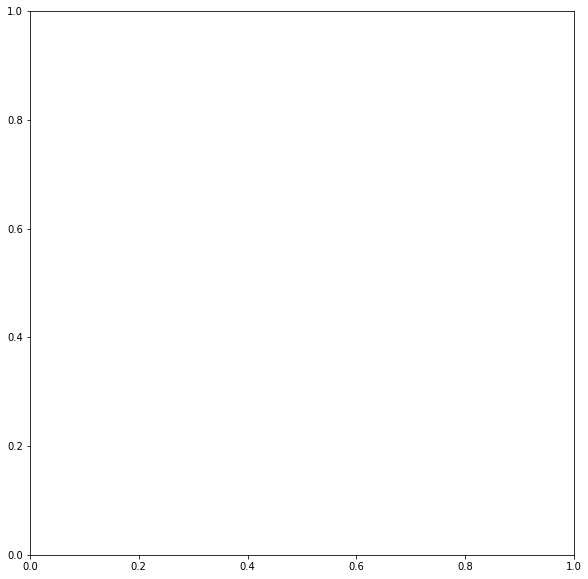

In [19]:

es = json.load(open('loose.json')) 
idx = 4520 
i,k = plot_fp_v2(str(idx),es[str(idx)]['boxes'])
print(i)
plt.figure(figsize=(20,10))
plt.imshow(i)

In [13]:
fp_cases

OrderedDict([('https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_04ffb871b8cdcf7b0177336e3129d721dc68d1ab.jpg',
              [[(366, 660), (408, 701)], [(103, 666), (536, 890)]]),
             ('https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_32d11b4eb37e65e5c875e84c63907de4cd9e712d.jpg',
              [[(681, 129), (1240, 388)]]),
             ('https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7362_detail_damage2_22020_medium_20190424_124819.jpg',
              [[(360, 323), (379, 343)], [(389, 316), (400, 326)]]),
             ('https:__s3.amazonaws.com_mc-imt_vehicle_2018X6701_detail_damage1_16118_medium_image.jpg',
              [[(322, 373), (404, 388)]]),
             ('https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_27dffe0771475c9e949fd0a688989ce61aaca28b.jpg',
              [[(735, 713), (833, 776)], [(1089, 859), (1162, 933)]]),
             ('https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_LG%2014C%20-%20247.00%20-27.10.2018_z

In [20]:
#with open('fp_crack_boxes.json', 'w', encoding='utf-8') as f:
#    json.dump(fp_cases, f, ensure_ascii=False, indent=4)

In [21]:
fp_cases = json.load(open('fp_crack_boxes.json'))
fp_cases

{'https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_04ffb871b8cdcf7b0177336e3129d721dc68d1ab.jpg': [[[366,
    660],
   [408, 701]],
  [[103, 666], [536, 890]]],
 'https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_32d11b4eb37e65e5c875e84c63907de4cd9e712d.jpg': [[[681,
    129],
   [1240, 388]]],
 'https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7362_detail_damage2_22020_medium_20190424_124819.jpg': [[[360,
    323],
   [379, 343]],
  [[389, 316], [400, 326]]],
 'https:__s3.amazonaws.com_mc-imt_vehicle_2018X6701_detail_damage1_16118_medium_image.jpg': [[[322,
    373],
   [404, 388]]],
 'https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_27dffe0771475c9e949fd0a688989ce61aaca28b.jpg': [[[735,
    713],
   [833, 776]],
  [[1089, 859], [1162, 933]]],
 'https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_LG%2014C%20-%20247.00%20-27.10.2018_z1159210384047_f36424a0d2bce4b8ff4449276c80a9d7.jpg': [[[958,
    354],
   [983, 388]]],
 'https:__s3.amazonaws.c

In [17]:
broken = json.load(open(path.parents[0]/'broken'/'annotations'/'total.json'))
print(len(broken['images']),len(broken['annotations']))

3527 4591


In [35]:
count = 0
for name in fp_cases.keys():
    imgs = [i for i in  broken['images'] if i['file_name']==name]
    
    if len(imgs) == 0:
        continue
    
    img = imgs[0]
    annos = [a['bbox'] for a in broken['annotations'] if a['image_id']==img['id']]
    image = cv2.imread(str(path/'images'/name))
    
    for i in range(len(annos)):
        annos[i] = [(int(annos[i][0]),int(annos[i][1])),(int(annos[i][2]),int(annos[i][3]))]
    
    for box in fp_cases[name]:
        ious = [cal_iou(image,box,a) for a in annos]
        print(ious)
        #print(count)
        #count +=1
    
    #print(annos)
    #break

[0, 0, 0]
[0, 0, 0]
[0, 0]
[0, 0]
[0]
[0]
[0]
[0]
[0]
[0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0]
[0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0]
[0]
[0]
[0, 0]
[0, 0]
[0, 0]
[0]
[0]
[0]
[0]
[0]
[0.022749157438613384]
[0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0]
[0, 0]
[0]
[0]
[0]
[0]
[0, 0]
[0]
[0]
[0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0, 0]
[0]
[0, 0]
[0, 0.1657885748441636]
[0]
[0]
[0]
[0]
[0]
[0]
[0, 0, 0, 0]
[0]
[0, 0]
[0]
[0]
[0]
[0]
[0]
[0, 0, 0]
[0, 0, 0]
[0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[0]
[0]
[0]
[0]
[0]
[0]


In [15]:
name = 'https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907553_img2948723.jpg'
i = [i for i in test['images'] if i['file_name']==name][0]
print(i)

{'id': 550, 'license': 4, 'coco_url': 'coco.org', 'flickr_url': 'flickr.org', 'task_name': 'nothing', 'url': 'https://s3.amazonaws.com/mc-ai/dataset/KBC/unzipped/08/44012131907553/img2948723.jpg', 'width': 1152, 'height': 2048, 'file_name': 'https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907553_img2948723.jpg', 'date_captured': '2013-12-15 02:41:52'}


In [17]:
annos = [a for a in test['annotations'] if a['image_id']==550]
print(annos)

[]


In [13]:
eb = json.load(open('ensemble_broken.json'))
print(len(eb.keys()))

3527


In [ ]:
2249 1046 1252
2207 928  1294
# detectoRS 1903 719 1598
# yolov4    1936 589 1565


#old 2314 1225 1187
#new 2241 1045 1260

In [ ]:
#######
'''
esemble predict for all broken datasets
592 3887 3999

esemble predict for all with smaller broken datasets
122 528 779
'''

In [ ]:
'''
DENT
detectoRS

TP    FP    FN
2012 1761 1489 AP=0.53 AR=0.57

yolov4
1937 1101 1564 AP = 0.63 AR=0.55

ensemble for dent
2120 1848 1381 AP=0.53 AR=0.6
2205 1733 1296 ap=0.56 AR=0.62
'''

In [27]:
581/(581+646)

0.47351263243683783

In [28]:
588/(588+639)

0.4792176039119804

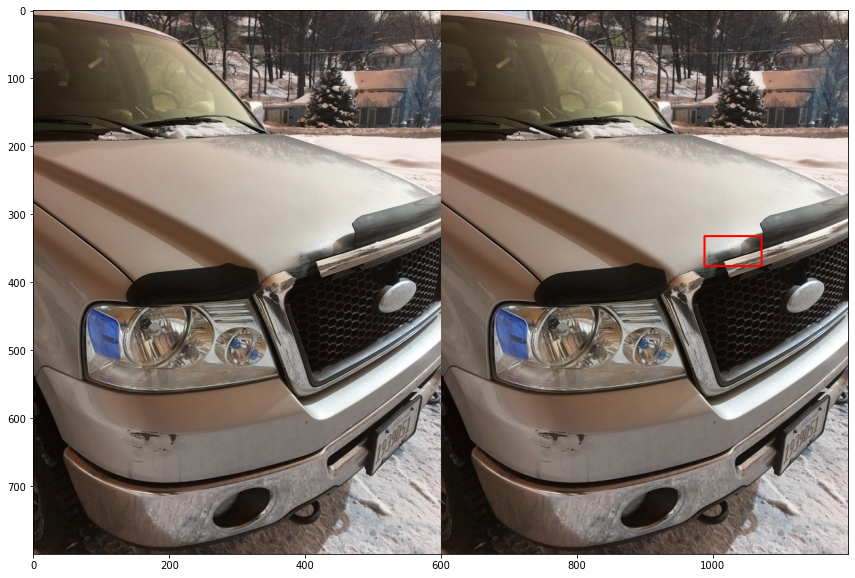

In [75]:
idx = 14999
plot(idx, es[str(idx)]['boxes'])

In [21]:
def plot_annos(image_id):
    img = [i for i in test['images'] if i['id']==image_id][0]
    image = cv2.imread(str(path/'images'/img['file_name']))
    
    annos = [np.array(a['segmentation']).reshape(-1,2).astype(np.int32) for a in test['annotations'] if a['image_id']==image_id]
    cv2.drawContours(image,annos,-1,(255,255,0),2)
    
    gt_boxes = [a['bbox'] for a in test['annotations'] if a['image_id']==image_id]
    gt_boxes = [[(int(b[0]),int(b[1])),(int(b[0])+int(b[2]),int(b[1])+int(b[3]))] for b in gt_boxes]
    
    for i in range(len(gt_boxes)):
        image = cv2.rectangle(image,gt_boxes[i][0],gt_boxes[i][1],(255,255,0),2)
        
    return image
    #plt.imshow(image)

In [38]:
from PIL import Image
es = json.load(open('new_and_ensemble_crack_off.json'))
test_path = Path('./tp_crack_off_ensemble')
test_path.mkdir(parents=True, exist_ok=True)
for i in tqdm(test['images']):
    idx = i['id']
    #cv2.imwrite(str(test_path)+'/'+str(i['id'])+'.png',plot_fp_v2(idx,es[str(idx)]['boxes']))
    #out = plot_fp_v2_with_segm(idx,es[str(idx)]['boxes'],es[str(idx)]['segms'])
    out,check = plot_fp_v2(idx,es[str(idx)]['boxes'])
    #plt.figure(figsize=(20,10))
    #plt.imshow(out)
    if out is None:
        continue
    #if out.any() != None : 
    img = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)
    im_pil = Image.fromarray(img)
    im_pil.save(str(test_path)+'/'+str(i['id'])+'.png',optimize=True,quality=70)
    #break
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 738/738 [01:25<00:00,  8.66it/s]


In [40]:
for i,k in enumerate(es.keys()):
    #print(i)
    print(es[k]['segms'])
    if i == 2:
        break

[[[[[501, 2]], [[500, 3]], [[488, 3]], [[487, 4]], [[481, 4]], [[480, 5]], [[479, 5]], [[478, 6]], [[477, 6]], [[474, 9]], [[474, 15]], [[475, 16]], [[475, 18]], [[476, 19]], [[476, 22]], [[477, 23]], [[477, 24]], [[478, 25]], [[478, 27]], [[481, 30]], [[481, 31]], [[485, 35]], [[485, 36]], [[486, 37]], [[486, 38]], [[487, 39]], [[487, 40]], [[488, 41]], [[488, 42]], [[489, 43]], [[489, 45]], [[490, 46]], [[490, 49]], [[491, 50]], [[491, 53]], [[492, 54]], [[492, 57]], [[493, 58]], [[493, 60]], [[494, 61]], [[494, 62]], [[495, 63]], [[495, 64]], [[496, 65]], [[496, 66]], [[504, 74]], [[504, 75]], [[506, 77]], [[506, 78]], [[507, 79]], [[507, 81]], [[508, 82]], [[508, 85]], [[509, 86]], [[509, 90]], [[510, 91]], [[510, 95]], [[511, 96]], [[511, 98]], [[512, 99]], [[512, 101]], [[513, 102]], [[513, 103]], [[514, 104]], [[514, 106]], [[516, 108]], [[516, 109]], [[517, 110]], [[517, 111]], [[524, 118]], [[524, 119]], [[526, 121]], [[526, 122]], [[527, 123]], [[527, 124]], [[528, 125]], [[5

In [52]:
len(es.keys())

584

In [26]:
test_path = Path('./meeting/totaled')
test_path.mkdir(parents=True, exist_ok=True)
for i in test['images']:
    cv2.imwrite(str(test_path)+'/'+str(i['id'])+'.png',plot_annos(i['id']))

In [20]:
test['images'][0]

{'id': 195,
 'license': 4,
 'coco_url': 'coco.org',
 'flickr_url': 'flickr.org',
 'scalabel_url': 'https://s3.amazonaws.com/mc-imt/vehicle/2019A5704/detail_damage2/31993/medium/1572626634206839735194377895140.jpg',
 'width': 700,
 'height': 525,
 'file_name': 'https:__s3.amazonaws.com_mc-imt_vehicle_2019A5704_detail_damage2_31993_medium_1572626634206839735194377895140.jpg',
 'date_captured': '2013-12-15 02:41:52'}

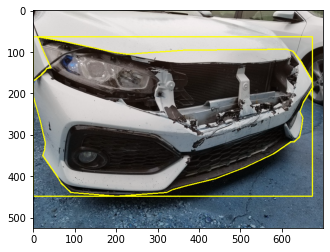

In [23]:
plot_annos(195)

In [15]:
es['2650']

{'name': 'https:__s3.amazonaws.com_mc-imt_vehicle_2018T8083_front_left_view_5502_medium_image.jpg',
 'boxes': [],
 'labels': []}

In [ ]:
## iou_thres = 0.5
# 1: 1 590 778 
# 2: 1 592 776

## iou_thres = 0.25
# 2: 1 581 695 

# iou = 0.36 weight 2 : 1 0.4
#581 646 573                      AP= 0.47 AR=0.5 crack
#567 596 587                      AP= 0.49 AR=0.49
#587 640 598 area < 800 (31 more) 
#588 639 606 area < 1000 (40 more)

In [ ]:
461 351 691
497 377 840

In [35]:
def es_objective_hypertune(params):
    print(params)
    pred_data = json.load(open('detector_pred_04.json'))
    pred_data_flip = json.load(open('yolo_pred.json'))
    
    es = OrderedDict()
    for i in test['images']:
        boxes_list = [pred_data[str(i['id'])]['boxes'], pred_data_flip[str(i['id'])]['boxes']]
        scores_list = [pred_data[str(i['id'])]['scores'], pred_data_flip[str(i['id'])]['scores']]
        labels_list = [pred_data[str(i['id'])]['labels'], pred_data_flip[str(i['id'])]['labels']]

        if len(boxes_list[0]) == 0 and len(boxes_list[1])==0:
            i_data = OrderedDict()
            i_data['name'] = i['file_name']
            i_data['boxes'] = []
            i_data['labels'] = []
            es[str(i['id'])] = i_data
            continue

        if len(boxes_list[0]) == 0 :
            i_data = OrderedDict()
            i_data['name'] = i['file_name']
            i_data['boxes'] = boxes_list[1]
            i_data['labels'] = labels_list[1]
            es[str(i['id'])] = i_data
            continue

        if len(boxes_list[1]) == 0 :
            i_data = OrderedDict()
            i_data['name'] = i['file_name']
            i_data['boxes'] = boxes_list[0]
            i_data['labels'] = labels_list[0]
            es[str(i['id'])] = i_data
            continue
        # tuning here
        weights = [params['weight']+1,1]
        iou_thr = params['threshold']
        skip_box_thr = 0.0001
        sigma = 0.1

        boxes, scores, labels = non_maximum_weighted(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr,skip_box_thr=skip_box_thr)

        i_data = OrderedDict()
        i_data['name'] = i['file_name']
        i_data['boxes'] = boxes.tolist()
        i_data['labels'] = labels.tolist()
        es[str(i['id'])] = i_data

    total_tp = 0
    total_fn = 0
    total_fp = 0
    for i in test['images']:
        image = cv2.imread(str(path/'images'/i['file_name']))
        h,w,_=image.shape
        gt_boxes = [a['bbox'] for a in test['annotations'] if a['image_id']==i['id']]
        gt_boxes = [[(int(b[0]),int(b[1])),(int(b[0])+int(b[2]),int(b[1])+int(b[3]))] for b in gt_boxes]
        gt_labels = [a['category_id'] for a in test['annotations'] if a['image_id']==i['id']]

        pred_boxes = copy.deepcopy(es[str(i['id'])]['boxes'])
        for j in range(len(pred_boxes)):
            pred_boxes[j][0] = int(pred_boxes[j][0]*w)
            pred_boxes[j][1] = int(pred_boxes[j][1]*h)
            pred_boxes[j][2] = int(pred_boxes[j][2]*w)
            pred_boxes[j][3] = int(pred_boxes[j][3]*h)

            pred_boxes[j] = [(pred_boxes[j][0],pred_boxes[j][1]),(pred_boxes[j][2],pred_boxes[j][3])]
        pred_labels = es[str(i['id'])]['labels']

        tp,fp,fn = cal(image,pred_boxes,pred_labels,gt_boxes,gt_labels, i['file_name'])
        total_tp += tp
        total_fp += fp
        total_fn += fn
    print(total_tp,total_fp)
    return total_fp - 2*total_tp

def tuning():
    from hyperopt import hp, tpe,Trials,fmin
    
    space = {'threshold' : hp.uniform('threshold',0.2,0.6),
            'weight' : hp.randint('weight',5),
            }
    result = fmin(fn=objective_hypertune, space=space,algo=tpe.suggest,trials=Trials(),max_evals = 15)
    
    return result
    

In [ ]:
def score_oh(params):
    total_tp = 0
    total_fn = 0
    total_fp = 0
    
    for i in test['images']:
        image = cv2.imread(str(path/'images'/i['file_name']))
        h,w,_=image.shape
        gt_boxes = [a['bbox'] for a in test['annotations'] if a['image_id']==i['id']]
        gt_boxes = [[(int(b[0]),int(b[1])),(int(b[0])+int(b[2]),int(b[1])+int(b[3]))] for b in gt_boxes]
        gt_labels = [a['category_id'] for a in test['annotations'] if a['image_id']==i['id']]
        
        result = inference_detector(model, image.copy())
        img_,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(model, image.copy(), result,score_thr=params['confident_score'])
        
        tp,fp,fn = cal(image,pred_boxes,pred_labels,gt_boxes,gt_labels, i['file_name'])
        total_tp += tp
        total_fp += fp
        total_fn += fn
        
    print("{} - TP : {} ,FP : {}, AP : {}".format(params['confident_score'],total_tp,total_fp,total_tp/(total_tp+total_fp)))
    
    return total_fp/(total_tp+total_fp)

def tuning_confident():
    from hyperopt import hp, tpe,Trials,fmin
    
    space = {'confident_score' : hp.uniform('confident_score',0.2,0.5),
            }
    result = fmin(fn=score_oh, space=space,algo=tpe.suggest,trials=Trials(),max_evals = 15)
    
    return result

print(tuning_confident())

0.4268592110572746 - TP : 443 ,FP : 355, AP : 0.5551378446115288
0.4789813947478013 - TP : 433 ,FP : 318, AP : 0.5765645805592543                   
 13%|█▎        | 2/15 [11:14<1:13:03, 337.22s/trial, best loss: 0.4234354194407457]

In [ ]:
#0.47680153265311676-423-332 
#0.46405537190928414 - TP : 425 ,FP : 339, AP : 0.556282722513089 

In [36]:
print(tuning())

{'threshold': 0.20186076643958806, 'weight': 1}       
569                                                   
602                                                   
{'threshold': 0.5889840584415416, 'weight': 0}                      
581                                                                 
725                                                                 
{'threshold': 0.34653284314044225, 'weight': 1}                     
579                                                                 
643                                                                 
{'threshold': 0.5142339445566273, 'weight': 2}                      
578                                                                 
695                                                                 
{'threshold': 0.5506285420334487, 'weight': 3}                      
579                                                                 
709                                                                 
{'thres

In [ ]:
# 0.3 {'threshold': 0.2003033575511911, 'weight': 0}
# 0.4 {'threshold': 0.36257411346807455, 'weight': 1}

In [ ]:
coco_js = json.load(open('new_and_ensemble_dent.json'))
out = []
for k in tqdm(coco_js.keys()):
    if len(coco_js[k]['boxes']) == 0:
        continue
    img = cv2.imread(str(path/'images'/coco_js[k]['image']))
    h,w = img.shape[:2]
    
    #print(box['bbox'])
    for i,b in enumerate(coco_js[k]['boxes']):
        box = OrderedDict()
        box['image_id'] = int(k)
        box['category_id'] = 0
        #box['bbox'] = 
        #print(b,i)
        #print(coco_js[k]['scores'][i])
        box['bbox'] = [b[0]*w,b[1]*h,(b[2]-b[0])*w,(b[3]-b[1])*h]
        box['score'] = coco_js[k]['scores'][i]
        #print(box)
        #break
        out.append(box)
    #print(box['bbox'])
    #break
    
with open('ensemble_dent_coco_eval.json', 'w') as f:
    json.dump(out, f)

In [31]:
from pycocotools.coco import COCO
from fast_eval_api import COCOeval_opt as COCOeval

In [41]:
imgIds = [i['id'] for i in test['images']]
cocoGt = COCO(str(path/'annotations'/'test.json'))
#print(cocoGt)
cocoDt = cocoGt.loadRes('ensemble_dent_coco_eval.json')
cocoEval = COCOeval(cocoGt,cocoDt,'bbox')
cocoEval.params.imgIds = imgIds
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.23s).
Accumulating evaluation results...
DONE (t=0.20s).
 Average Precision  (AP) @[ IoU=0.10:0.95 | area=   all | maxDets=100 ] = 0.225
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.253
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.25      | area=   all | maxDets=100 ] = 0.404
 Average Precision  (AP) @[ IoU=0.10      | area=   all | maxDets=100 ] = 0.459
 Average Precision  (AP) @[ IoU=0.10:0.95 | area= small | maxDets=100 ] = 0.126
 Average Precision  (AP) @[ IoU=0.10:0.95 | area=medium | maxDets=100 ] = 0.181
 Average Precision  (AP) @[ IoU=0.10:0.95 | area= large | maxDets=100 ] = 0.312
 Average Recall     (AR) @[ IoU=0.10:0.95 | area=   all | maxDet

In [43]:
print(test['categories'])
print(len(test['images']),len(test['annotations']))

[{'supercategory': 'Carparts', 'id': 0, 'name': 'dent'}]
2252 3501


In [44]:
import random
imgs = random.sample(test['images'],10)
ids = [i['id'] for i in imgs]
annos = [a for a in test['annotations'] if a['image_id'] in ids]
print(len(imgs),len(annos))

10 12


In [45]:
tiny_test = copy.deepcopy(test)
tiny_test['images'] = imgs
tiny_test['annotations'] = annos

In [46]:
with open('tiny_dent_test.json', 'w', encoding='utf-8') as f:
    json.dump(tiny_test, f, ensure_ascii=False, indent=4)

In [48]:
demo_test = json.load(open('tiny_dent_test.json'))
print(len(demo_test['images']),len(demo_test['annotations']))

10 12


In [83]:
data = OrderedDict()

for i in tqdm(demo_test['images']):
    image = cv2.imread(str(path/'images'/i['file_name']))
    result = inference_detector(model, image)
    img_,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(model, image.copy(), result,score_thr=0.25)
    data[i['id']] = get_data_box(image,i['id'],i['file_name'],pred_boxes,pred_segms,pred_labels,pred_scores)
    #break
with open('demo_test_dent_coco_eval.json', 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=4)

100%|██████████| 10/10 [00:04<00:00,  2.00it/s]


In [10]:
coco_js = json.load(open('demo_test_dent_coco_eval.json'))
out = []
for k in tqdm(coco_js.keys()):
    if len(coco_js[k]['boxes']) == 0:
        continue
    img = cv2.imread(str(path/'images'/coco_js[k]['image']))
    h,w = img.shape[:2]
    
    #print(box['bbox'])
    for i,b in enumerate(coco_js[k]['boxes']):
        box = OrderedDict()
        box['image_id'] = int(k)
        box['category_id'] = 0
        #box['bbox'] = 
        #print(b,i)
        #print(coco_js[k]['scores'][i])
        box['bbox'] = [b[0]*w,b[1]*h,(b[2]-b[0])*w,(b[3]-b[1])*h]
        box['score'] = coco_js[k]['scores'][i]
        #print(box)
        #break
        out.append(box)
    #print(box['bbox'])
    #break
print('number of predict :',len(out))
with open('ensemble_demo_test_dent_coco_eval.json', 'w') as f:
    json.dump(out, f)

100%|██████████| 10/10 [00:00<00:00, 46.34it/s]

number of predict : 11


In [13]:
from pycocotools.coco import COCO
from fast_eval_api import COCOeval_opt as COCOeval

imgIds = [i['id'] for i in test['images']]
cocoGt = COCO('tiny_dent_test.json')
#print(cocoGt)
cocoDt = cocoGt.loadRes('ensemble_demo_test_dent_coco_eval.json')
cocoEval = COCOeval(cocoGt,cocoDt,'bbox')
cocoEval.params.imgIds = imgIds
cocoEval.params.catIds = [0]
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.10:0.95 | area=   all | maxDets=100 ] = 0.425
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.449
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.25      | area=   all | maxDets=100 ] = 0.619
 Average Precision  (AP) @[ IoU=0.10      | area=   all | maxDets=100 ] = 0.619
 Average Precision  (AP) @[ IoU=0.10:0.95 | area= small | maxDets=100 ] = 0.131
 Average Precision  (AP) @[ IoU=0.10:0.95 | area=medium | maxDets=100 ] = 0.281
 Average Precision  (AP) @[ IoU=0.10:0.95 | area= large | maxDets=100 ] = 0.620
 Average Recall     (AR) @[ IoU=0.10:0.95 | area=   all | maxDet